In [1]:
#Used for displaying plots below the cell, inverts %matplotlib inline
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sn

from collections import defaultdict
from collections import OrderedDict
from scipy.stats.stats import pearsonr

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score, davies_bouldin_score, euclidean_distances
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist #Condensed matrix output

import mpl_toolkits.mplot3d.axes3d as p3

from pyclustering.cluster.fcm import fcm
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

import itertools
from pyclustertend import hopkins

# Task 2: Clustering

In [2]:
vendor_df_num = pd.read_csv('../DM_14_TASK1/task1-result_num_wo_out.csv', sep=',', index_col=[0,1])
vendor_df_cat = pd.read_csv('../DM_14_TASK1/task1-result_cat_wo_out.csv', sep=',', index_col=[0,1])

Due to some preliminary testing (not included in the notebook) we decided to perform the clustering analysis using the vendor dataset without outliers.

In [3]:
vendor_df_num.head()

I   Iu  MaxValuePerOrder  \
vendor_code name                                                 
1           1stWave Technologies    774   60        565.439098   
2           Adorama                3274  186       1761.990000   
3           Alternate              3047  203        860.154236   
4           Alternate Italia        407  101        774.077840   
5           Alza                  12959  276       1188.115658   

                                  AvgValuePerOrder  AvgMemoryPerOrder  \
vendor_code name                                                        
1           1stWave Technologies        132.989886          13.074935   
2           Adorama                     146.248003          14.628894   
3           Alternate                   155.134195          11.530030   
4           Alternate Italia            142.140184          10.034398   
5           Alza                        166.036705          13.514777   

                                  IAvgMonthSales  TotMonthBusiness      Eram  \
vendor_code name                                                               
1           1stWave Technologies     4117.366865                25  5.361843   
2           Adorama                 23940.798168                20  6.754711   
3           Alternate              157564.631150                 3  7.373634   
4           Alternate Italia        28925.527422                 2  6.486558   
5           Alza                   126568.803904                17  7.612859   

                                      Egeo      Ecur  
vendor_code name                                      
1           1stWave Technologies  0.643988  0.643988  
2           Adorama               0.000000  0.000000  
3           Alternate             1.679995  0.000000  
4           Alternate Italia      0.898296  0.898296  
5           Alza                  1.165894  1.094659

In [4]:
vendor_df_cat.head()

TopBrand                TopCountry  \
vendor_code name                                                       
1           1stWave Technologies   CORSAIR                New Zeland   
2           Adorama                CRUCIAL  United States of America   
3           Alternate              G.SKILL                    France   
4           Alternate Italia       G.SKILL                     Italy   
5           Alza                  KINGSTON            United Kingdom   

                                 TopCurrency  TopSalesMonth  
vendor_code name                                             
1           1stWave Technologies         NZD             11  
2           Adorama                      USD              4  
3           Alternate                    EUR              3  
4           Alternate Italia             EUR              3  
5           Alza                         GBP             12

## Normalization

In [5]:
vend_scaler = MinMaxScaler()
vend_scaler.fit(vendor_df_num.values)
vendor_norm = vend_scaler.transform(vendor_df_num.values)
vendor_df_norm = pd.DataFrame(vendor_norm, index=vendor_df_num.index, columns=vendor_df_num.columns)

## Auxiliary functions

### Miscellaneous

In [6]:
def compute_cluster_means(data_points, labels):
    
    clust_mean = pd.DataFrame()
    for label in sorted(np.unique(labels)):
        
        cur_clust = []
        
        for id_p in range(len(data_points)):
            if(label == labels[id_p]):
                cur_clust.append(data_points[id_p])
                
        cur_clust_df = pd.DataFrame(cur_clust)
        clust_mean = clust_mean.append(cur_clust_df.mean(), ignore_index=True)

    clust_mean = np.array(clust_mean)
    
    return clust_mean

def compute_cluster_stds(data_points, labels):
    
    clust_std = pd.DataFrame()
    for label in sorted(np.unique(labels)):
        
        cur_clust = []
        
        for id_p in range(len(data_points)):
            if(label == labels[id_p]):
                cur_clust.append(data_points[id_p])
                
        cur_clust_df = pd.DataFrame(cur_clust)
        clust_std = clust_std.append(cur_clust_df.std(), ignore_index=True)

    clust_std = np.array(clust_std.replace(np.nan, 0))
    
    return clust_std

#Takes a set of points and computes its sse ignoring labels
def compute_sse_cluster(data_points):
    
    #Consider all points as belonging to the same cluster
    center = compute_cluster_means(data_points, [0 for i in range(len(data_points))])[0]
    
    sum_sq_err = 0
        
    for p in data_points:
        eucl_norm = np.linalg.norm(center-p, ord=2)
        sum_sq_err = sum_sq_err + pow(eucl_norm, 2)
    
    return sum_sq_err
            
#Allows for computing both the global sse with labels or only a subset of the labels
def compute_sse_global(data_points, labels, labels_subset=None):
    
    sum_sq_err = 0
    for label in sorted(np.unique(labels)):
        
        if(labels_subset != None and label not in labels_subset):
            continue
        
        cur_clust = []
        
        for id_p in range(len(data_points)):
            if(label == labels[id_p]):
                cur_clust.append(data_points[id_p])
                
        sum_sq_err = sum_sq_err + compute_sse_cluster(cur_clust)

    return sum_sq_err

def compute_ideal_similarity_coeff(data_points, cluster_labels):
    
    proximity_matrix = pairwise_distances(data_points)
    
    ideal_matrix = np.empty((len(cluster_labels), len(cluster_labels)))
    
    for i in range(len(cluster_labels) - 1):
        for j in range(i, len(cluster_labels)):
            
            if(cluster_labels[i] == cluster_labels[j]):
                ideal_matrix[i][j] = 1
                ideal_matrix[j][i] = 1
        
    res = np.corrcoef(ideal_matrix, proximity_matrix)
    
    return res

def cluster_dimensions(labels):
    
    label_dict = {x:0 for x in sorted(np.unique(labels))}
    
    for i in range(len(labels)):
        label_dict[labels[i]] = label_dict[labels[i]] + 1
    
    return label_dict

#Counts clusters containing only 1 data point
def count_singletons(labels):
    
    dim_list = list(cluster_dimensions(labels).values())

    return dim_list.count(1)

#Function that maps the list labels of a cluster to new values using a dict
def remap_clust_labels(labels, new_labels_dict):
    
    new_labels = labels.copy()
    
    for i in range(len(new_labels)):
        new_labels[i] = new_labels_dict[new_labels[i]]
        
    return new_labels

def group_singleton_clusters(labels):
    
    count_dict = {id_cluster: 0 for id_cluster in np.unique(labels)}
    grouped_dict = {}
    
    for i in labels:
        count_dict[i] = count_dict[i] + 1
        
    for key in count_dict.keys():
        if count_dict[key] == 1:
            grouped_dict[key] = -1
        else:
            grouped_dict[key] = key
    
    return grouped_dict

def cluster_id_resolver(data_points, labels, conditions_dict, col_names):
    
    avg_list = compute_cluster_means(data_points, labels)
    avg_df = pd.DataFrame(avg_list,columns=col_names)
    
    for key, condition in conditions_dict.items():
        
        loc_str = f'avg_df.loc[avg_df["{key}"] {condition}]'
        avg_df = eval(loc_str)
        
    if avg_df.shape[0] > 1:
        raise RuntimeError("More than 1 cluster determined. More conditions needed.")
        
    if avg_df.shape[0] == 0:
        raise RuntimeError("No valid candidate found.")
        
    return avg_df.index[0]

def create_external_indices(cat_df, model):
    
    ext_ind=pd.DataFrame()

    comb = list()
    hom = list()
    compl = list()
    mutinfo = list()

    for column in cat_df.columns:
        comb.append(column)
        hom.append(metrics.homogeneity_score(cat_df[column], model.labels_))
        compl.append(metrics.completeness_score(cat_df[column], model.labels_))
        mutinfo.append(metrics.normalized_mutual_info_score(cat_df[column], model.labels_, average_method='arithmetic'))

    ext_ind['Feature'] = comb
    ext_ind['Homogeneity'] = hom
    ext_ind['Completeness'] = compl
    ext_ind['Mutual Info'] = mutinfo
    
    return ext_ind

#Compare different model labels using the same metrics used for external indices
def compare_model_labels(model_dict, map_dict):

    #model_dict = {"name":model}
    #map_dict = {"name":map}
    ext_ind=pd.DataFrame()

    comb1 = list()
    comb2 = list()
    hom = list()
    compl = list()
    mutinfo = list()
    map1 = list()
    map2 = list()
    
    keys_list = list(model_dict.keys())

    for i in range(len(keys_list)):
        
        for j in range(i+1, len(keys_list)):
            
            if i == j:
                continue
            
            key1 = keys_list[i]
            key2 = keys_list[j]
            model1 = model_dict[key1]
            model2 = model_dict[key2]

            comb1.append(key1 + f" ({len(np.unique(model1.labels_))} labels)")
            comb2.append(key2 + f" ({len(np.unique(model2.labels_))} labels)")
            hom.append(metrics.homogeneity_score(model1.labels_, model2.labels_))
            compl.append(metrics.completeness_score(model1.labels_, model2.labels_))
            mutinfo.append(metrics.normalized_mutual_info_score(model1.labels_, model2.labels_, average_method='arithmetic'))
            # Tuple is more easily handled by pandas compared to a list
            map1.append(tuple(map_dict[key1]))
            map2.append(tuple(map_dict[key2]))

    ext_ind['Model 1'] = comb1
    ext_ind['Model 2'] = comb2
    ext_ind['Homogeneity'] = hom
    ext_ind['Completeness'] = compl
    ext_ind['Mutual Info'] = mutinfo
    ext_ind['Labels 1'] = map1
    ext_ind['Labels 2'] = map2
    
    return ext_ind

### Clustering wrapper classes/functions


In [7]:
#Change cluster labels representation array format from pyclustering to sklearn
#ie [[1,2], [0]] -> [1, 0, 0]
def pyclust_sklearn_cluster_conv(pyclust_array):
    
    tot_len = 0
    
    for array in pyclust_array:
        tot_len = tot_len + len(array)
    
    out_array = np.empty(tot_len, dtype=int)
    
    for i in range(len(pyclust_array)):
        
        for value in pyclust_array[i]:
            out_array[value] = i
            
    return out_array

# Compatibility class to use pyclustering's fcm the same as a sklearn model
class fcm_sk:
    
    __max_iter = 10
    __init = None
    
    n_clusters = 1
    labels_ = []
    cluster_centers_ = []
    
    def __init__(self, n_clusters=8, init="k-means++", max_iter=300):
        self.n_clusters = n_clusters
        self.__max_iter = max_iter
        self.__init = init
        
    def set_params(self, **params):
        
        for key, value in params.items():
            if(key == "n_clusters"):
                self.n_clusters = value
                
    def get_params(self):
        
        return {"n_clusters":self.n_clusters}
        
    def fit(self, X):
        
        best_silhouette = -1
        best_labels = []
        
        if(isinstance(self.__init, str) and self.__init == "k-means++"):
            # Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
            # start analysis.
            initial_centers = kmeans_plusplus_initializer(X, self.n_clusters).initialize()

        elif(isinstance(self.__init, np.ndarray)):
            initial_centers = self.__init
        else:
            raise RuntimeError("init can be 'k-means++' or a numpy ndarray containing the centers")

        # Create instance of X-Means algorithm. The maximum number of clusters that can be allocated is 20.
        clust_algo = fcm(X, initial_centers, itermax=self.__max_iter)
        clust_algo.process()

        # Extract clustering results: clusters and their centers
        clusters = clust_algo.get_clusters()
        self.cluster_centers_ = clust_algo.get_centers()

        self.labels_ = pyclust_sklearn_cluster_conv(clusters)
        
        return self
    
#Used to interact with functions that take an sklearn model as input but need only labels_ parameter to function
class wrapper_sk:
    
    n_clusters = 1
    labels_ = []
    linkage = None
    
    def __init__(self, labels):
        self.labels_ = labels
        self.n_clusters = len(labels)
        
    def set_params(self, **params):
        
        for key, value in params.items():
            
            if key == "n_clusters":
                self.n_clusters = value
                
            elif key == "linkage":
                self.linkage = value
                
    def get_params(self):
        
        return {"n_clusters":self.n_clusters, "linkage":self.linkage}

### Visualisation

In [92]:
#Shared by the following two plot_metrics_* functions
def plot_metrics(metrics_dict, x_name, x_list, xticks_list):
    
    metrics_list = metrics_dict.keys()
    multiple_plot_bool = False
    
    fig = plt.figure(figsize=(20,5))
    fig_dims = (1, 1)
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    
    #Separate plot for sse to get a feel for the scale
    if("sse" in metrics_list):
        
        if(len(metrics_list) > 1):
            fig_dims = (1, 2)
            plt.subplot2grid(fig_dims, (0, 0))
            multiple_plot_bool = True
        
        sse_list = np.reshape(metrics_dict["sse"], (-1, 1))

        plt.plot(x_list, sse_list, label='SSE')
        
        plt.xlabel(x_name, fontsize=18)
        plt.tick_params(axis='both', which='major', labelsize=18)
        plt.xticks(xticks_list)
        plt.legend()
    
    #Enable second subplot
    if(multiple_plot_bool):
            plt.subplot2grid(fig_dims, (0, 1))
        
    #All other metrics
    for metric in metrics_list:
          
        if(metric.lower() == "sse"):
            continue
        elif(metric.lower() == "db"):
            plt.plot(x_list, metrics_dict[metric], label='Davies-Bouldin')
        elif(metric.lower() == "sil"):
            plt.plot(x_list, metrics_dict[metric], label='Silhouette')
        elif(metric.lower() == "noise_ratio"):
            plt.plot(x_list, metrics_dict[metric], label='Noise ratio')
        elif(metric.lower() == "clusters"):
            for i in range(len(metrics_dict["clusters"])):
                plt.scatter(x_list[i], 1, marker=f"${metrics_dict['clusters'][i]}$")
        else:
            raise RuntimeError

    plt.xlabel(x_name, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.xticks(xticks_list)
    plt.legend()
    
    plt.show()

    
def plot_metrics_per_k(data_points, metrics_arr, model_sk=None):
    max_k = 20
    metrics_dict = {}
    
    for metric in metrics_arr:
        metrics_dict[metric] = list()

    for k in range(2, max_k + 1): #Starting from k=2 to k=40
        
        if model_sk:
            model_sk.set_params(**{"n_clusters":k})
            model_sk.fit(data_points)
            cluster_labels = model_sk.labels_
        else:
            raise RuntimeError
            
        for metric in metrics_arr:
            
            if(metric.lower() == "sse"):
                metrics_dict[metric].append(compute_sse_global(data_points, cluster_labels))
            elif(metric.lower() == "db"):
                metrics_dict[metric].append(davies_bouldin_score(data_points, cluster_labels))
            elif(metric.lower() == "sil"):
                metrics_dict[metric].append(silhouette_score(data_points, cluster_labels))
            else:
                raise RuntimeError
                
    plot_metrics(metrics_dict, "K", np.arange(2, max_k+1, 1), np.arange(0, max_k+1, 2))
    
    
def plot_metrics_per_eps(data_points, metrics_arr, max_eps=3, precision=0.10, model_sk=None):
    metrics_dict = {}
    eps_list = list()
    
    
    for metric in metrics_arr:
        metrics_dict[metric] = list()
        
    for i in range(int(max_eps//precision)):
        
        e = i*precision
        if(e == 0):
            e = precision
        
        if model_sk:
            model_sk.set_params(**{"eps":e})
            model_sk.fit(data_points)
            cluster_labels = model_sk.labels_
            
            # Avoid problem with silhouette and singleton cluster
            if(len(np.unique(cluster_labels)) >= 2):
                eps_list.append(e)
            else:
                continue
            
        else:
            raise RuntimeError
            
        for metric in metrics_arr:
            
            if(metric.lower() == "sse"):
                metrics_dict[metric].append(compute_sse_global(data_points, cluster_labels))
            elif(metric.lower() == "db"):
                metrics_dict[metric].append(davies_bouldin_score(data_points, cluster_labels))
            elif(metric.lower() == "sil"):
                metrics_dict[metric].append(silhouette_score(data_points, cluster_labels))
            elif(metric.lower() == "noise_ratio"):
                metrics_dict[metric].append(list(cluster_labels).count(-1)/len(cluster_labels))
            elif(metric.lower() == "clusters"):
                metrics_dict[metric].append(len(np.unique(cluster_labels)))
            else:
                raise RuntimeError
                
    plot_metrics(metrics_dict, "Eps", eps_list, eps_list)
    
    
#https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, max_d=[0], **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples] #Non-leaf node indexing
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    
    plt.figure(figsize=(10, 5))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.ylabel("Distance")
    
    # Plot the corresponding dendrogram
    dendrogram(
        linkage_matrix, 
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
        **kwargs)
    
    if max_d[0] != 0:
        for i in max_d:
            plt.axhline(y=i, c='k', linestyle='--')
        
    plt.show()

#Allows for more flexibility in use compared to the function defined in pandas for parallel coordinates
def plot_parallel_coordinates(data_points, labels_list, title=None):
    
    if(title != None):
        plt.title(title)
    
    for i in range(0, len(data_points)):
        color_space_len = (np.max(labels_list) - np.min(labels_list)) + 1
        colors = plt.cm.rainbow(np.linspace(0, 1, color_space_len))
        plt.plot(data_points[i], marker='o', label='Cluster %s' % labels_list[i], color=colors[labels_list[i]])
        
    plt.tick_params(axis='both', which='major')
    #Vendor dataframe hard-coded
    plt.xticks(range(0, len(vendor_df_num.columns)), vendor_df_num.columns, rotation=90)
    plt.legend(fontsize=10)
    
#Plot the distances of the nearest neighbourse of a data point, in ascending order
def plot_knn_dist(nearest_n_list, datapoints_list):

    if(len(datapoints_list) != len(nearest_n_list)):
        raise RuntimeException
        
    list_len = len(nearest_n_list)
    nearest_dist_list = list()
    
    for i in range(list_len):
        
        nbrs = NearestNeighbors(n_neighbors=nearest_n_list[i], algorithm='ball_tree').fit(datapoints_list[i])
        distances, indices = nbrs.kneighbors(datapoints_list[i])

        nearest_dist_list.append(
            pd.DataFrame(distances)[nearest_n_list[i]-1].sort_values().reset_index()\
            .rename({"index":"orig_point", nearest_n_list[i]-1:"distance"}, axis=1)
        )

    # Knndistplot
    fig = plt.figure(figsize=(20, 5)) 
    fig_dims = (1, list_len)
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
        
    for i in range(list_len):

        plt.subplot2grid(fig_dims, (0, i))
        plt.title("Knn-distplot")
        nearest_dist_list[i]["distance"].plot()
        plt.xlabel("Points sorted by distance")
        plt.ylabel(f"Distance to the {nearest_n_list[i]}-nth neighbour")

    plt.show()

#Plot half of the symmetric scatter matrix of all the features colored by label
def plot_2d_scatter_matrix(feature_df, labels, centers=None):
    
    n_cells = len(feature_df.columns)*(len(feature_df.columns)-1)//2
    
    n_cols = 5
    n_rows = int(np.ceil(n_cells/n_cols))
    
    colors = plt.cm.rainbow(labels.astype(float) / len(np.unique(labels)))
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 3*n_rows))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    
    cell_count = 0
    
    for i in range(len(feature_df.columns)):
        
        column_i = feature_df.columns[i]
        
        for j in range(i+1, len(feature_df.columns)):
                
            column_j = feature_df.columns[j]
            
            cur_col = cell_count//n_cols
            cur_row = cell_count%n_cols
            
            cell_count += 1
                
            axes[cur_col][cur_row].scatter(feature_df[column_i], feature_df[column_j], marker='.', c=colors)

            if centers is not None:
                
                axes[cur_col][cur_row].scatter(centers[:, i], centers[:, j], marker='o', c="white", s=100, edgecolor='k')

                for idx, c in enumerate(centers):
                    axes[cur_col][cur_row].scatter(c[i], c[j], marker='$%d$' % idx, edgecolor='k')

            axes[cur_col][cur_row].set_ylabel(column_j)
            axes[cur_col][cur_row].set_xlabel(column_i)

    plt.show()
    
#Compare multiple labels list for each couple of features in the feature list
#Different number of clusters per column, different features per row
def plot_2d_kmeans_comp_matrix(feature_df, feature_list, label_list, center_list=None):
    
    if center_list:
        if len(center_list) != len(label_list):
            raise RuntimeError
    
    n_cells = len(feature_list)*(len(feature_list)-1)//2 * len(label_list)
    
    n_cols = len(label_list)
    n_rows = int(np.ceil(n_cells/n_cols))
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 3*n_rows))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    
    cell_count = 0
    
    #First feature
    for i in range(len(feature_list)):
        
        column_i = feature_list[i]
        
        #Second feature
        for j in range(i+1, len(feature_list)):
                
            column_j = feature_list[j]
            
            #List of labels selected (different number of clusters)
            for k in range(len(label_list)):
            
                cur_col = k
                cur_row = cell_count//n_cols

                cell_count += 1

                colors = plt.cm.rainbow(label_list[k].astype(float) / len(np.unique(label_list[k])))
                axes[cur_row][cur_col].scatter(feature_df[column_i], feature_df[column_j], marker='.', c=colors)

                if center_list is not None:

                    centers = center_list[k]
                    
                    idx_i = feature_df.columns.get_loc(column_i)
                    idx_j = feature_df.columns.get_loc(column_j)
                    
                    axes[cur_row][cur_col].scatter(centers[:, idx_i], centers[:, idx_j], marker='o', c="white", s=100, edgecolor='k')

                    for idx, c in enumerate(centers):
                        axes[cur_row][cur_col].scatter(c[idx_i], c[idx_j], marker='$%d$' % idx, edgecolor='k')

                axes[cur_row][cur_col].set_title(f"{len(np.unique(label_list[k]))} clusters")
                axes[cur_row][cur_col].set_ylabel(column_j)
                axes[cur_row][cur_col].set_xlabel(column_i)

    plt.show()

# Note: run %matplotlib notebook to enable interactivity
def plot_3d_scatter(data_points_list, labels_list=None):
    
    if(labels_list):
        if(len(data_points_list) != len(labels_list)):
            raise RuntimeError
        
    list_size = len(data_points_list)
    entries_dim = len(data_points_list[0])
    
    #If greater than 3 dimensions, use pca to reduce to 3
    if entries_dim > 3:
        data_points_list = data_points_list.copy()
        for i in range(len(data_points_list)):
            data_points_list[i] = pd.DataFrame(PCA(n_components=3).fit_transform(data_points_list[i]))
    
    if(list_size == 1):
        fig = plt.figure(figsize=(10+5*list_size,10+5*list_size))
    else:
        fig = plt.figure(figsize=(5*list_size,5*list_size))
    
    for i in range(list_size):
        
        #2 blocks per row
        ax = fig.add_subplot((list_size+1)//2, 2, i+1, projection='3d') #row, column, index
        X = data_points_list[i].copy()
        
        if(labels_list):

            if(len(data_points_list[i]) != len(labels_list[i])):
                raise RuntimeError

            X.loc[:, "label"] = labels_list[i]
            #Use color maps to assign colors automatically
            colors = plt.cm.rainbow(np.linspace(0, 1, len(np.unique(labels_list[i]))))

            for l in sorted(np.unique(labels_list[i])):
                ax.scatter(X.loc[X.label == l, 0], X.loc[X.label == l, 1], X.loc[X.label == l, 2],
                           color=colors[l],
                           s=20, edgecolor='k', label='Cluster %s' % l)
            
            plt.legend(fontsize=10)
        else:
            ax.scatter(X[0], X[1], X[2], s=20, edgecolor='k')

    plt.show()
    

def plot_sample_silhouette(data_points_list, k, labels):
    
    # Silhouette scores per sample
    sample_sil_vals = silhouette_samples(data_points_list, labels)
    bar_colors = []
    y_lower = 10
    
    for i in np.unique(labels):
        #Group samples by cluster and sort by value
        clust_sil_vals = sample_sil_vals[labels == i]

        clust_sil_vals.sort()

        clust_size = clust_sil_vals.shape[0]
        y_upper = y_lower + clust_size

        color = plt.cm.rainbow(float(i) / k)
        bar_colors.append(color)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, clust_sil_vals, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots
        plt.text(-0.05, y_lower + 0.5 * clust_size, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.xlabel("Silhouette coefficients")
    plt.ylabel("Cluster")

    # Silhouette average
    avg_sil = silhouette_score(data_points_list, labels)
    avg_string = f"Avg. sil= {avg_sil:.4f}"
    plt.axvline(x=avg_sil, linestyle="--", label=avg_string)

    plt.yticks([])
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.legend()
    
    
def plot_categ_per_cluster(cat_df, model, clust_dict=None):
    
    fig, axes = plt.subplots(nrows=(len(cat_df.columns)+1)//2, ncols=2, figsize=(20, 15))
    fig.subplots_adjust(hspace=0.6, wspace=0.2)
    
    if clust_dict != None:
        clust_new_labels = np.array([clust_dict[x] for x in model.labels_])
    
    for i in range(len(cat_df.columns)):
        
        col = cat_df.columns[i]
        
        xt_pct = pd.crosstab(model.labels_, cat_df[col])
        
        if clust_dict != None:
            xt_pct = pd.crosstab(clust_new_labels, cat_df[col])
        
        xt_pct.plot(kind='bar', stacked=False, xlabel='Cluster', ylabel="Count", title=col, ax=axes[i//2][i%2])

    plt.show()
    

def visualise_model_characteristics(datapoints_list, model_list, 
                                    char_list=["general", "avg"], model_names=None):

    if len(datapoints_list) != len(model_list):
        raise RuntimeException
        
    if model_names != None and len(model_list) != len(model_names):
        raise RuntimeException

    list_dim = len(datapoints_list)

    if("general" in char_list):
        #Dataframe to contain general info of the clusterings
        df_cols = ["Num. clusters", "Datapoints per cluster", "Num. singleton clusters", "SSE", "Avg. silhouette", "Davies-Bouldin"]
        info_df = pd.DataFrame(columns=df_cols)
        
        for i in range(list_dim):
            info_df.loc[i, "Num. clusters"] = len(np.unique(model_list[i].labels_))
            info_df.loc[i, "Datapoints per cluster"] = [cluster_dimensions(model_list[i].labels_)]
            info_df.loc[i, "Num. singleton clusters"] = count_singletons(model_list[i].labels_)
            info_df.loc[i, "SSE"] = compute_sse_global(datapoints_list[i], model_list[i].labels_)
            info_df.loc[i, "Avg. silhouette"] = silhouette_score(datapoints_list[i], model_list[i].labels_)
            info_df.loc[i, "Davies-Bouldin"] = davies_bouldin_score(datapoints_list[i], model_list[i].labels_)
            
        info_df = info_df.rename_axis("Clustering Id")            
        print(info_df.to_string())
            

    if("3d" in char_list):
        plot3d_labels = list()

        for i in range(list_dim):
            plot3d_labels.append(model_list[i].labels_)
        plot_3d_scatter(datapoints_list, plot3d_labels)

    if("avg" in char_list):

        fig = plt.figure(figsize=(20, math.ceil(list_dim/2)*5))
        fig_dims = (math.ceil(list_dim/2), 2)
        fig.subplots_adjust(hspace=0.7, wspace=0.2)
        
        for i in range(list_dim):
            plt.subplot2grid(fig_dims, (i//2, i%2))
                
            clustering_name = i            
            if model_names != None:
                clustering_name = model_names[i]
                
            plot_parallel_coordinates(compute_cluster_means(datapoints_list[i], model_list[i].labels_), sorted(np.unique(model_list[i].labels_)), \
                                f"Cluster centers (Clustering {clustering_name})")
            
        plt.show()
    
    if("std" in char_list):
        
        fig = plt.figure(figsize=(20, math.ceil(list_dim/2)*5))
        fig_dims = (math.ceil(list_dim/2), 2)
        fig.subplots_adjust(hspace=0.7, wspace=0.2)
        
        for i in range(list_dim):
            plt.subplot2grid(fig_dims, (i//2, i%2))
            
            clustering_name = i            
            if model_names != None:
                clustering_name = model_names[i]
            
            plot_parallel_coordinates(compute_cluster_stds(datapoints_list[i], model_list[i].labels_), sorted(np.unique(model_list[i].labels_)), \
                                f"Cluster stds (Clustering {clustering_name})")
            plt.axhline(y=0.10)
            
        plt.show()
        
    if("sample_sil" in char_list):
        
        fig = plt.figure(figsize=(20, math.ceil(list_dim/2)*5))
        fig_dims = (math.ceil(list_dim/2), 2)
        fig.subplots_adjust(hspace=0.7, wspace=0.2)
        
        for i in range(list_dim):
            plt.subplot2grid(fig_dims, (i//2, i%2))
            
            clustering_name = i            
            if model_names != None:
                clustering_name = model_names[i]
                
            plt.title(f"Silhouette plot (Clustering {clustering_name})")
            plot_sample_silhouette(datapoints_list[i], len(np.unique(model_list[i].labels_)), model_list[i].labels_)
            
        plt.show()
        
    if("simil_matrix" in char_list):
        
        num_rows = math.ceil(list_dim/2)
        fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(20, num_rows*5))
        
        #Remove empty subplot if the number of models is odd
        if list_dim%2 == 1:
            fig.delaxes(axes[math.ceil(list_dim/2)-1, 1])
        
        for i in range(list_dim):
            
            clustering_name = i            
            if model_names != None:
                clustering_name = model_names[i]
                
            simil_coeff = compute_ideal_similarity_coeff(datapoints_list[i], model_list[i].labels_)
            
            if num_rows > 1:
                axes[i//2, i%2].set_title(f"Similarity matrix (Clustering {clustering_name})")
                axes[i//2, i%2].matshow(simil_coeff)
            else:
                axes[i%2].set_title(f"Similarity matrix (Clustering {clustering_name})")
                axes[i%2].matshow(simil_coeff)
            
        plt.show()

## Task 2.1: Prototype-based clustering

### Hierarchical hints

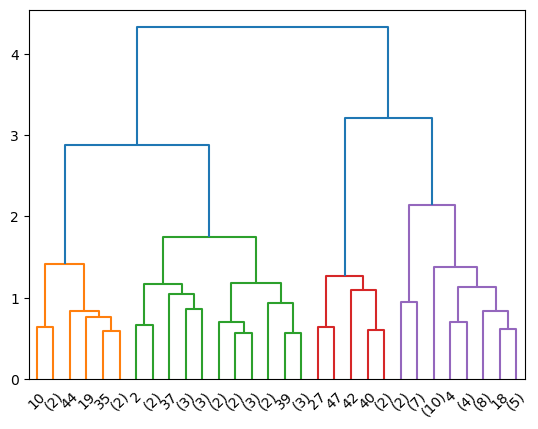

In [9]:
data_dist = pdist(vendor_norm, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
res = dendrogram(data_link, color_threshold=2.5, truncate_mode='lastp')

The hierarchical clustering (using the Ward method) suggests that the optimal number of clusters for this dataset is 4.

### K-means

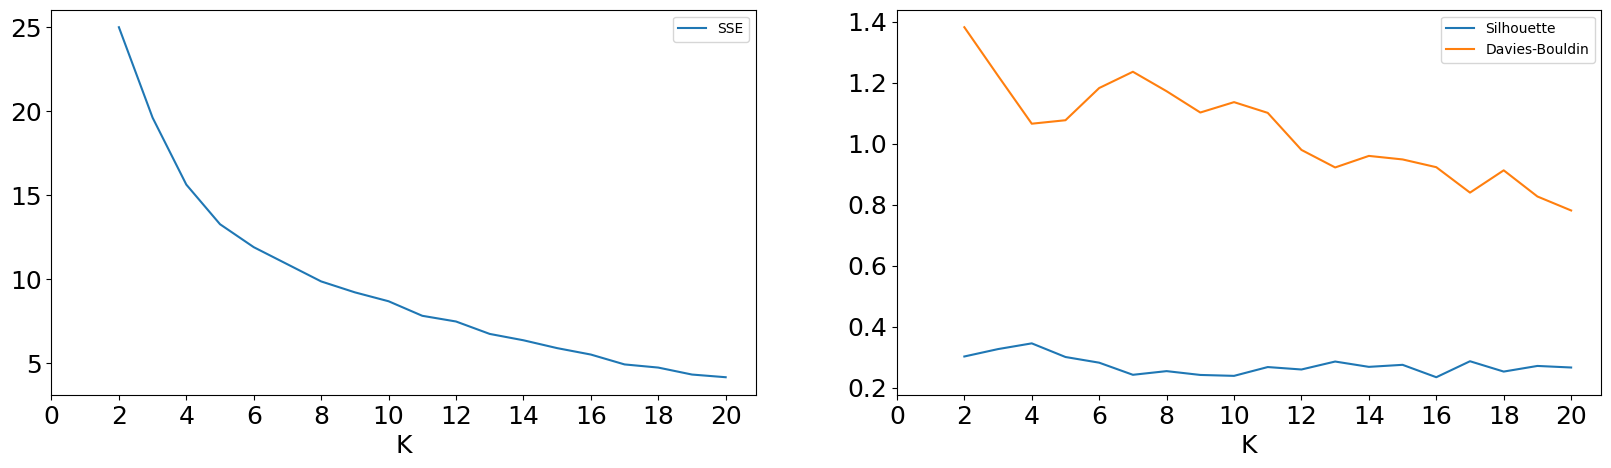

In [10]:
#The number of n_clusters is just for init purpouses
plot_metrics_per_k(vendor_norm, ["sil", "db", "sse"], model_sk=KMeans(n_clusters=1, n_init=20, max_iter=100))

The metrics plotted and the knee method seem to suggest an optimal value for some value of k in the range [2,5].  
We will explore the outcome of these values.

              Num. clusters               Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                                     
0                         2                     [{0: 25, 1: 50}]                       0  24.985524        0.301923       1.381884
1                         3               [{0: 7, 1: 44, 2: 24}]                       0  19.604555        0.326206       1.222483
2                         4        [{0: 18, 1: 38, 2: 13, 3: 6}]                       0  15.571788        0.330955       1.144719
3                         5  [{0: 9, 1: 30, 2: 20, 3: 6, 4: 10}]                       0   13.29226         0.30787       1.055525


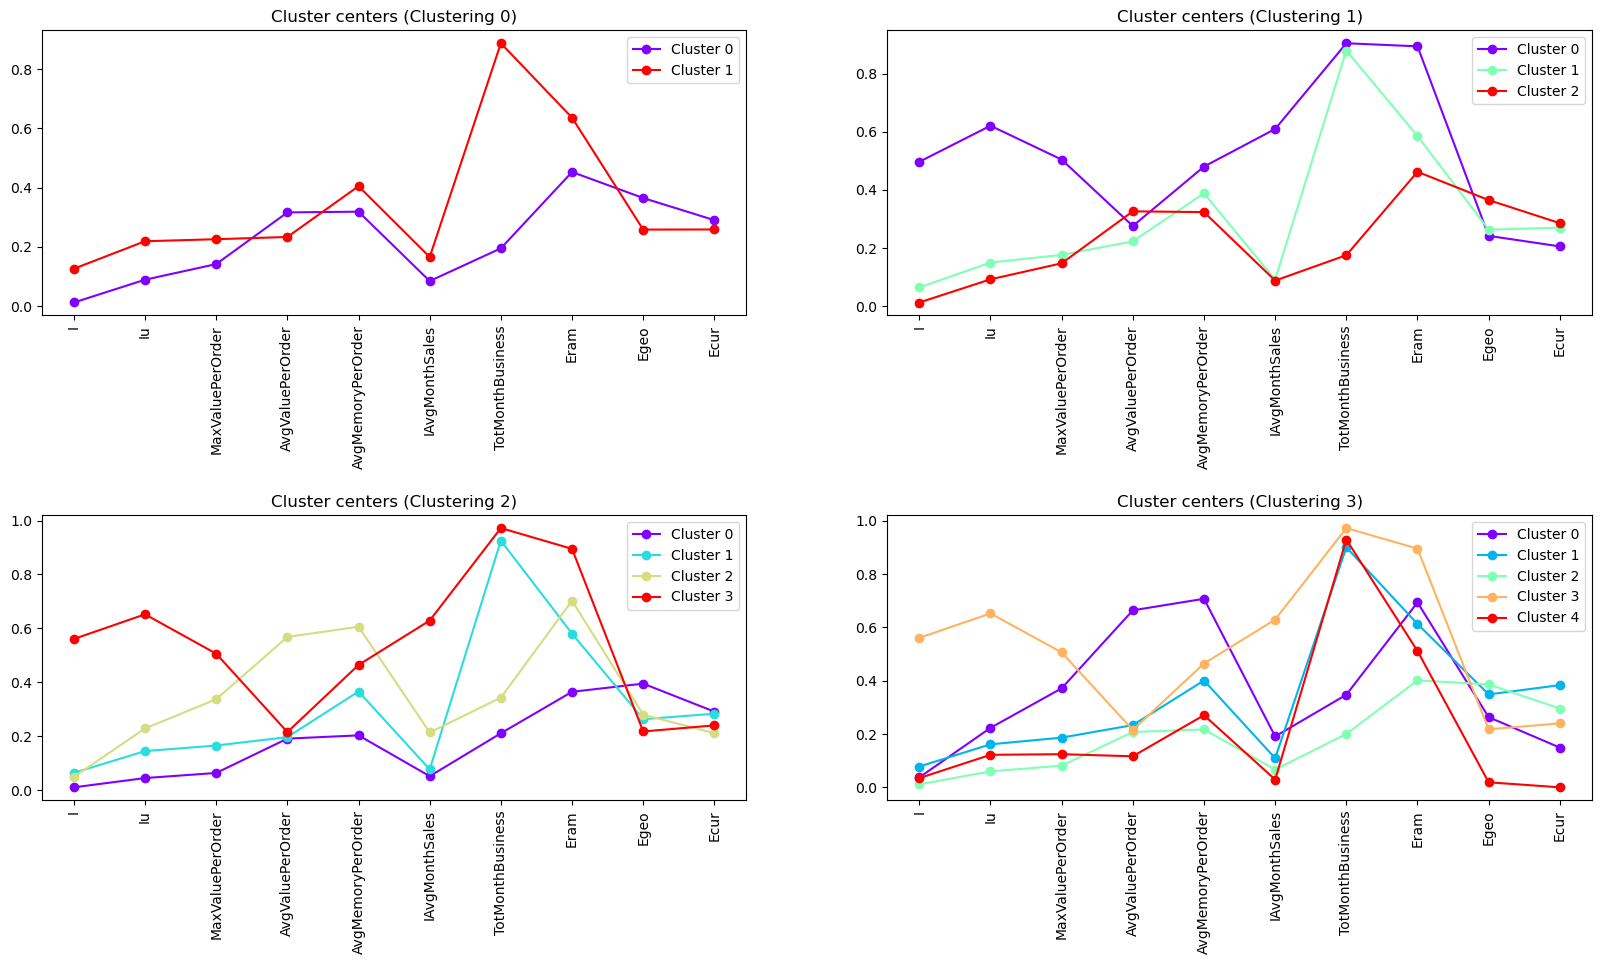

In [11]:
kmeans_clusters = [2,3,4,5]
kmeans_res = []

for i in kmeans_clusters:
    kmeans_res.append(KMeans(n_clusters=i, n_init=20, max_iter=100).fit(vendor_norm))

#Unfortunately it's not possible to make any guarantee that the clusters will have the same colors across clusterings
visualise_model_characteristics([vendor_norm]*len(kmeans_clusters), kmeans_res)

While in the k=3 clustering each label has a strong characterisation in the k=4 one the distinctions become murkier.

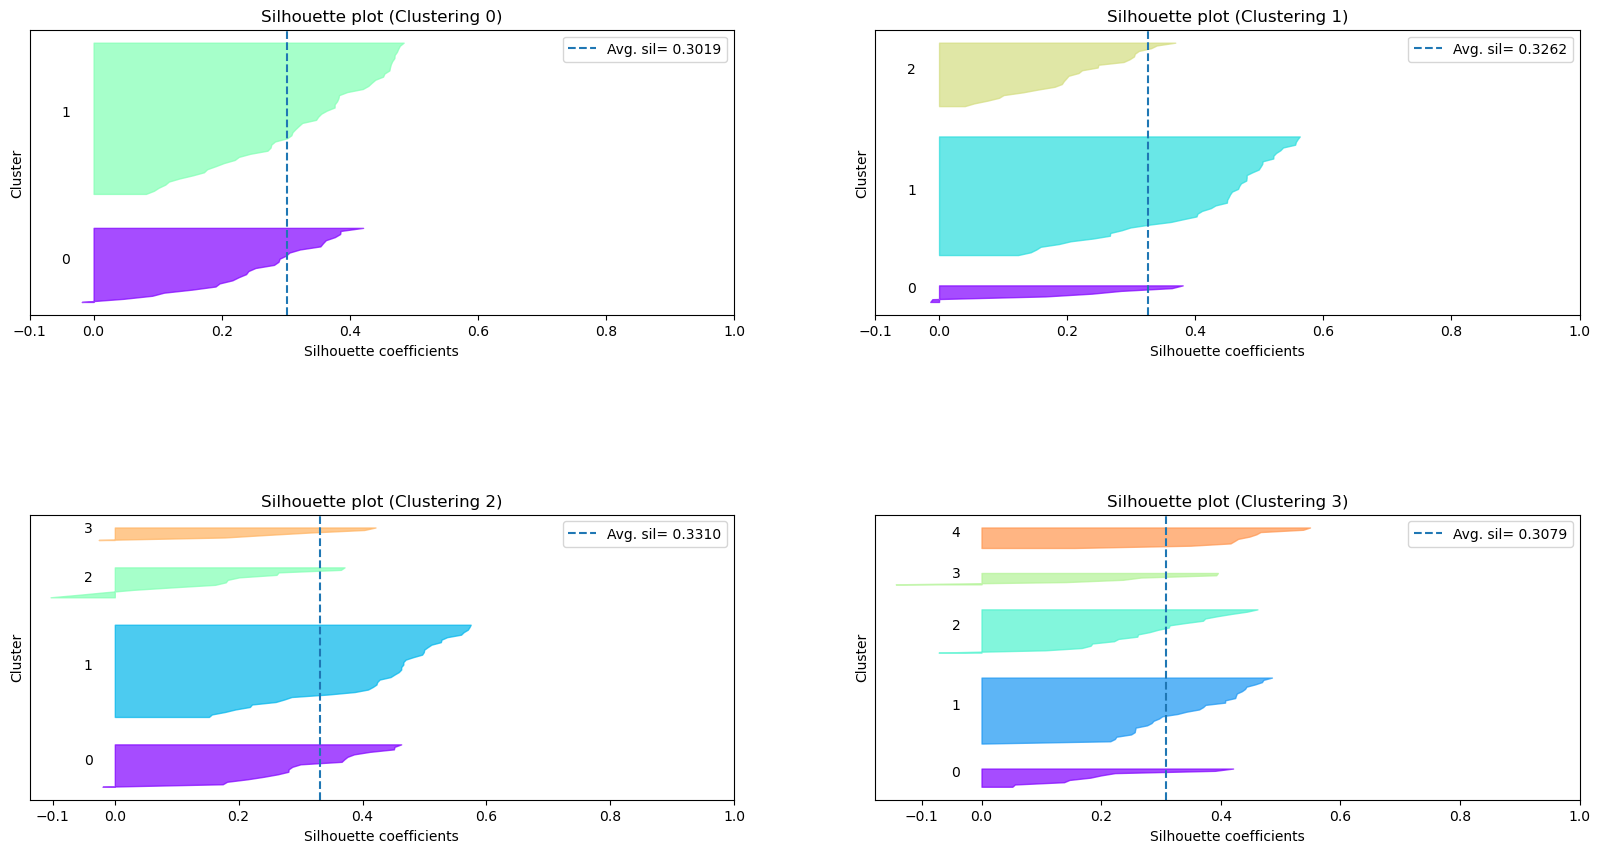

In [13]:
visualise_model_characteristics([vendor_norm]*len(kmeans_clusters), kmeans_res, ["sample_sil"])

When going beyond 3 clusters the number of data points with negative silhouette score increases.

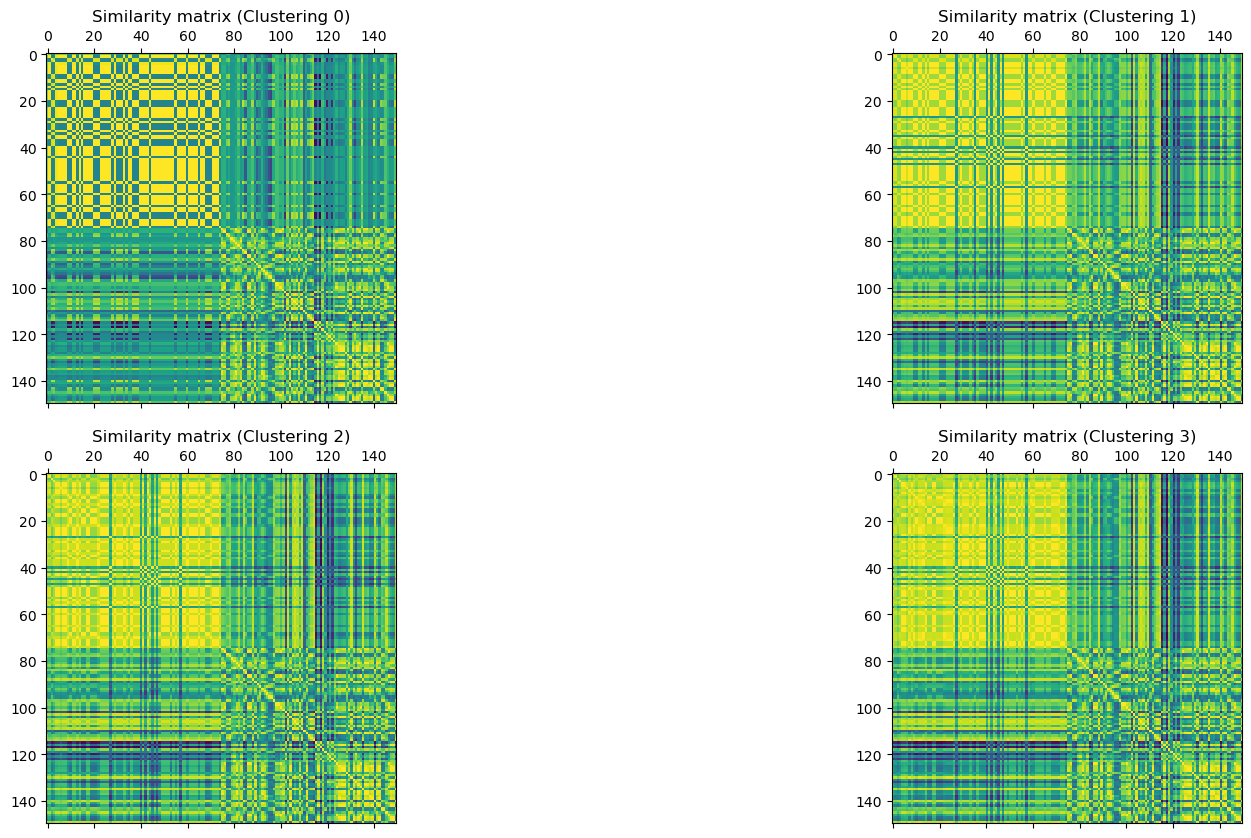

In [14]:
visualise_model_characteristics([vendor_norm]*len(kmeans_clusters), kmeans_res, ["simil_matrix"])

The best results in term of silhouette are from k=3 and k=4, however both present datapoints with a negative score which means that they are closer on average to a different cluster to the one they belong to.  
The similarities matrix don't show any preference between k=2, k=3 and k=4.  

The clustering with k=3 is the most interesting to characterise:
- Cluster 0 presents a high value for I, Iu, TotMonthBusiness and IAvgMonthSales, signifying that it is a long standing, high profit, high volume vendor
- Cluster 1,2 are all characterised by a low sales volume however (I, Iu), cluster 2 vendors are older on average (TotMonthBusiness) and cluster 1 contains vendors are newer  

We can assign each a label: **old-big** (0), **new-small** (1), **old-small** (2) vendors.  

In [15]:
kmeans_final = kmeans_res[1]

#Rough characterisation of the clusters in order to define a stable mapping between the cluster with the desired behaviour and a string label
#Needed because the cluster id could change after each run of the clustering algorithm
old_big_id_kmeans = cluster_id_resolver(vendor_norm, kmeans_final.labels_, \
                                       {"I": ">0.4", "TotMonthBusiness": ">0.6"}, vendor_df_num.columns)
new_small_id_kmeans = cluster_id_resolver(vendor_norm, kmeans_final.labels_, \
                                         {"I": "<0.4", "TotMonthBusiness": "<0.6"}, vendor_df_num.columns)
old_small_id_kmeans = cluster_id_resolver(vendor_norm, kmeans_final.labels_, \
                                         {"I": "<0.4", "TotMonthBusiness": ">0.6"}, vendor_df_num.columns)

cluster_map_kmeans = {old_big_id_kmeans:"old-big", new_small_id_kmeans:"new-small", old_small_id_kmeans:"old-small"}

### External indices

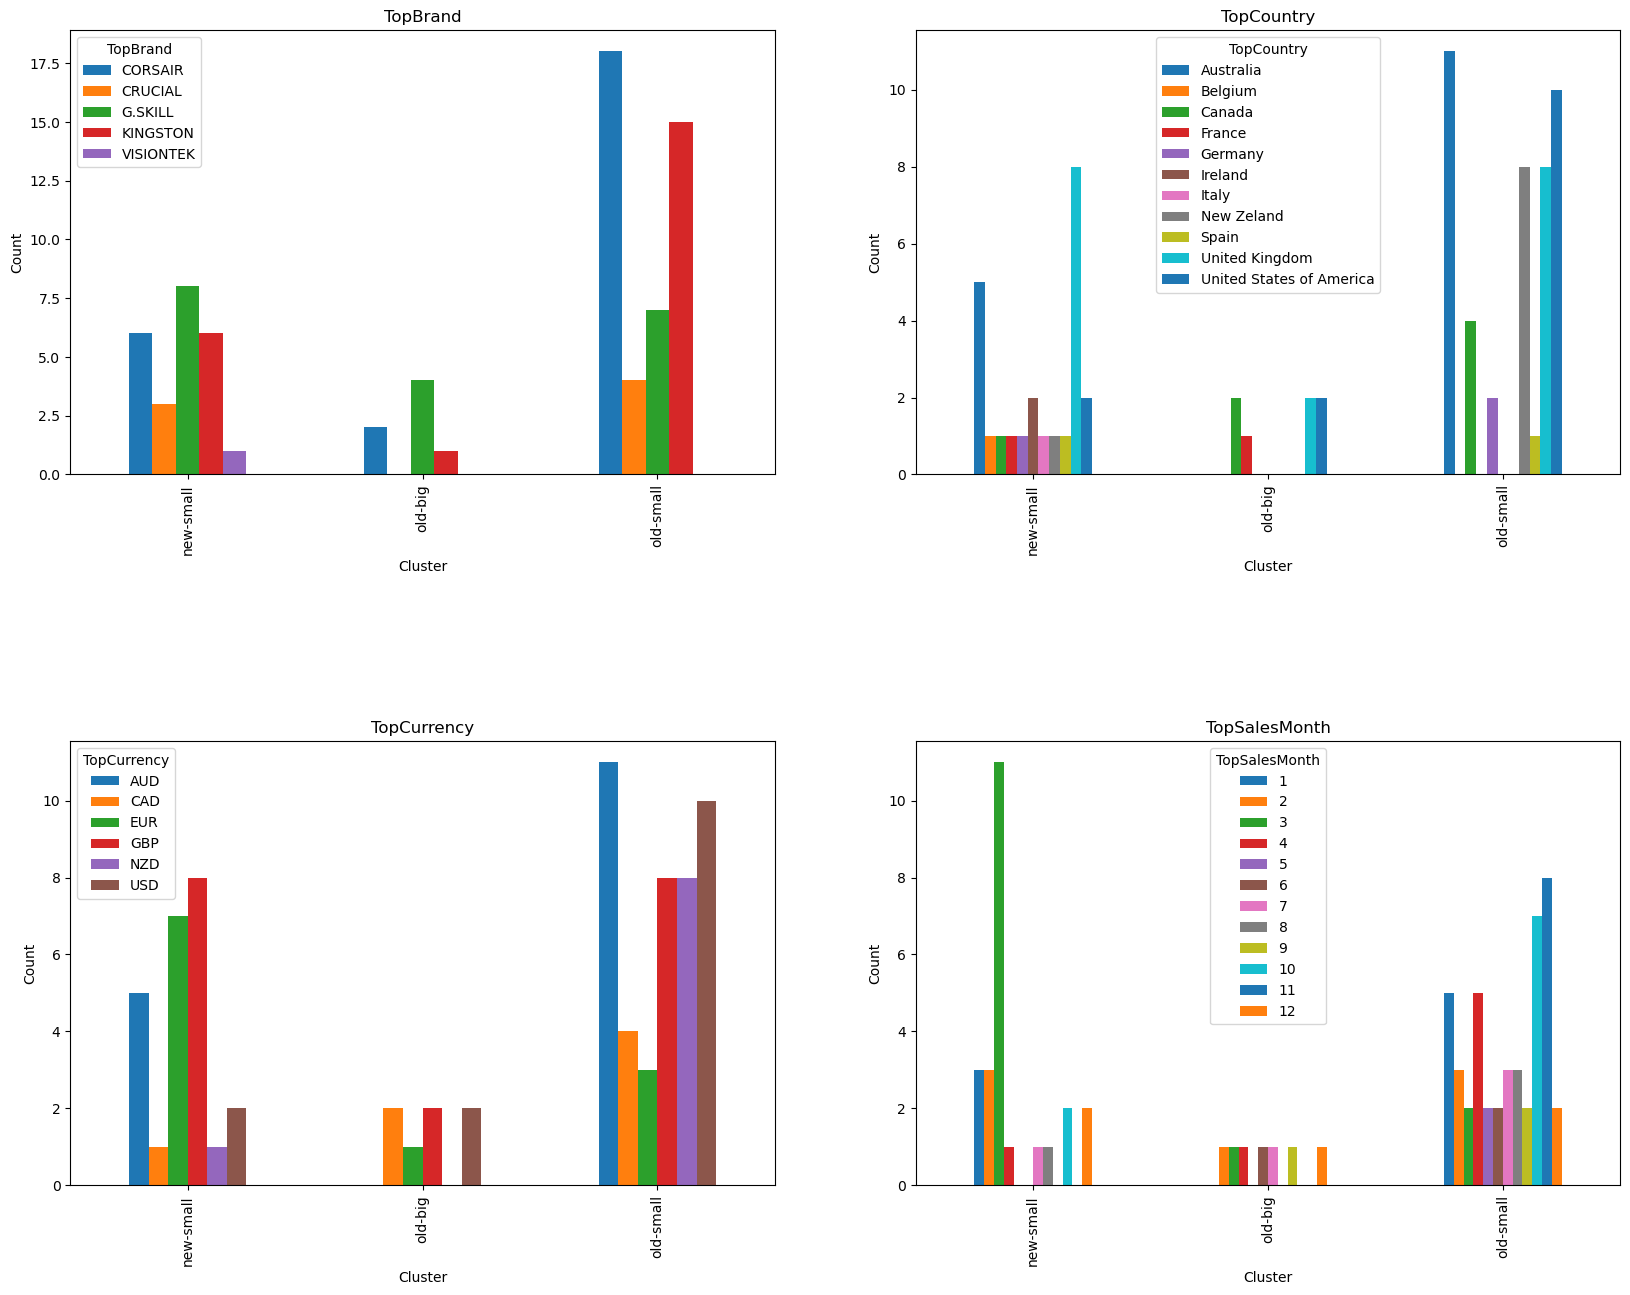

In [16]:
plot_categ_per_cluster(vendor_df_cat, kmeans_final, cluster_map_kmeans)

Some interesting insights on these clusters:  
- The european currencies (EUR, GBP) represent the majority of top currencies for new-small/old-small
- The USD is concentrated mostly in the old-small label
- The vast majority of new-small's sales take place in the month of March
- The vast majority of the vendors are classified as small (as expected)

In [17]:
create_external_indices(vendor_df_cat, kmeans_final)

Feature  Homogeneity  Completeness  Mutual Info
0       TopBrand     0.052312      0.078789     0.062877
1     TopCountry     0.096548      0.214292     0.133119
2    TopCurrency     0.073973      0.143423     0.097604
3  TopSalesMonth     0.110030      0.288831     0.159355

Nothing too remarkable.

## Fuzzy c-means

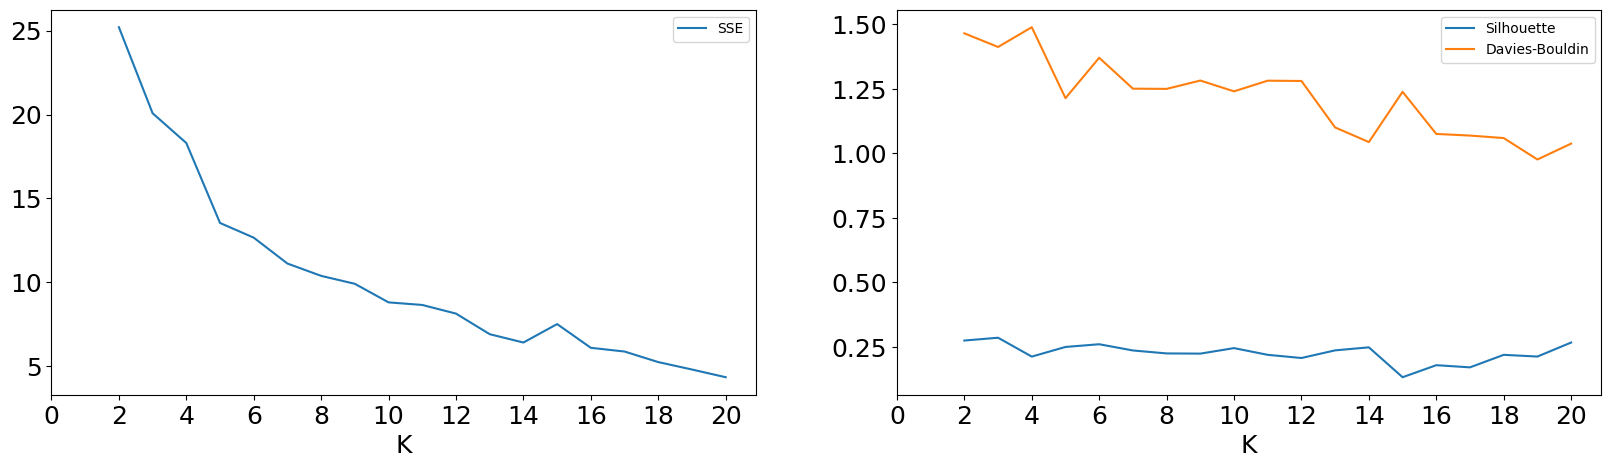

In [18]:
#Might take a bunch of seconds
plot_metrics_per_k(vendor_norm, ["sse", "sil", "db"], model_sk=fcm_sk(n_clusters=1, max_iter=100))

              Num. clusters                Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                                      
0                         2                      [{0: 44, 1: 31}]                       0  25.207743        0.274823       1.464526
1                         3               [{0: 35, 1: 19, 2: 21}]                       0  20.075618        0.285702       1.411721
2                         4        [{0: 21, 1: 23, 2: 19, 3: 12}]                       0   17.58426        0.222916       1.387027
3                         5  [{0: 17, 1: 17, 2: 12, 3: 7, 4: 22}]                       0  13.713964        0.247929       1.234334


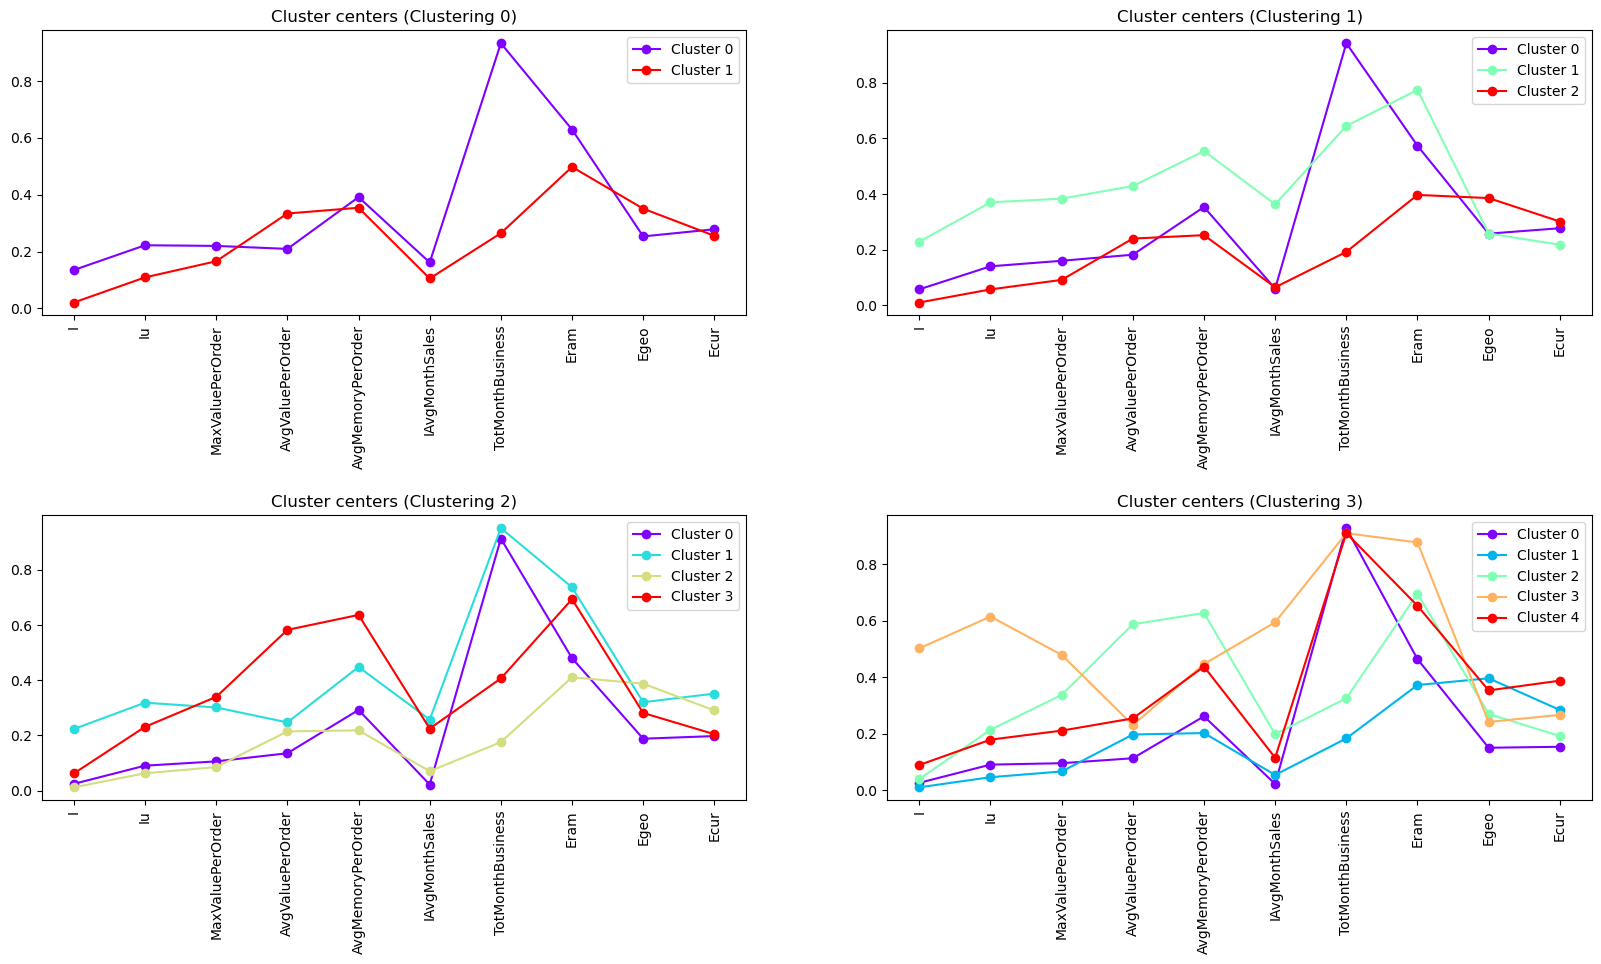

In [19]:
fcm_clusters = [2,3,4,5]
fcm_res = []

for i in fcm_clusters:
    fcm_res.append(fcm_sk(n_clusters=i, max_iter=100).fit(vendor_norm))

#We only use the labels from the clustering, the datapoints are from the normalised dataset
visualise_model_characteristics([vendor_norm]*len(fcm_clusters), fcm_res)

This time the clusters are much more similar in clustering 1 onwards.

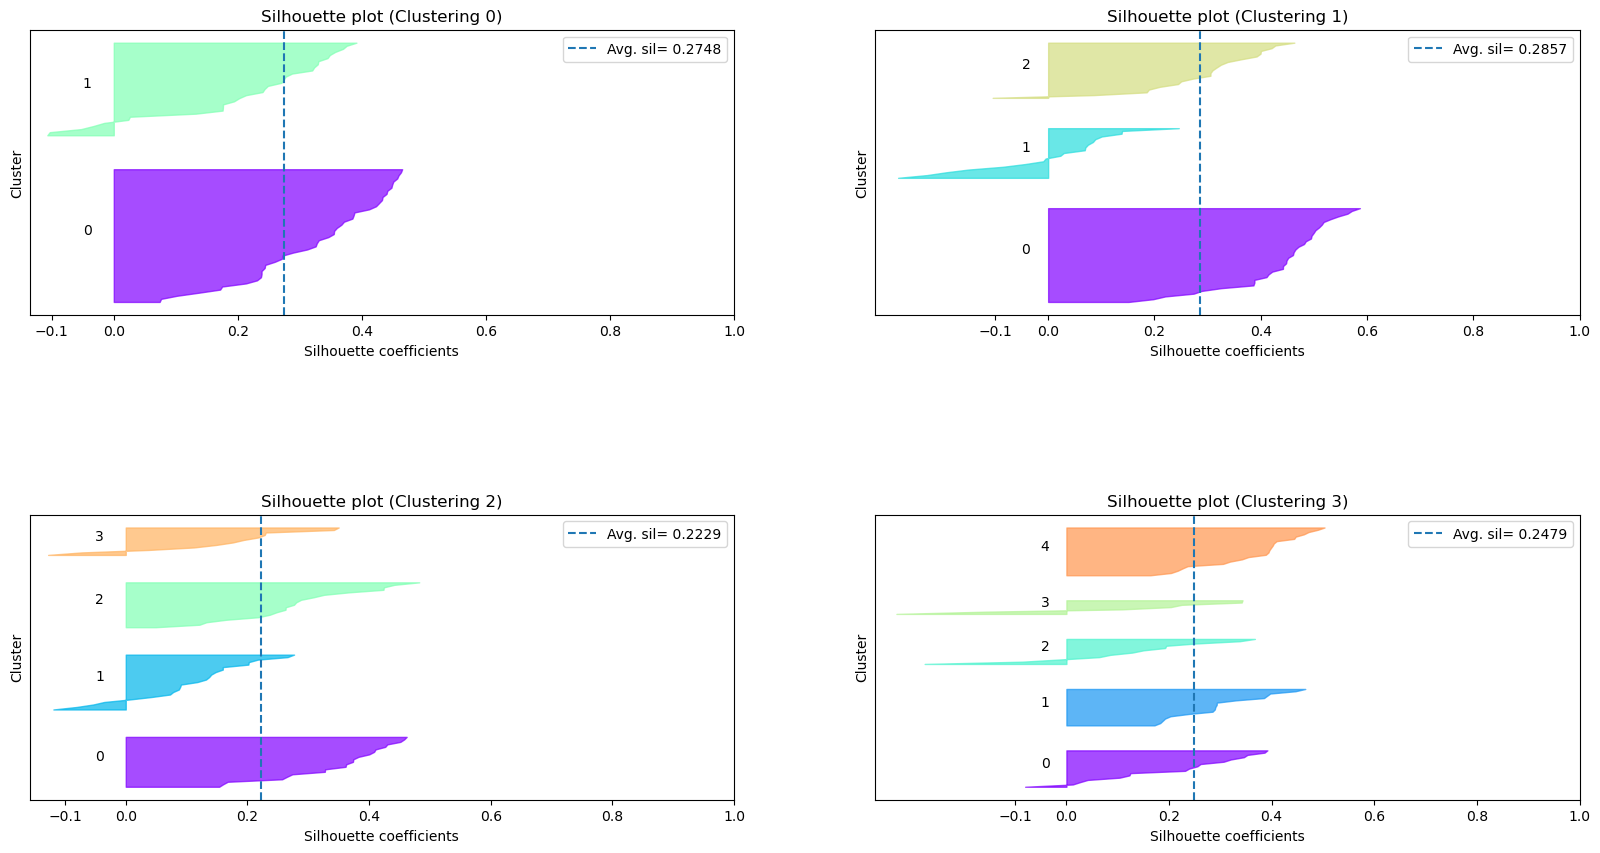

In [20]:
visualise_model_characteristics([vendor_norm]*len(fcm_clusters), fcm_res, ["sample_sil"])

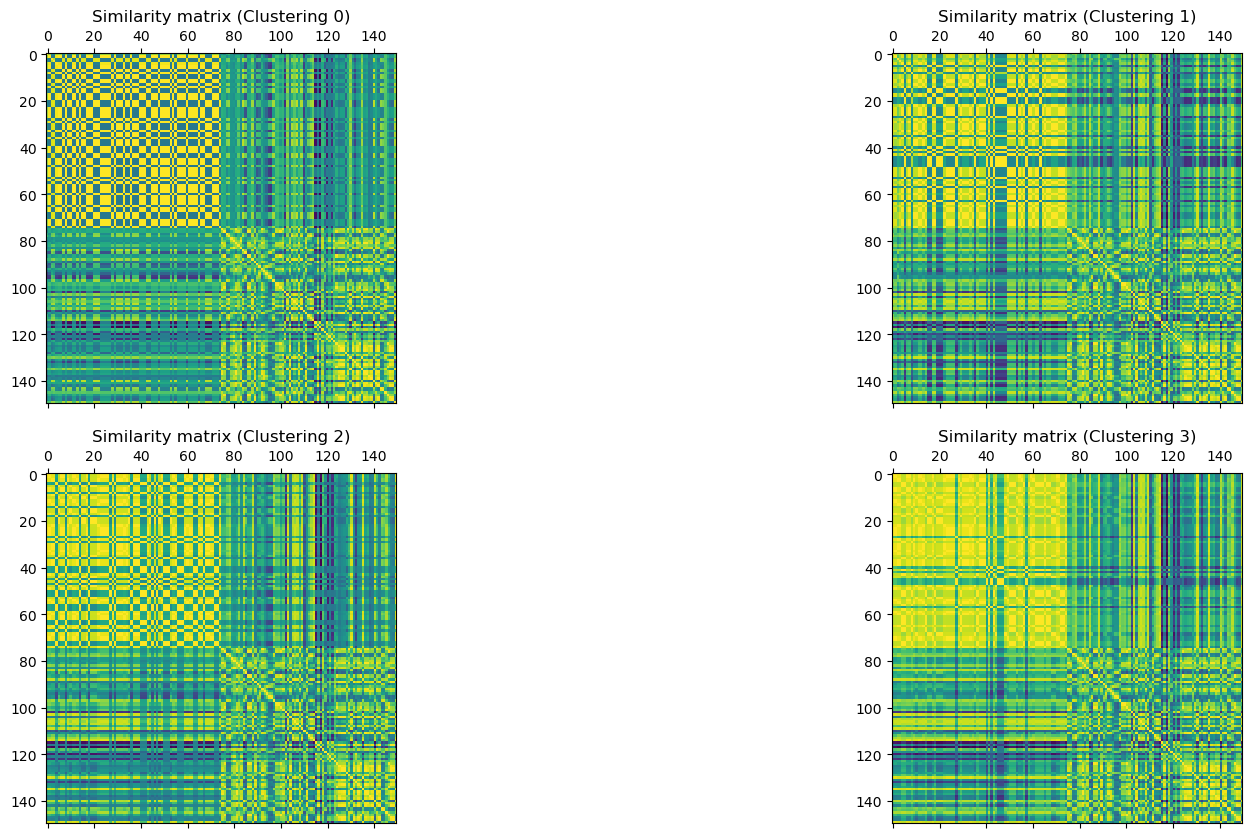

In [21]:
visualise_model_characteristics([vendor_norm]*len(kmeans_clusters), fcm_res, ["simil_matrix"])

The results here are worse compared to K-means, the average silhouette score is lower and there are more data points with a negative score at the silhouette sample level across the board, the highest score is the one for clustering 1.  
The similarity matrix suggests a higher compactness for the clustering 3, however it seems that the data points are too fragmented among clusters to be able to meaningfully interpret the results.  

For these reasons we decide to stick with clustering 1, which has also the benefit of sharing the labels with the results from K-means.  

In [22]:
cmeans_final = fcm_res[1]

#Rough characterisation of the clusters in order to define a stable mapping between the cluster with the desired behaviour and a string label
#Needed because the cluster id could change after each run of the clustering algorithm
old_big_id_cmeans = cluster_id_resolver(vendor_norm, cmeans_final.labels_, \
                                       {"I": ">=0.2", "TotMonthBusiness": ">0.4"}, vendor_df_num.columns)
new_small_id_cmeans = cluster_id_resolver(vendor_norm, cmeans_final.labels_, \
                                         {"I": "<0.2", "TotMonthBusiness": "<0.4"}, vendor_df_num.columns)
old_small_id_cmeans = cluster_id_resolver(vendor_norm, cmeans_final.labels_, \
                                         {"I": "<0.2", "TotMonthBusiness": ">0.4"}, vendor_df_num.columns)

cluster_map_cmeans = {old_big_id_cmeans:"old-big", new_small_id_cmeans:"new-small", old_small_id_cmeans:"old-small"}

### External indices

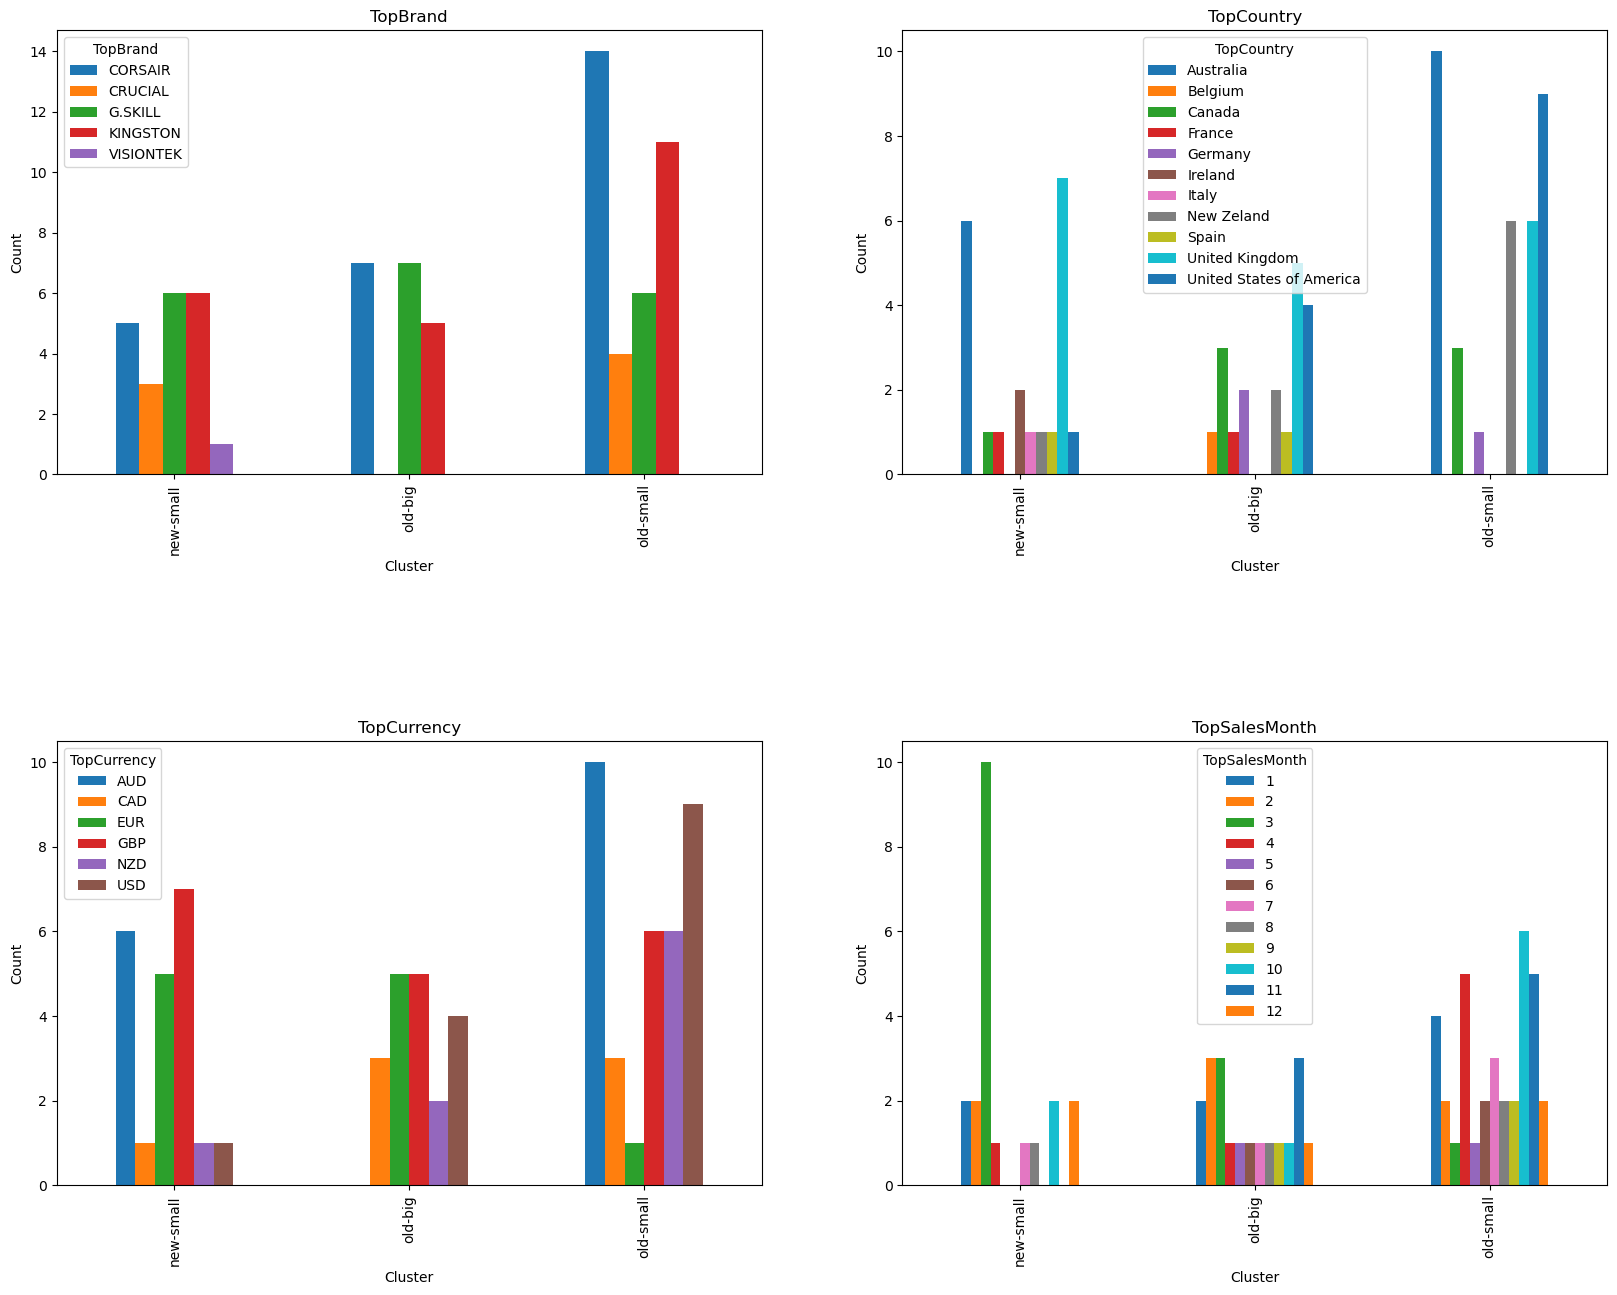

In [23]:
plot_categ_per_cluster(vendor_df_cat, cmeans_final, cluster_map_cmeans)

In [24]:
create_external_indices(vendor_df_cat, cmeans_final)

Feature  Homogeneity  Completeness  Mutual Info
0       TopBrand     0.048944      0.062512     0.054902
1     TopCountry     0.122479      0.230529     0.159967
2    TopCurrency     0.097362      0.160080     0.121082
3  TopSalesMonth     0.085355      0.190002     0.117793

## Protype-based evaluation

### K-means vs C-means

#### Internal indices

              Num. clusters   Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                         
0                         3   [{0: 7, 1: 44, 2: 24}]                       0  19.604555        0.326206       1.222483
1                         3  [{0: 35, 1: 19, 2: 21}]                       0  20.075618        0.285702       1.411721


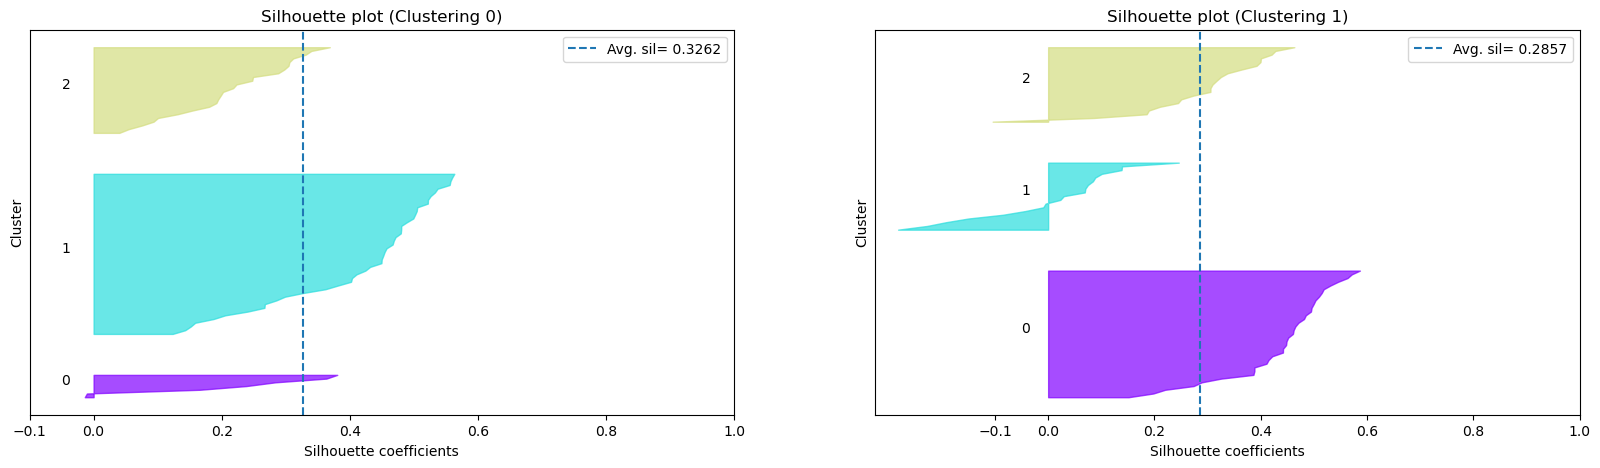

In [25]:
visualise_model_characteristics([vendor_norm, vendor_norm], [kmeans_final, cmeans_final], ["general", "sample_sil"])

We can see that c-means internal metrics are generally worse, in particular it produces clusters containing more datapoints with a negative sample silhouette score.

#### External indices

In [26]:
create_external_indices(vendor_df_cat, kmeans_final)

Feature  Homogeneity  Completeness  Mutual Info
0       TopBrand     0.052312      0.078789     0.062877
1     TopCountry     0.096548      0.214292     0.133119
2    TopCurrency     0.073973      0.143423     0.097604
3  TopSalesMonth     0.110030      0.288831     0.159355

In [27]:
create_external_indices(vendor_df_cat, cmeans_final)

Feature  Homogeneity  Completeness  Mutual Info
0       TopBrand     0.048944      0.062512     0.054902
1     TopCountry     0.122479      0.230529     0.159967
2    TopCurrency     0.097362      0.160080     0.121082
3  TopSalesMonth     0.085355      0.190002     0.117793

The results are very similar between the two clusterings.

### Conclusions

The results obtained from these techniques are very similar and the characterisations share some insights, k-means however has an edge in internal metrics.

## Task 2.2: Density-based clustering

### Determine optimal eps and minSamples

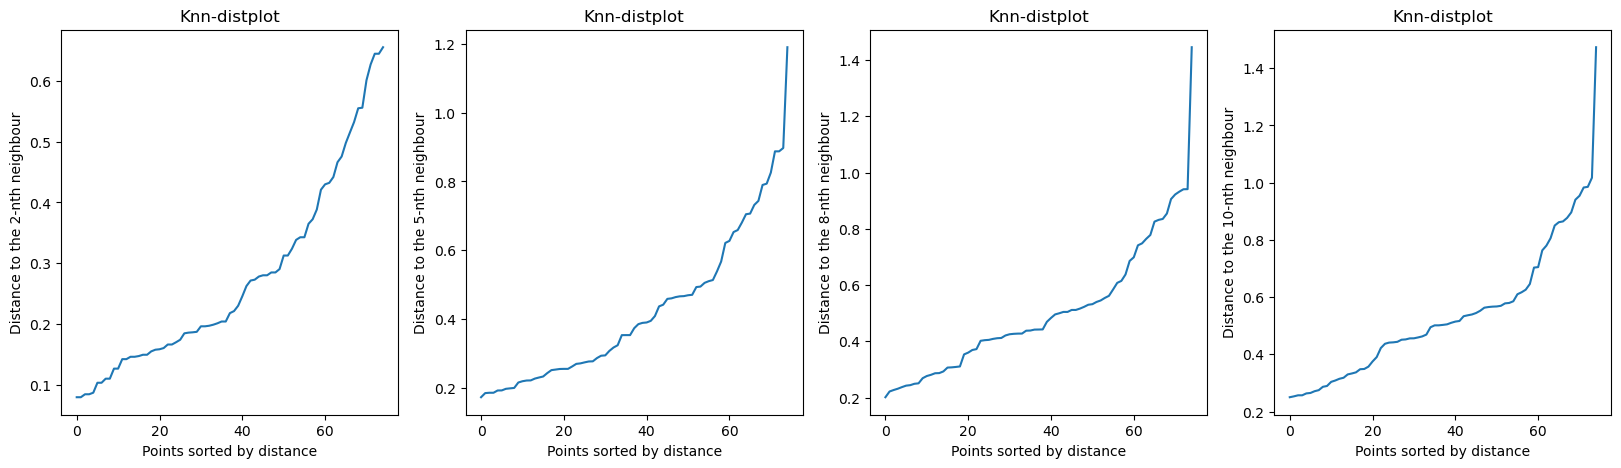

In [28]:
n_neigh = [2, 5, 8, 10]
plot_knn_dist(n_neigh, [vendor_norm]*len(n_neigh))

The "knee" in this case is not really smooth, due to the low number of datapoints in the dataset, making it harder to find an optimal value for minSamples.  
The plots suggest that an optimal value for the eps parameter is in the range [0.2, 0.8] for the minSamples values considered.  

Given the low amount of data points and the lack of significant change in the plot we will settle for a minSamples value of 5.

### DBSCAN

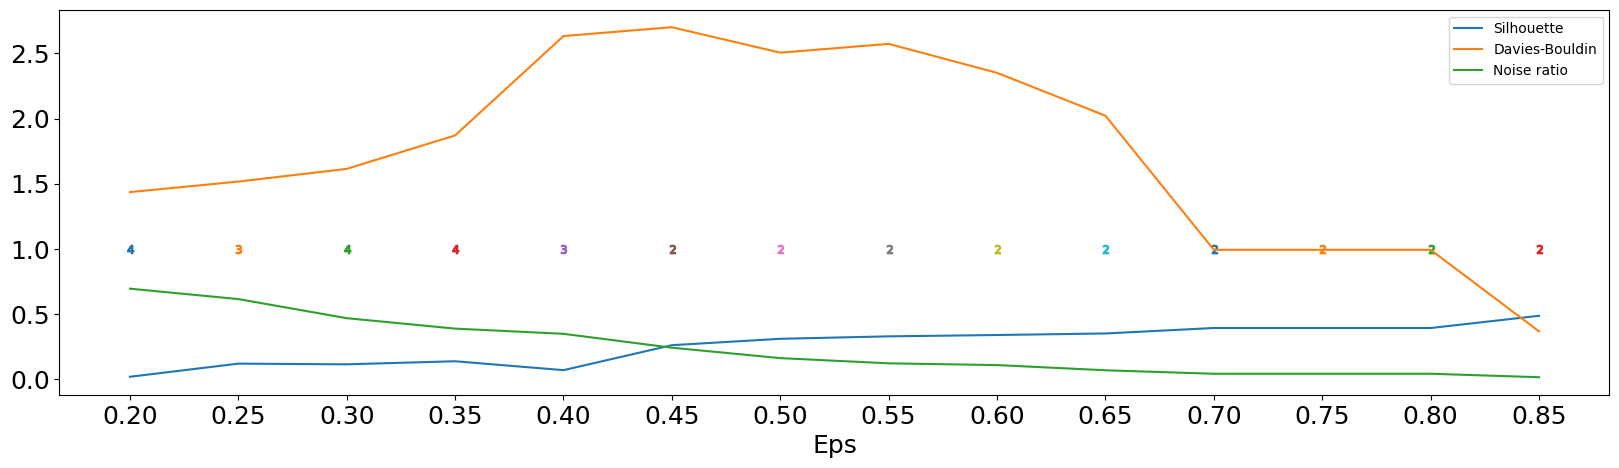

In [29]:
plot_metrics_per_eps(vendor_norm, ["sil", "db", "noise_ratio", "clusters"], precision=0.05, model_sk=DBSCAN(min_samples = 5, eps = 1))

Apart from the usual metrics we also introduced a simple ratio of noise datapoints to non-noise ones and the number of clusters per eps change, just to get an idea of the behaviour of the DBSCAN algorithm.

              Num. clusters   Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                         
0                         3  [{-1: 26, 0: 41, 1: 8}]                       0   29.75732        0.067679       2.633271
1                         2        [{-1: 12, 0: 63}]                       0  31.164668        0.308345        2.50549
2                         2         [{-1: 8, 0: 67}]                       0  31.653632        0.337526       2.350626
3                         2         [{-1: 3, 0: 72}]                       0  30.620601        0.391204       0.991674


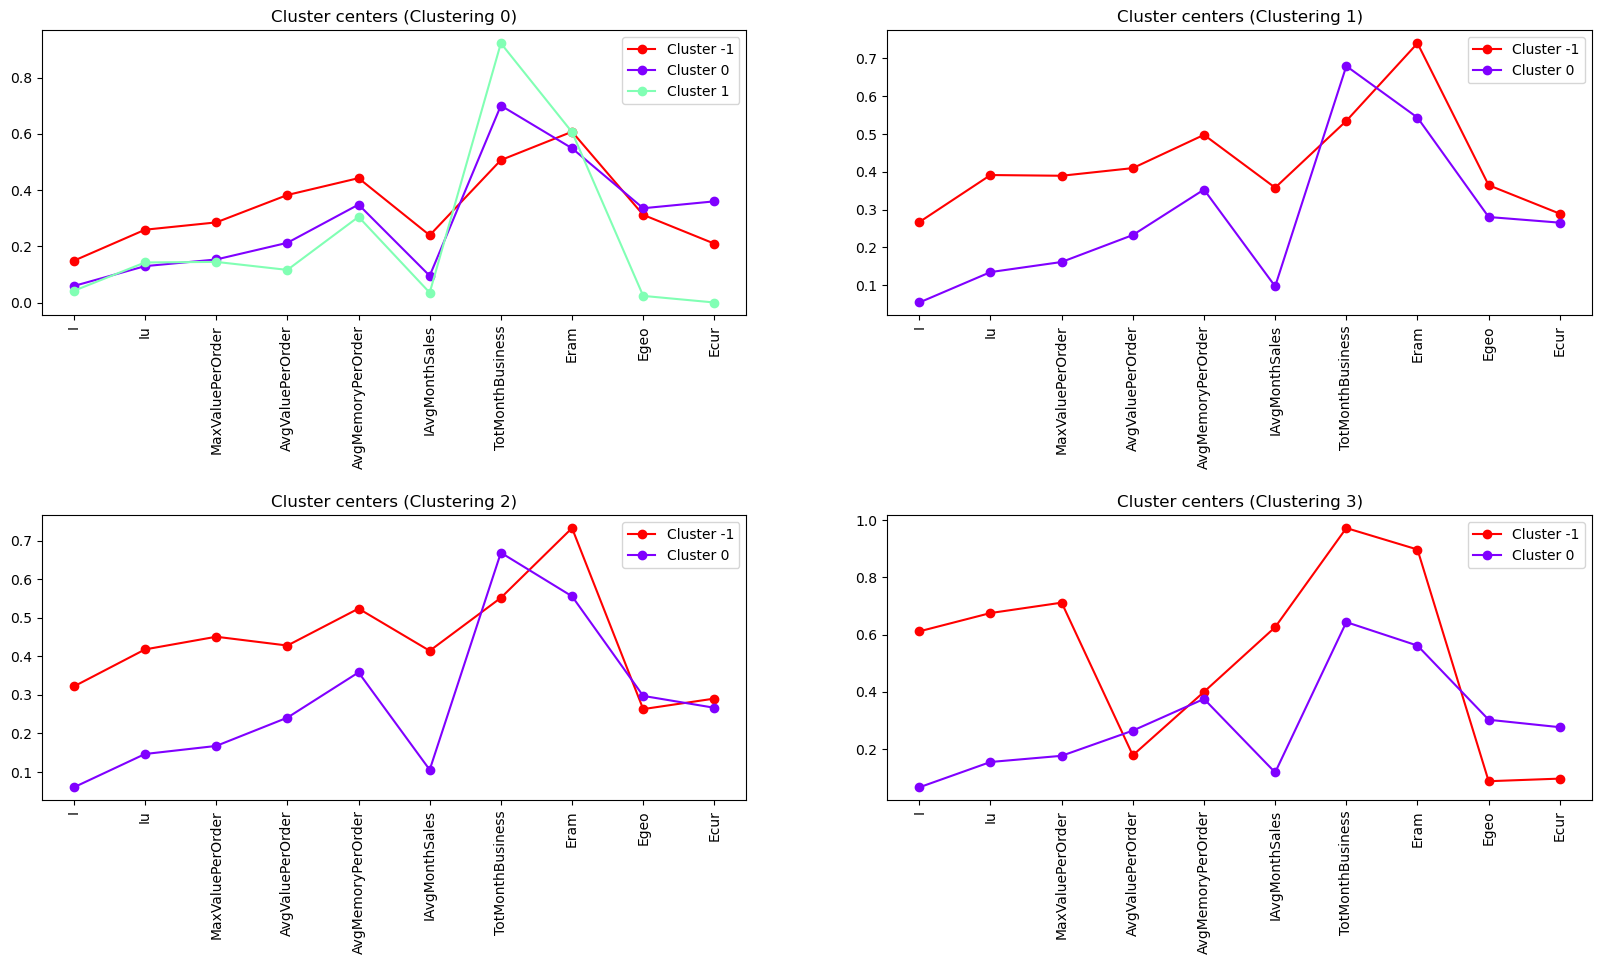

In [30]:
dbscan_res = []

for i in np.arange(0.4, 0.8, 0.10):
    dbscan_res.append(DBSCAN(min_samples = 5, eps = i).fit(vendor_norm))

visualise_model_characteristics([vendor_norm]*len(dbscan_res), dbscan_res)

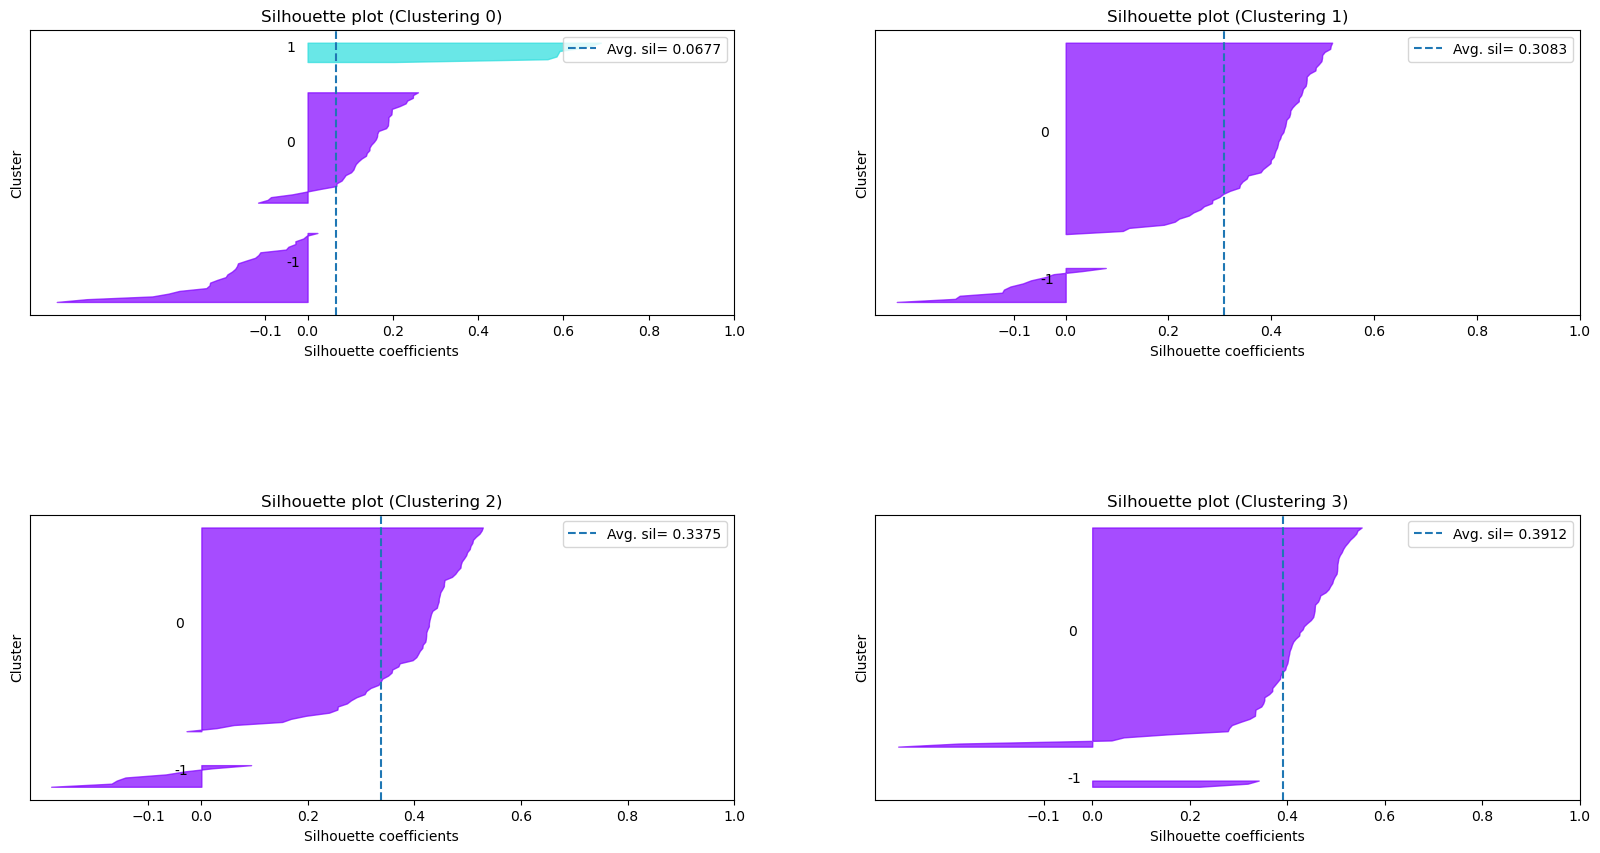

In [31]:
visualise_model_characteristics([vendor_norm]*len(dbscan_res), dbscan_res, ["sample_sil"])

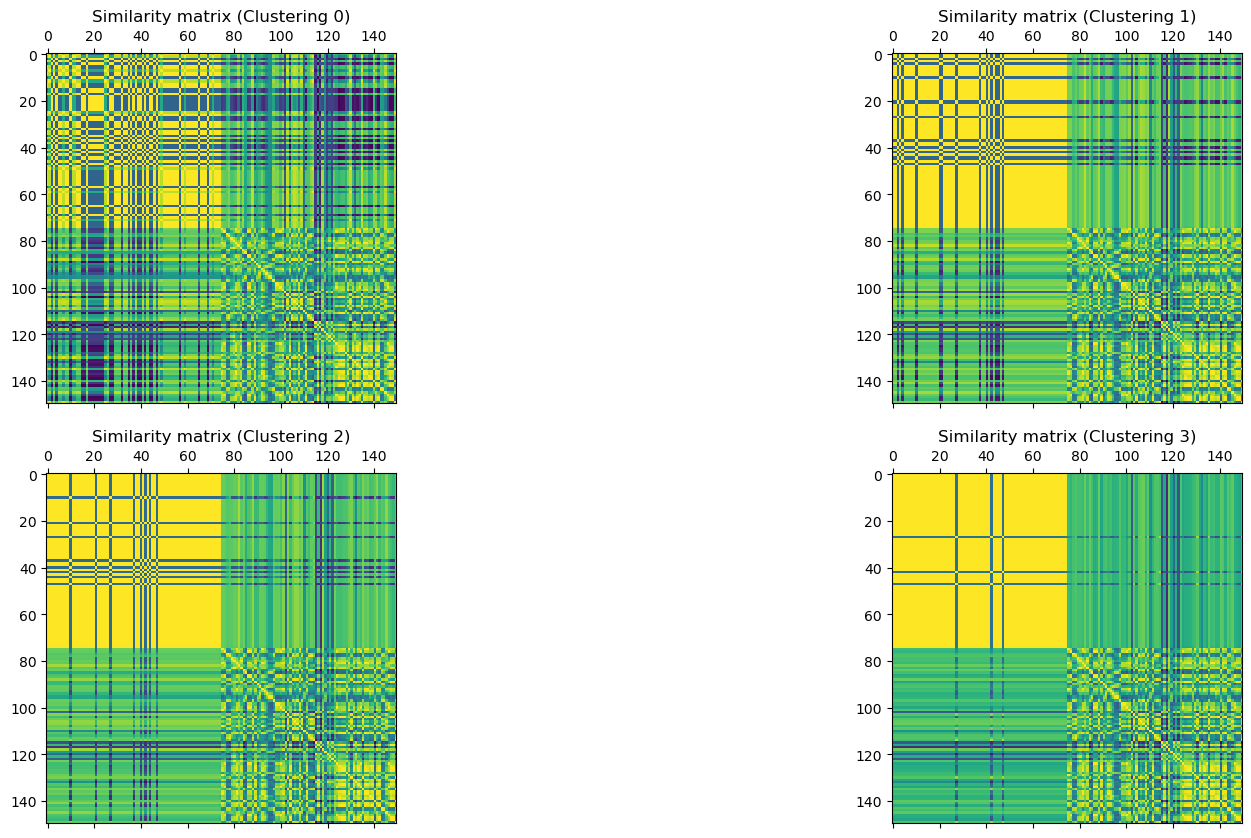

In [32]:
visualise_model_characteristics([vendor_norm]*len(kmeans_clusters), dbscan_res, ["simil_matrix"])

We chose the 2nd clustering because the clusters are distinct enough (difference between the averages of the characterising features ~0.2)  and because it has an higher number of points in the noise cluster while the overall behaviour of the plot is very similar to the 3rd clustering.  
The 1st clustering wasn't considered due to the comparatively poor silhouette score.  

Here we can see a simpler characterisation compared to prototype-based clustering, we can assign labels based on the sales (IAvgSalesMonth) and volume of sales (I/Iu) based on the 2nd clustering: **big** (0) and **small** (1) vendors.

In [33]:
dbscan_final = dbscan_res[1]

cluster_map_dbscan = {-1:"big", 0:"small"}

### External indices

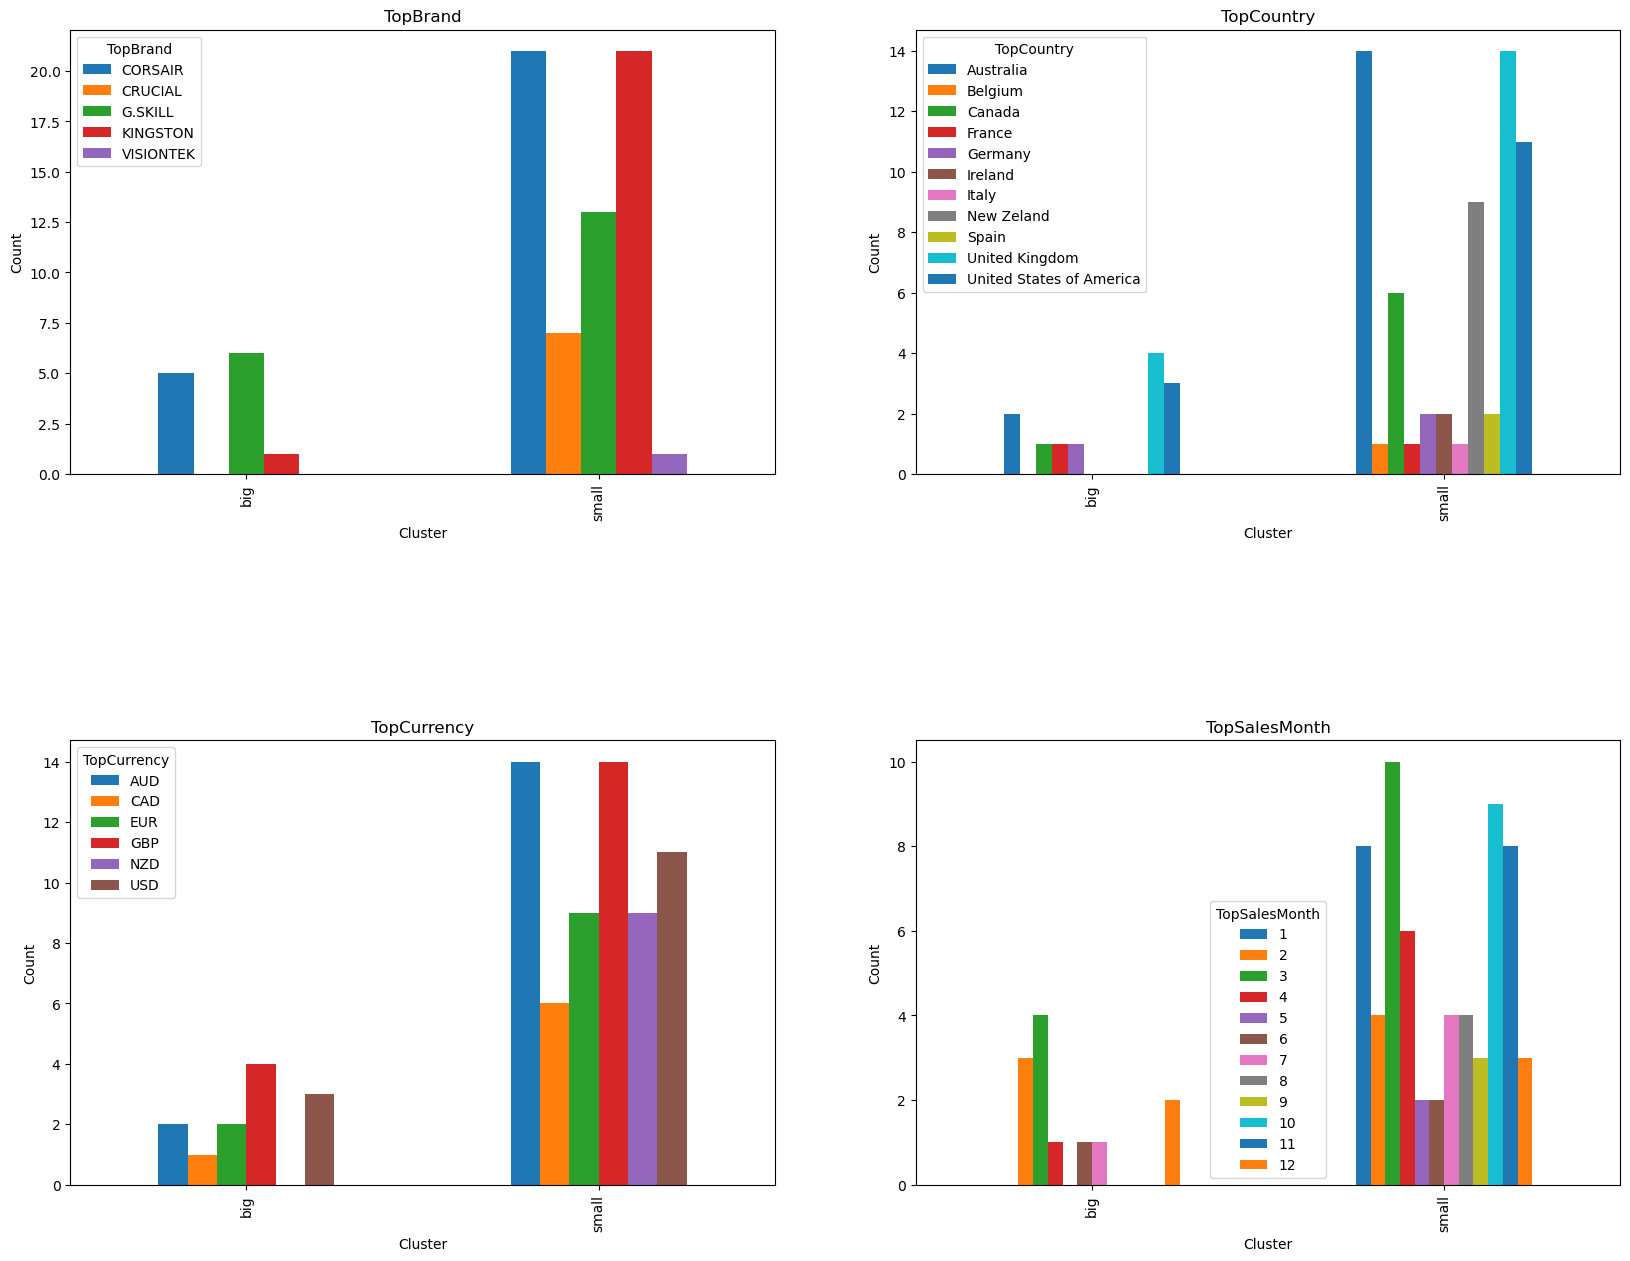

In [34]:
plot_categ_per_cluster(vendor_df_cat, dbscan_final, cluster_map_dbscan)

Insights:
- Crucial is not a top grossing brand for big vendors
- Big vendors seem to have the majority of their profits in the months of February and March
- New Zealand is not a top grossing country for any big vendor, which is to be expected given the size of the country's economy compared to the others

In [35]:
create_external_indices(vendor_df_cat, dbscan_final)

Feature  Homogeneity  Completeness  Mutual Info
0       TopBrand     0.042641      0.131295     0.064375
1     TopCountry     0.026543      0.120437     0.043499
2    TopCurrency     0.015698      0.062221     0.025070
3  TopSalesMonth     0.051830      0.278138     0.087377

### Conclusions
DBSCAN clusterings aren't too promising according to the internal metrics.  
Later we will compare the results in this section with the other clusterings obtained with different algorithms.

## Task 2.3: Hierarchical clustering (Agglomerative)

## Single linkage

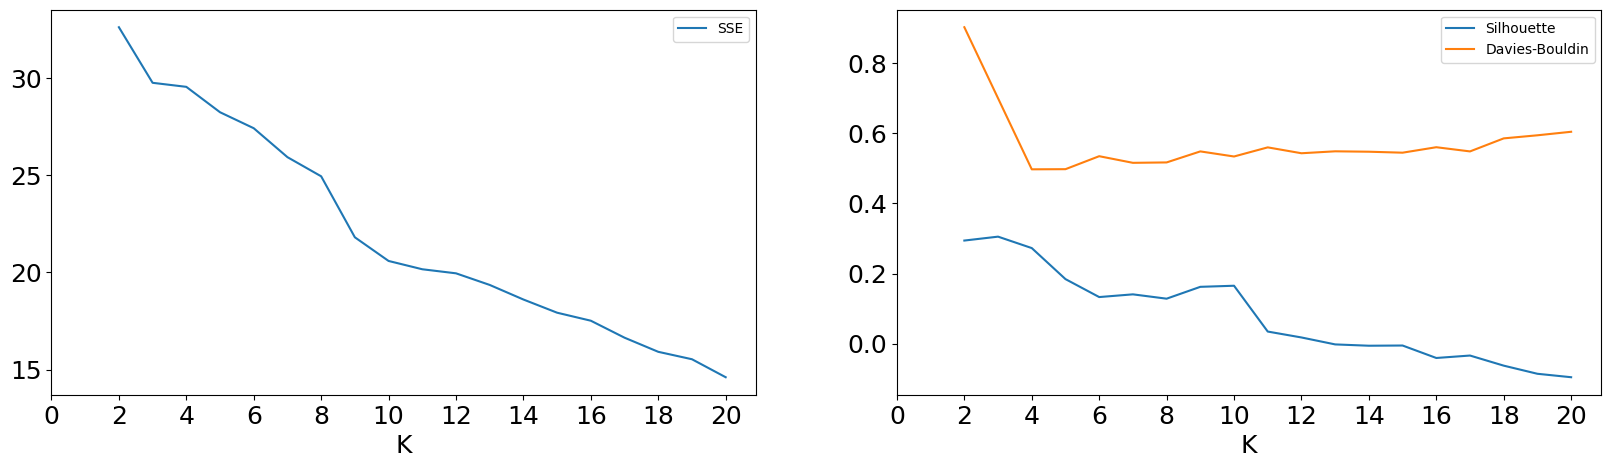

In [36]:
plot_metrics_per_k(vendor_norm, ["sse", "sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="single"))

Cophenetic coefficient: 0.6766931839188972


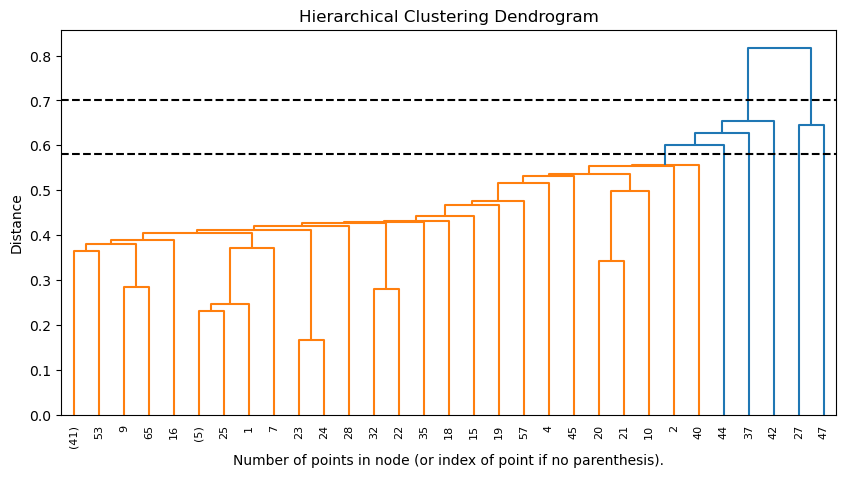

              Num. clusters                   Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                                         
0                         2                          [{0: 73, 1: 2}]                       0  32.608542         0.29414       0.903062
1                         6  [{0: 70, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1}]                       5  27.415358        0.132836       0.534907


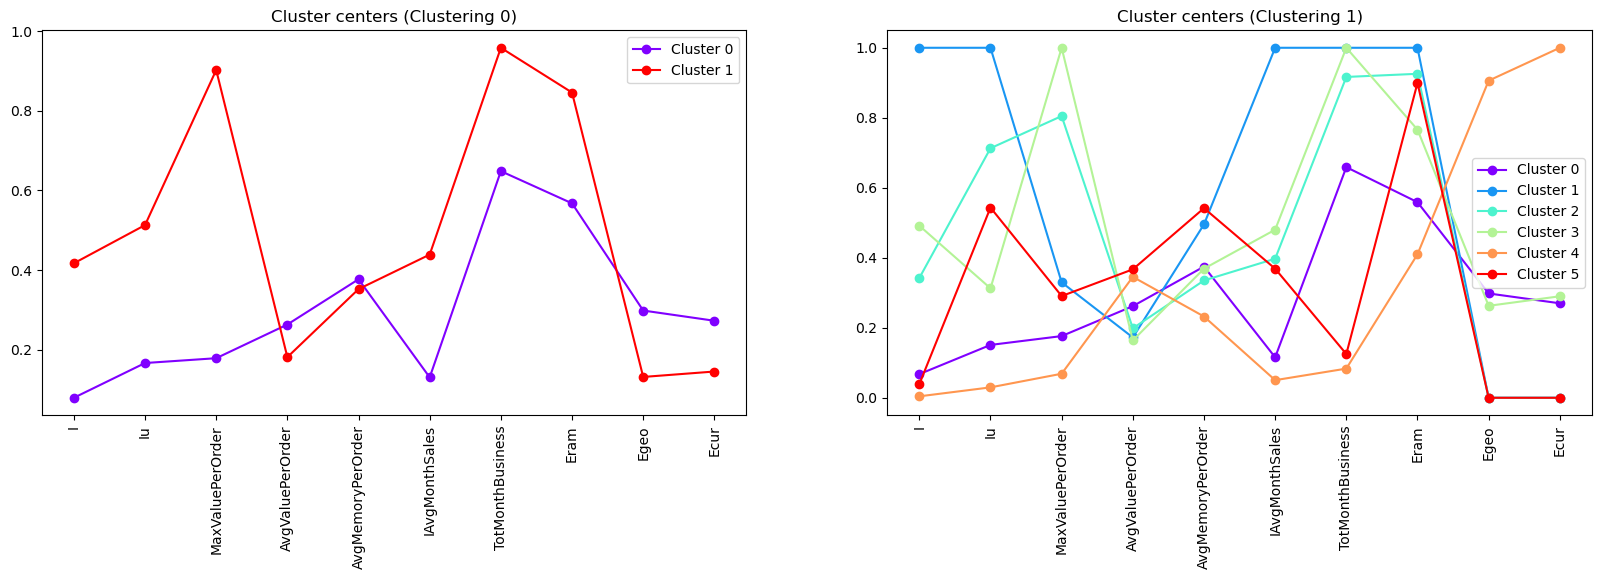

In [37]:
max_d = [0.7, 0.58]

hier_clustering_single_res = []

for i in max_d:
    hier_clustering_single_res.append(AgglomerativeClustering(distance_threshold=i, n_clusters=None, linkage="single").fit(vendor_norm))

Z = linkage(vendor_norm, 'single')
c, coph_dists = cophenet(Z, pdist(vendor_norm))
print(f"Cophenetic coefficient: {c}")

plot_dendrogram(hier_clustering_single_res[0], max_d, truncate_mode='level', p=20)
visualise_model_characteristics([vendor_norm]*len(hier_clustering_single_res), hier_clustering_single_res)

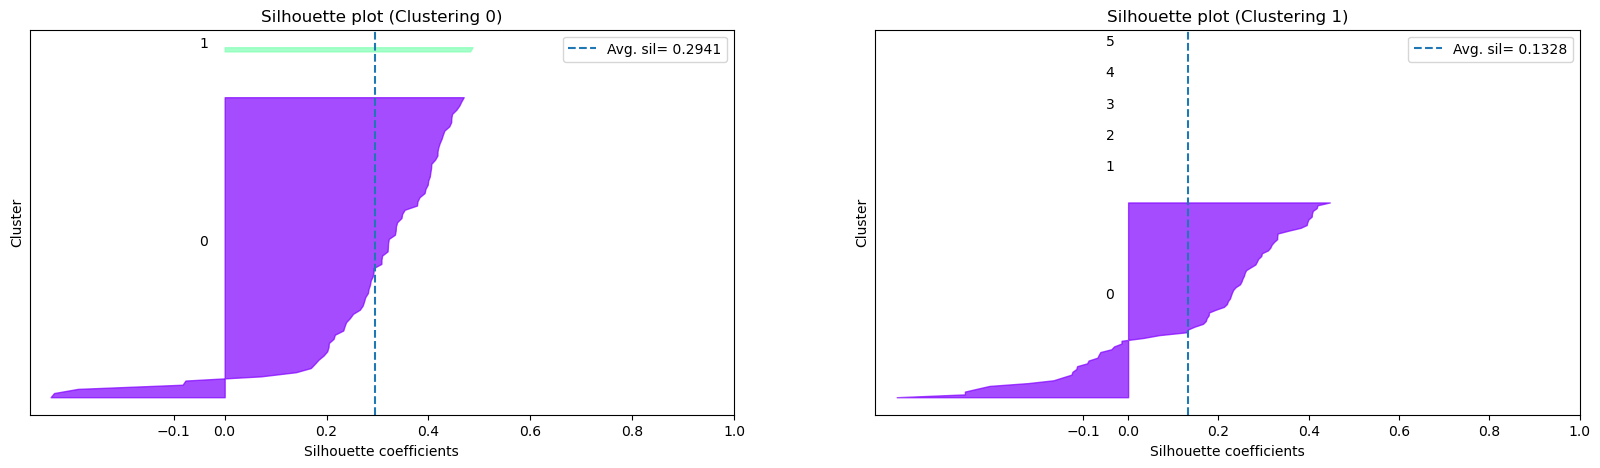

In [38]:
visualise_model_characteristics([vendor_norm]*len(hier_clustering_single_res), hier_clustering_single_res, ["sample_sil"])

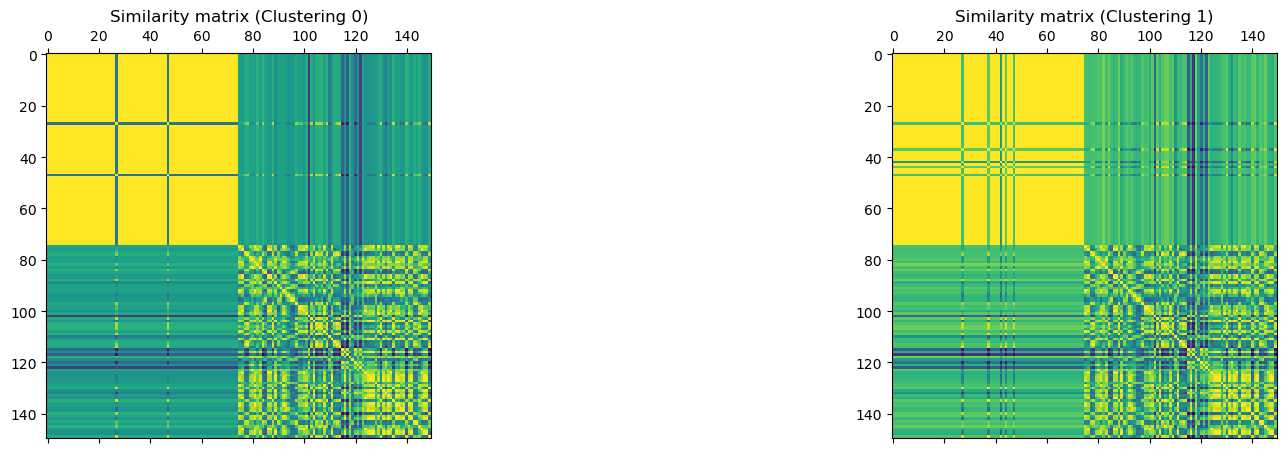

In [39]:
visualise_model_characteristics([vendor_norm]*len(hier_clustering_single_res), hier_clustering_single_res, ["simil_matrix"])

## Post processing  
In order to get a better idea we will merge the single points into a single "noise" cluster similarly to DBSCAN, otherwise the comparison is not doable.

In [40]:
post_labels = hier_clustering_single_res[1].labels_

new_labels_dict = group_singleton_clusters(post_labels)
new_labels = remap_clust_labels(post_labels, new_labels_dict)
        
single_final = wrapper_sk(new_labels)
single_final.set_params(**{"linkage":"single"})

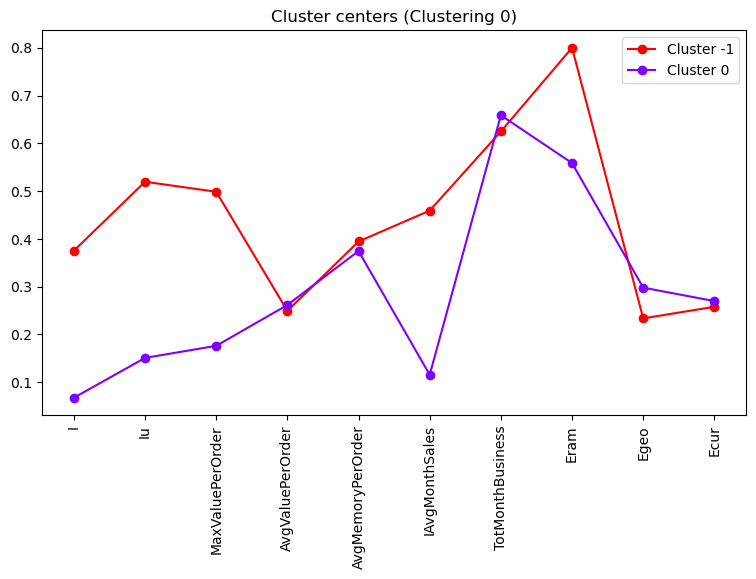

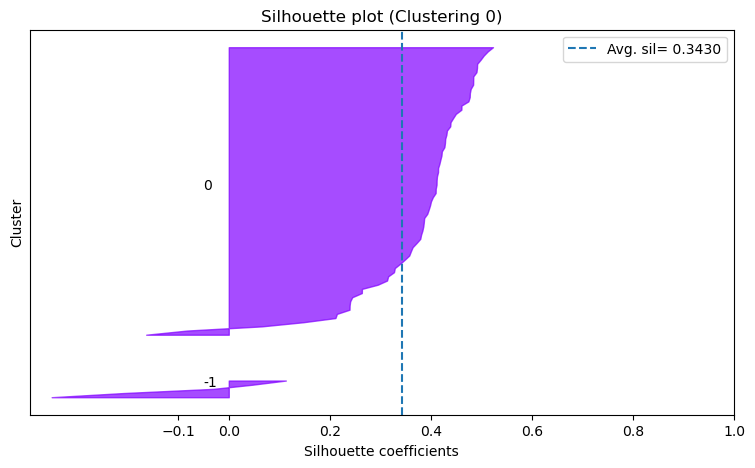

In [41]:
visualise_model_characteristics([vendor_norm], [single_final], ["avg", "sample_sil"])

Again we see a **big**/**small** classification, this time with a greater emphasis on the average monthly revenue compared to the DBSCAN outcome.

In [42]:
cluster_map_single = {0:"small", -1:"big"}

### External indices

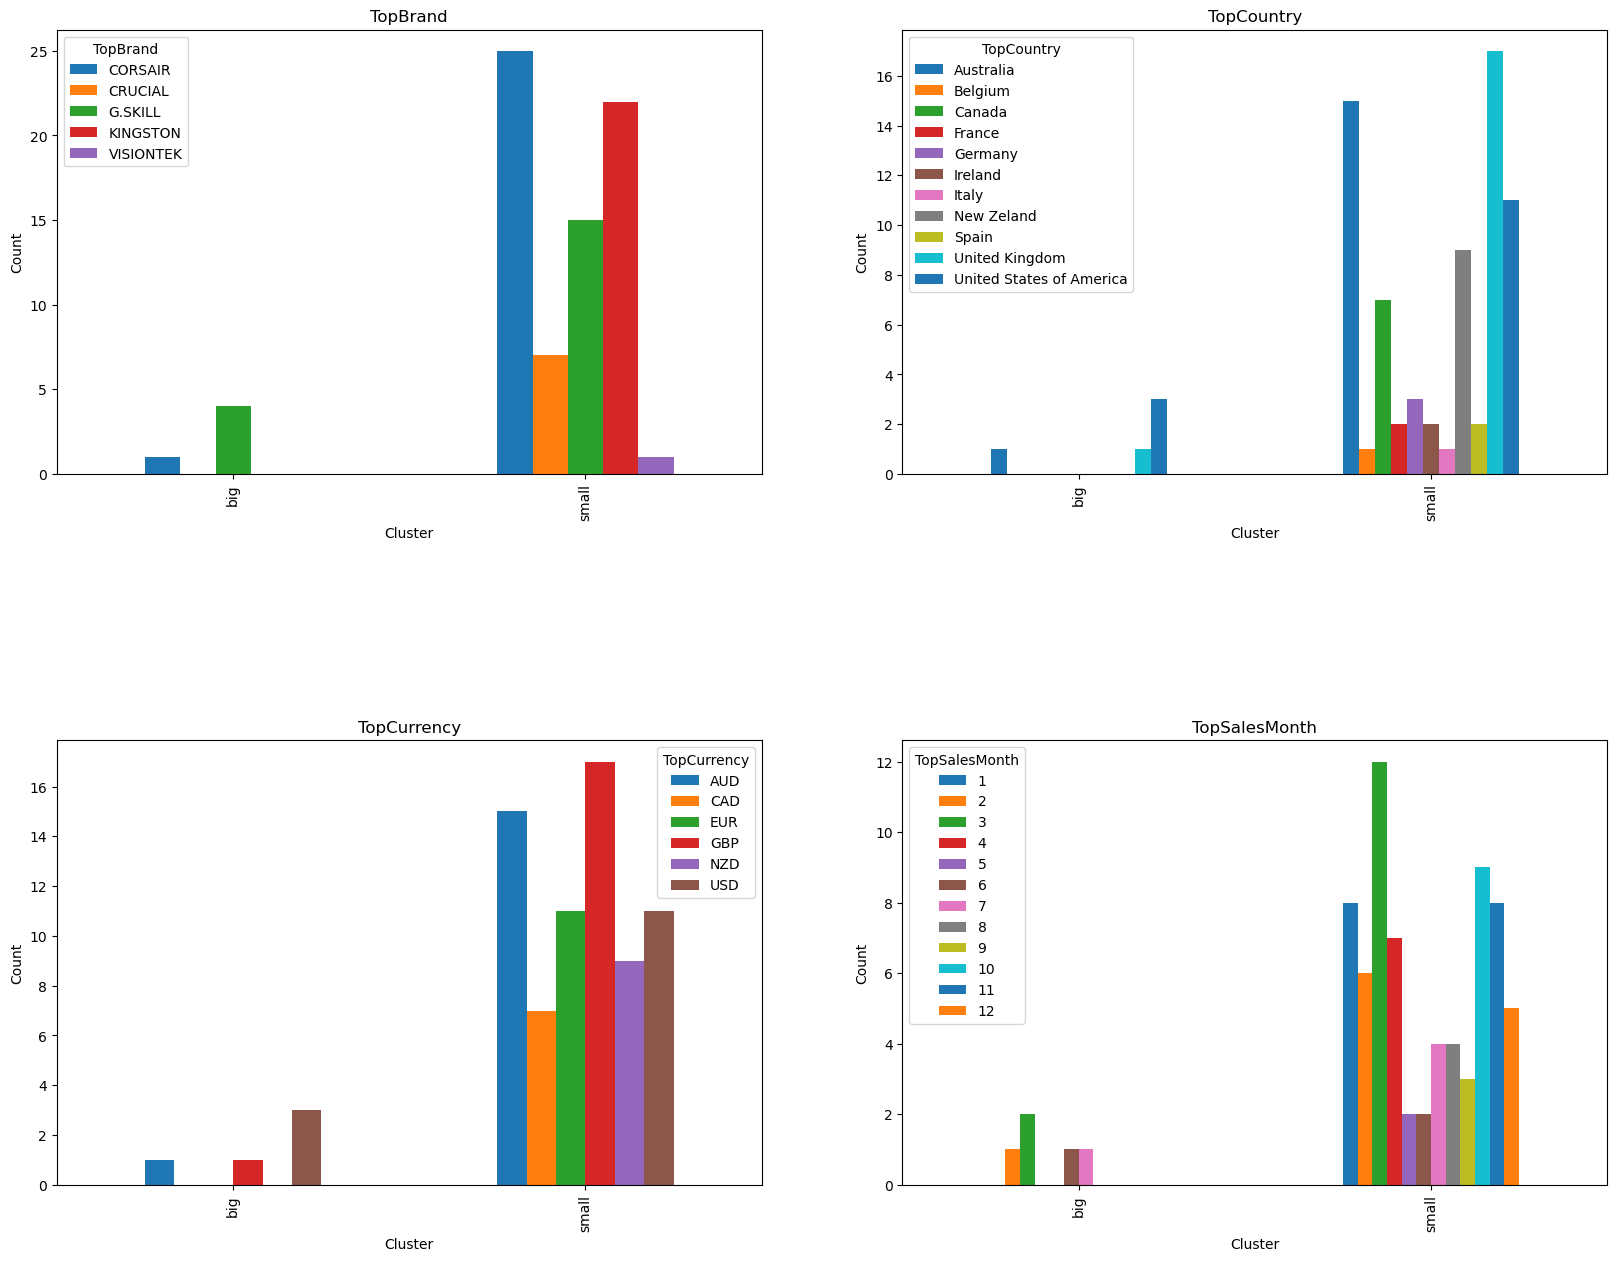

In [43]:
plot_categ_per_cluster(vendor_df_cat, single_final, cluster_map_single)

In [44]:
create_external_indices(vendor_df_cat, single_final)

Feature  Homogeneity  Completeness  Mutual Info
0       TopBrand     0.042870      0.236951     0.072605
1     TopCountry     0.023344      0.190144     0.041583
2    TopCurrency     0.026724      0.190144     0.046862
3  TopSalesMonth     0.030209      0.291009     0.054736

### Conclusion  
We can see from the dendrogram, with single linkage, that the majority of the clusters, especially the top level ones, are formed by agglomerating a big cluster and a bunch of separate single points.  
Wherever we choose to cut we will have a few very big clusters and some small ones, it seems however that the post-processing that we applied improved at least the internal metrics.  
At the end of the hierarchical clustering section we will compare the results across different linkage methods.

## Complete linkage

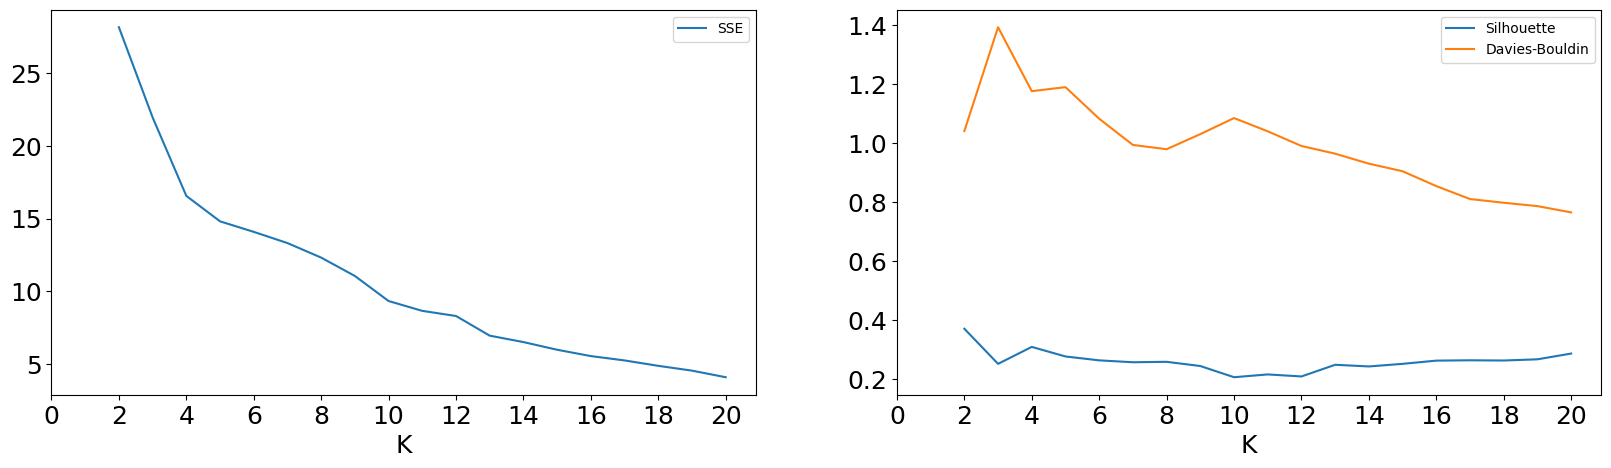

In [45]:
plot_metrics_per_k(vendor_norm, ["sse", "sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="complete"))

Cophenetic coefficient: 0.72424785268381


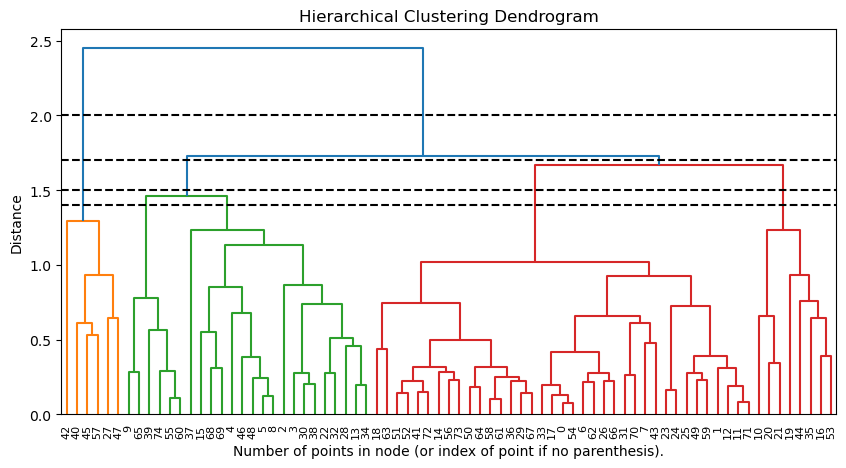

              Num. clusters              Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                                    
0                         2                     [{0: 69, 1: 6}]                       0  28.158243        0.369885       1.040547
1                         3              [{0: 45, 1: 6, 2: 24}]                       0  21.962575        0.250721       1.392849
2                         4        [{0: 24, 1: 6, 2: 8, 3: 37}]                       0  16.568995        0.308216       1.175836
3                         5  [{0: 6, 1: 18, 2: 8, 3: 37, 4: 6}]                       0  14.819445        0.275727       1.189555


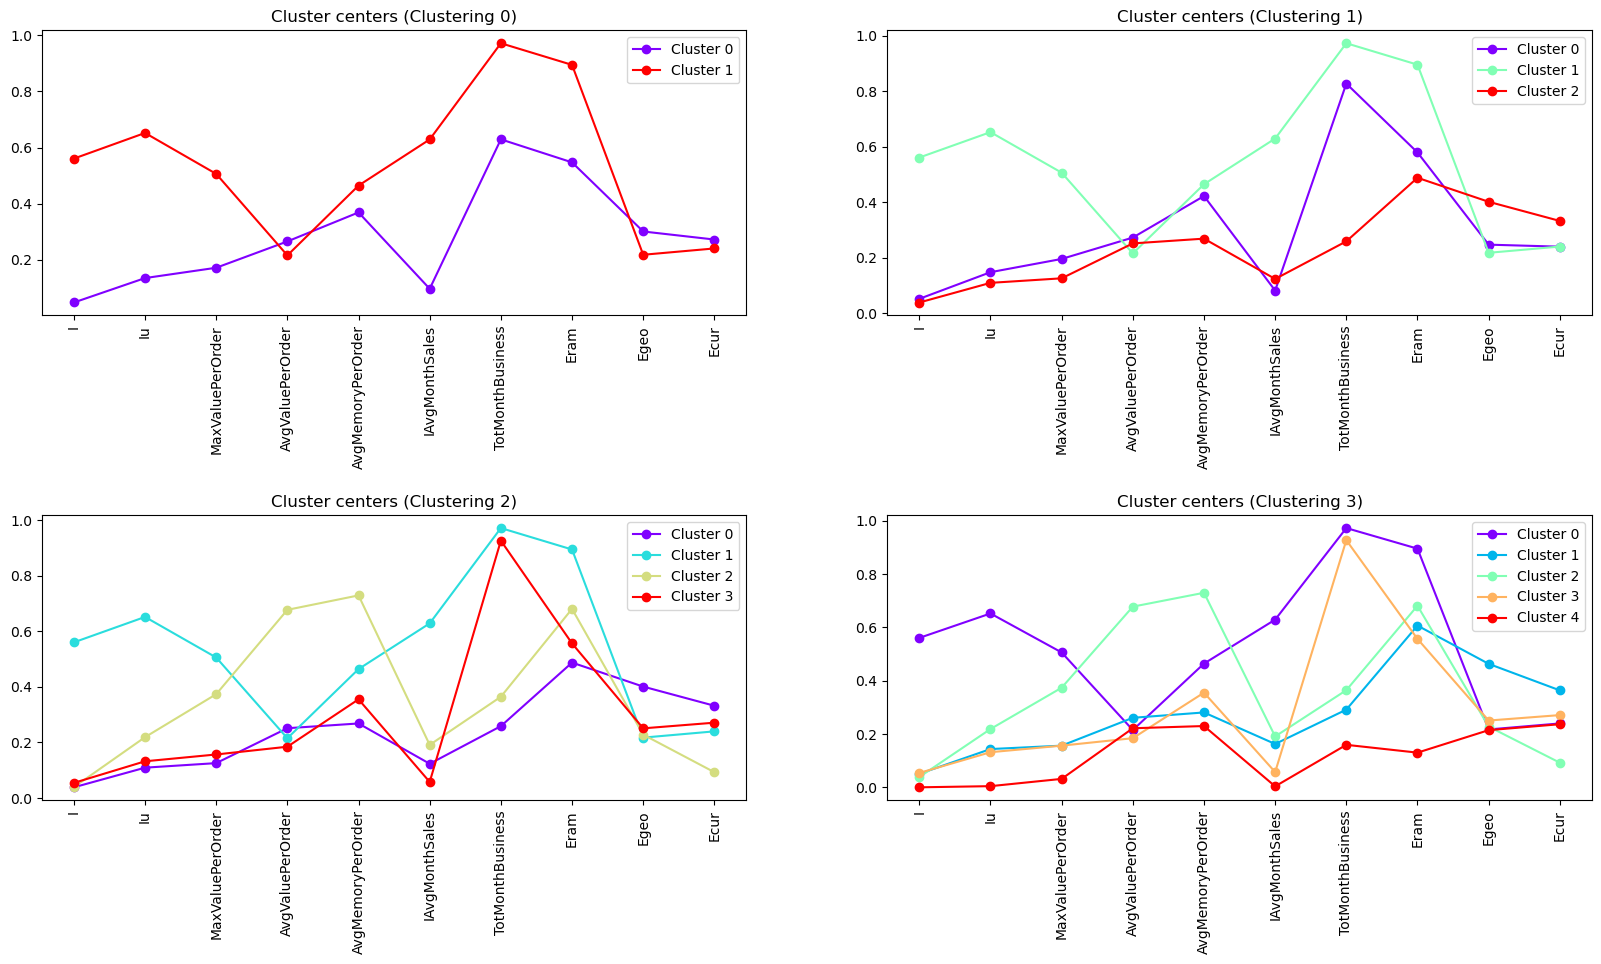

In [46]:
max_d = [2, 1.7, 1.5, 1.4]

hier_clustering_complete_res = []

for i in max_d:
    hier_clustering_complete_res.append(AgglomerativeClustering(distance_threshold=i, n_clusters=None, linkage="complete").fit(vendor_norm))

Z = linkage(vendor_norm, 'complete')
c, coph_dists = cophenet(Z, pdist(vendor_norm))
print(f"Cophenetic coefficient: {c}")

plot_dendrogram(hier_clustering_complete_res[0], max_d, truncate_mode='level', p=20)
visualise_model_characteristics([vendor_norm]*len(hier_clustering_complete_res), hier_clustering_complete_res)

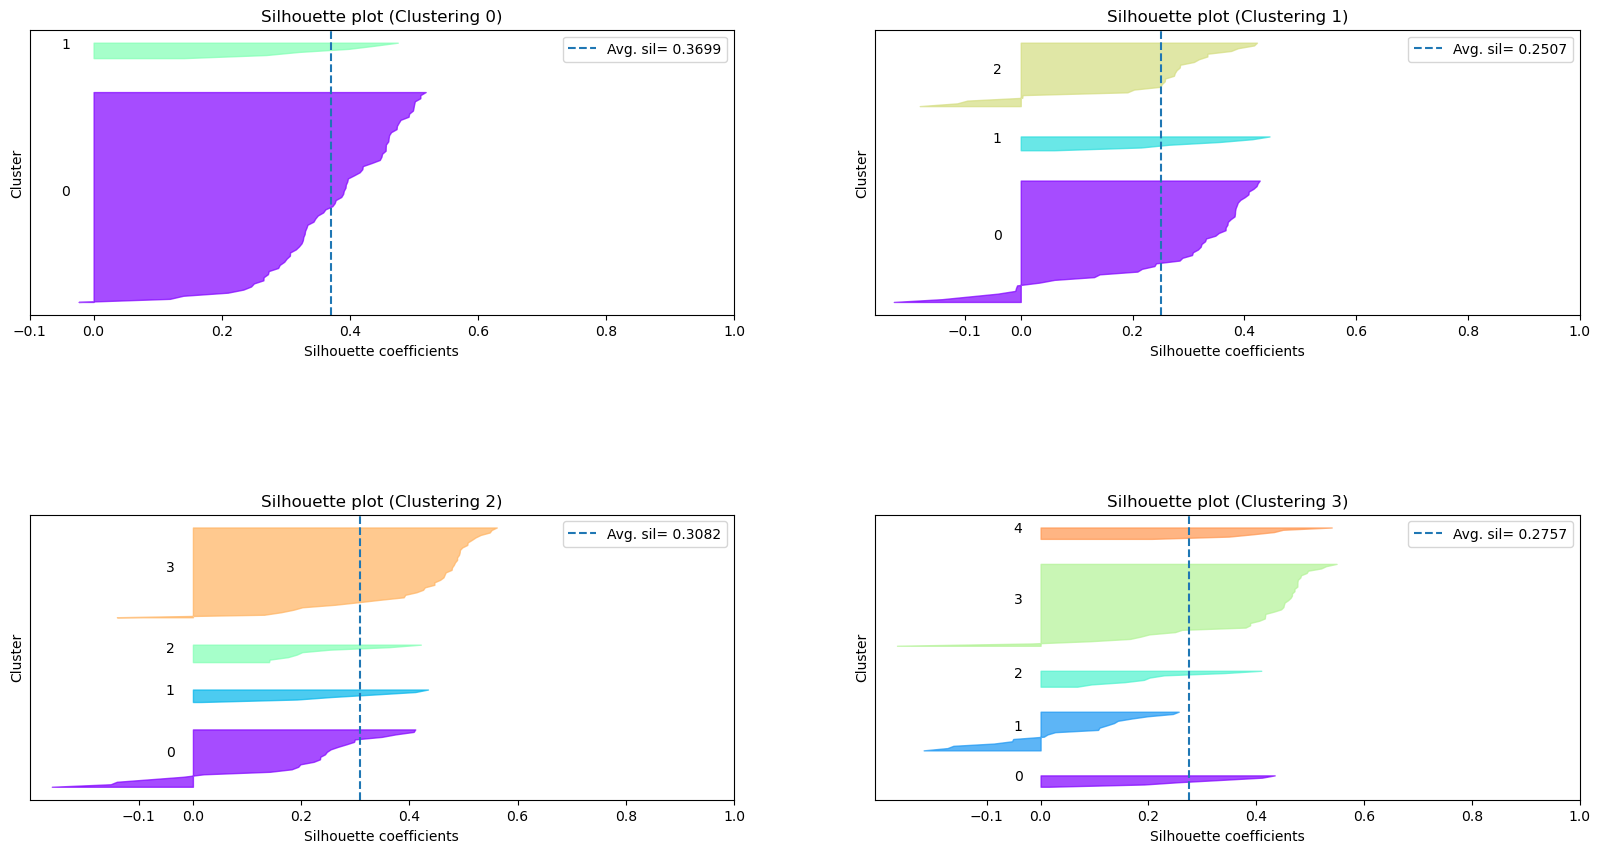

In [47]:
visualise_model_characteristics([vendor_norm]*len(hier_clustering_complete_res), hier_clustering_complete_res, ["sample_sil"])

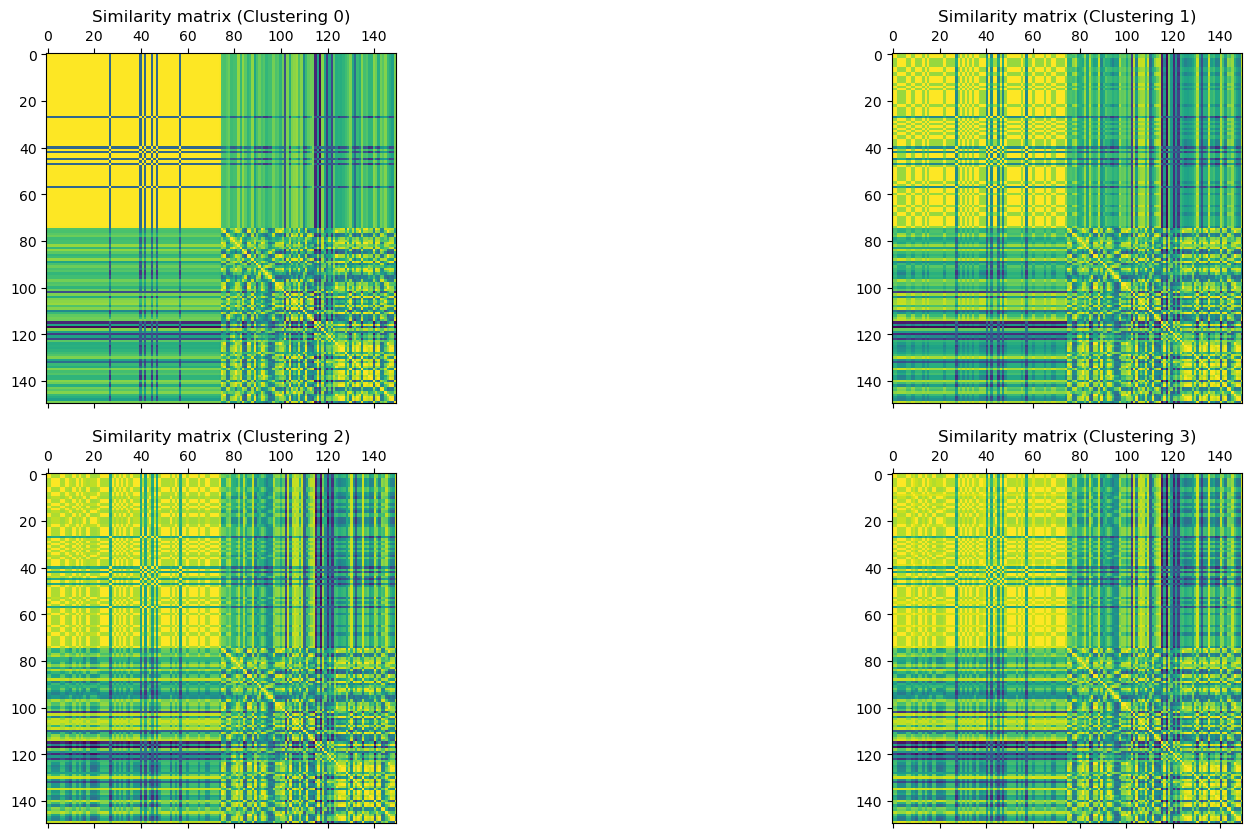

In [48]:
visualise_model_characteristics([vendor_norm]*len(hier_clustering_complete_res), hier_clustering_complete_res, ["simil_matrix"])

Among the different clusterings the most promising seems to be the 1st one, based on the internal metrics and the uniformity of the similarity matrix compared to the other clusterings.  
The clusters distinguishing features are again I/Iu/IAvgSalesMonth once again, further confirming that we are onto something.  
This corresponds to a **big/small** labeling, the same one used with single linkage.

In [49]:
complete_final = hier_clustering_complete_res[0]

cluster_map_complete = {0:"small", 1:"big"}

### External indices

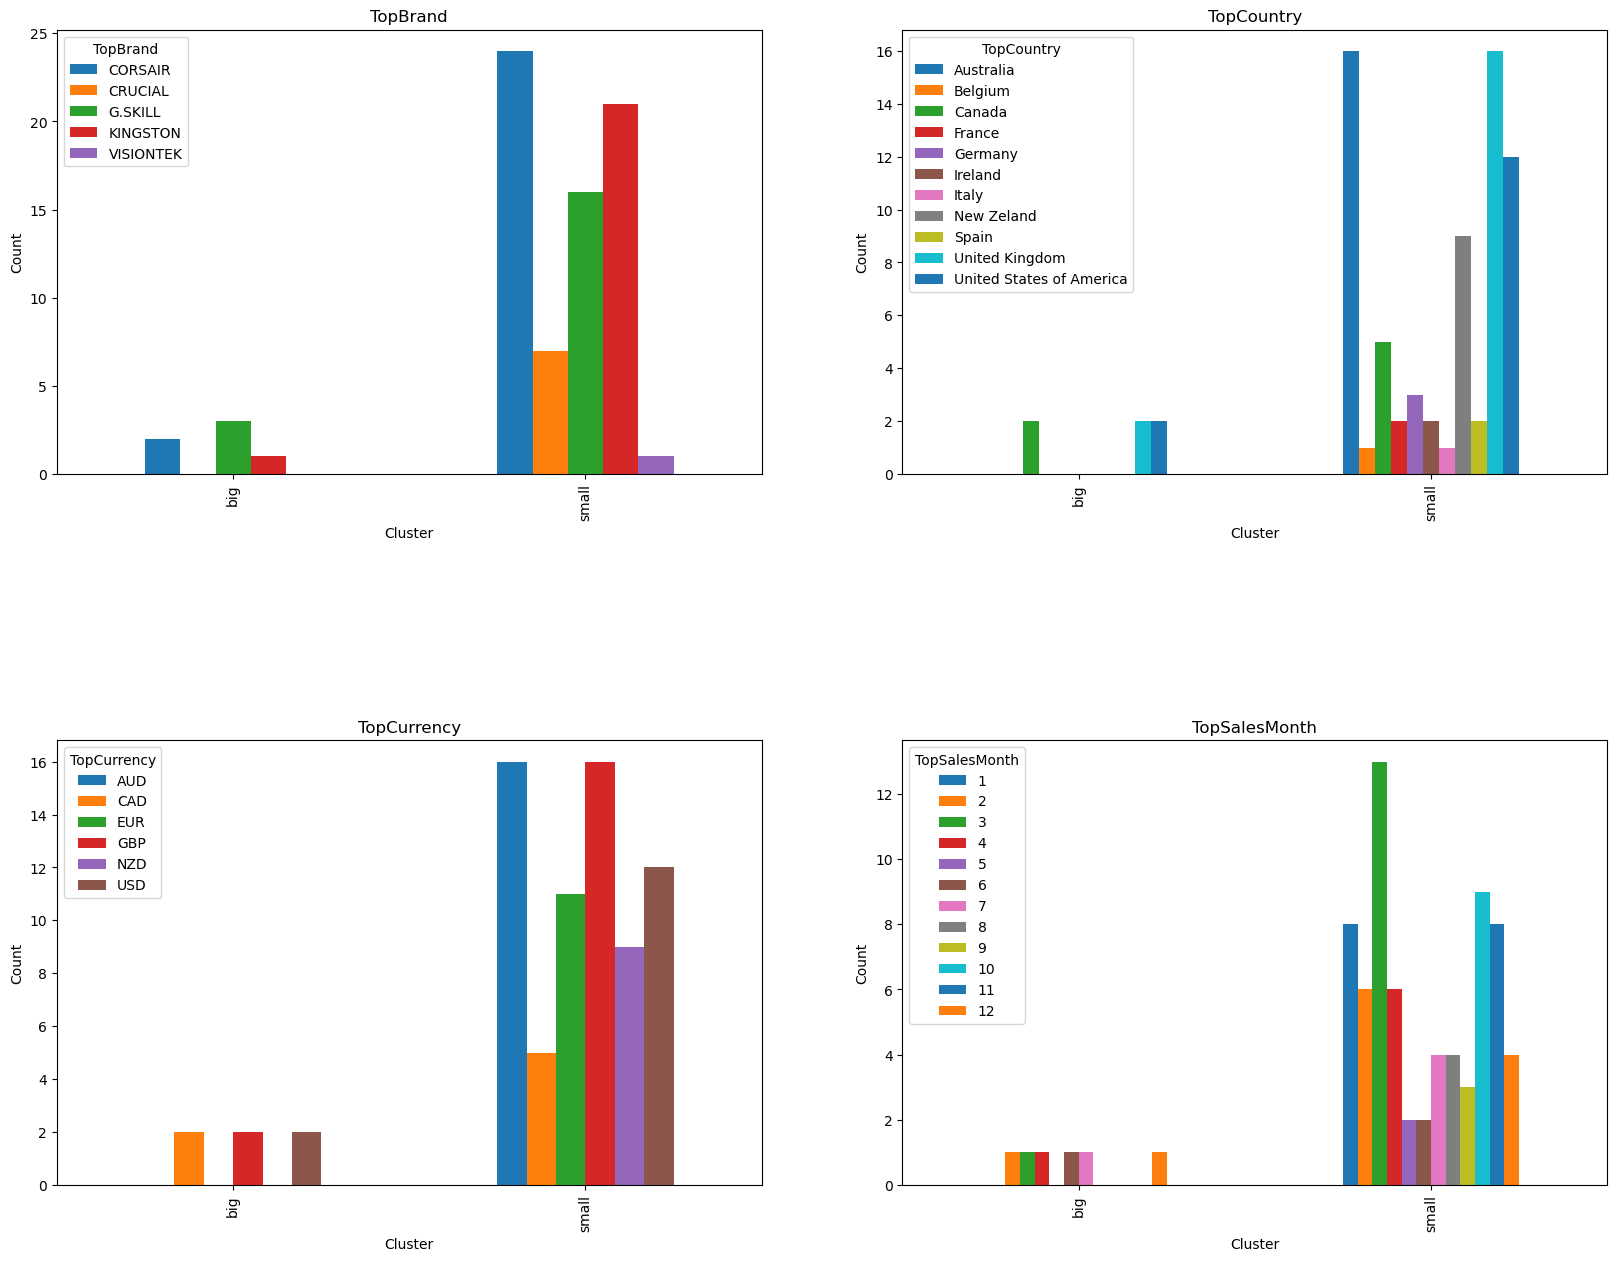

In [50]:
plot_categ_per_cluster(vendor_df_cat, complete_final, cluster_map_complete)

In [51]:
create_external_indices(vendor_df_cat, complete_final)

Feature  Homogeneity  Completeness  Mutual Info
0       TopBrand     0.014791      0.071827     0.024530
1     TopCountry     0.031406      0.224760     0.055112
2    TopCurrency     0.035953      0.224760     0.061990
3  TopSalesMonth     0.026278      0.222408     0.047002

#### Conclusion  
The results are again very close to the ones from the other algorithms.

### Average linkage

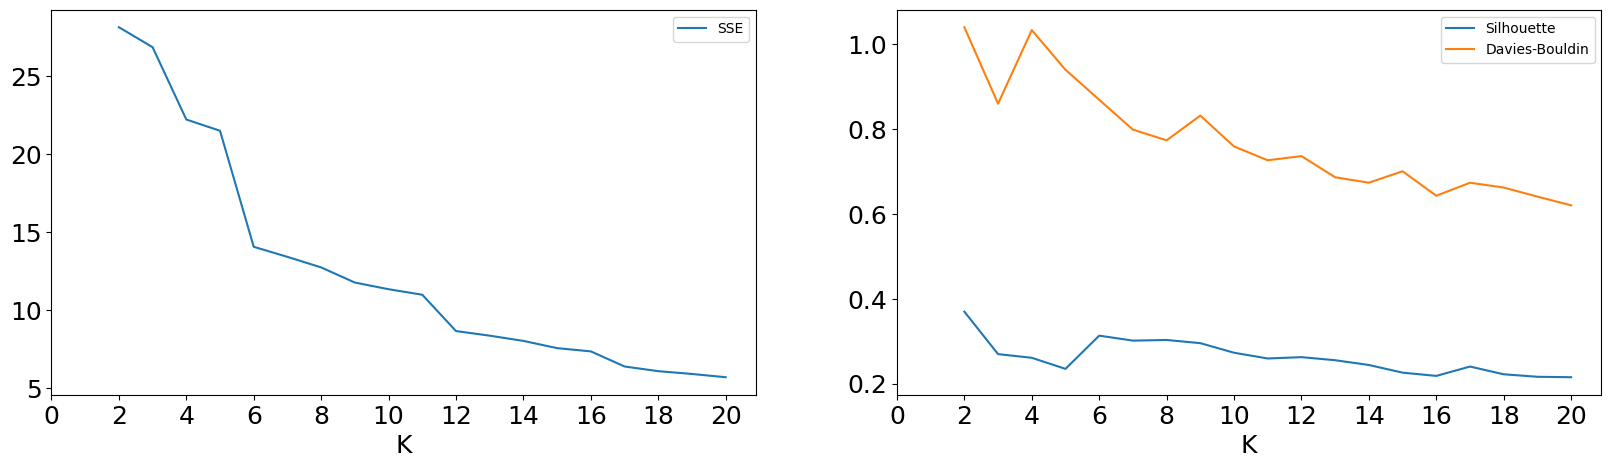

In [52]:
plot_metrics_per_k(vendor_norm, ["sse", "sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="average"))

Cophenetic coefficient: 0.7902253226984014


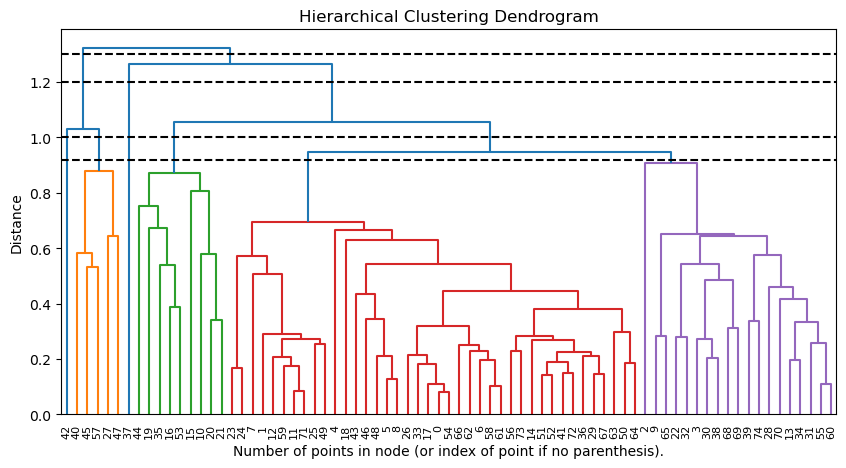

              Num. clusters                    Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                                          
0                         2                           [{0: 69, 1: 6}]                       0  28.158243        0.369885       1.040547
1                         3                     [{0: 68, 1: 6, 2: 1}]                       1  26.875245        0.269734        0.86024
2                         5         [{0: 59, 1: 5, 2: 1, 3: 9, 4: 1}]                       2  21.508558        0.234957       0.940245
3                         6  [{0: 19, 1: 5, 2: 40, 3: 9, 4: 1, 5: 1}]                       2  14.057999        0.313247       0.869515


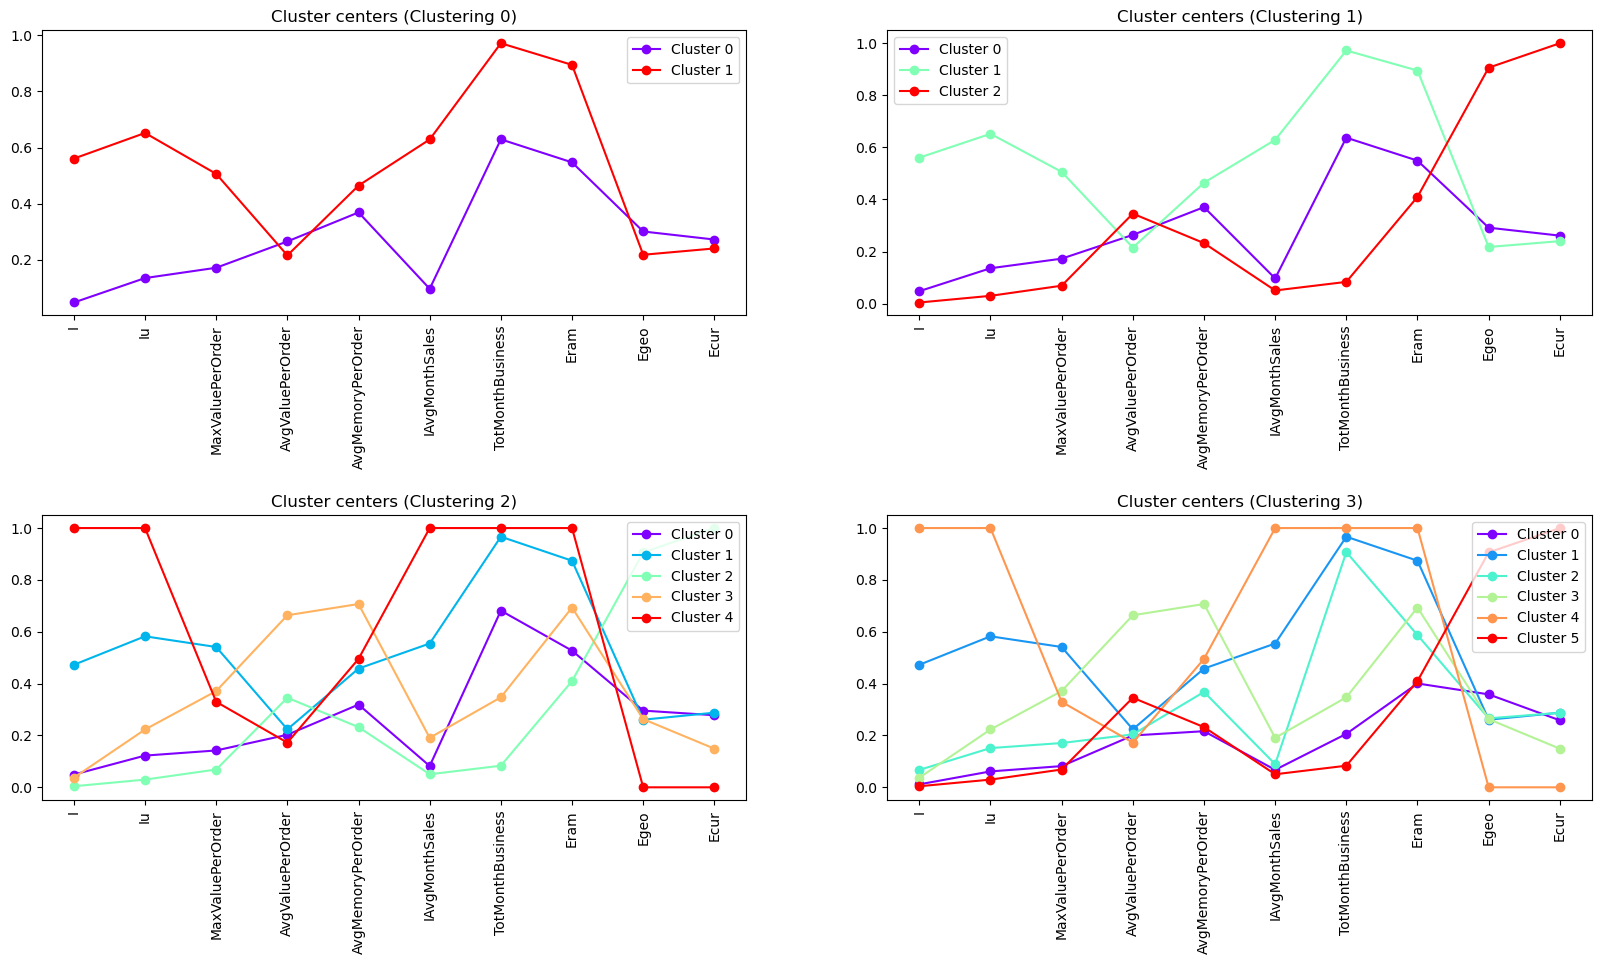

In [53]:
max_d = [1.3, 1.2, 1.0, 0.92]

hier_clustering_avg_res = []

for i in max_d:
    hier_clustering_avg_res.append(AgglomerativeClustering(distance_threshold=i, n_clusters=None, linkage="average").fit(vendor_norm))

Z = linkage(vendor_norm, 'average')
c, coph_dists = cophenet(Z, pdist(vendor_norm))
print(f"Cophenetic coefficient: {c}")

plot_dendrogram(hier_clustering_avg_res[0], max_d, truncate_mode='level', p=20)
visualise_model_characteristics([vendor_norm]*len(hier_clustering_avg_res), hier_clustering_avg_res)

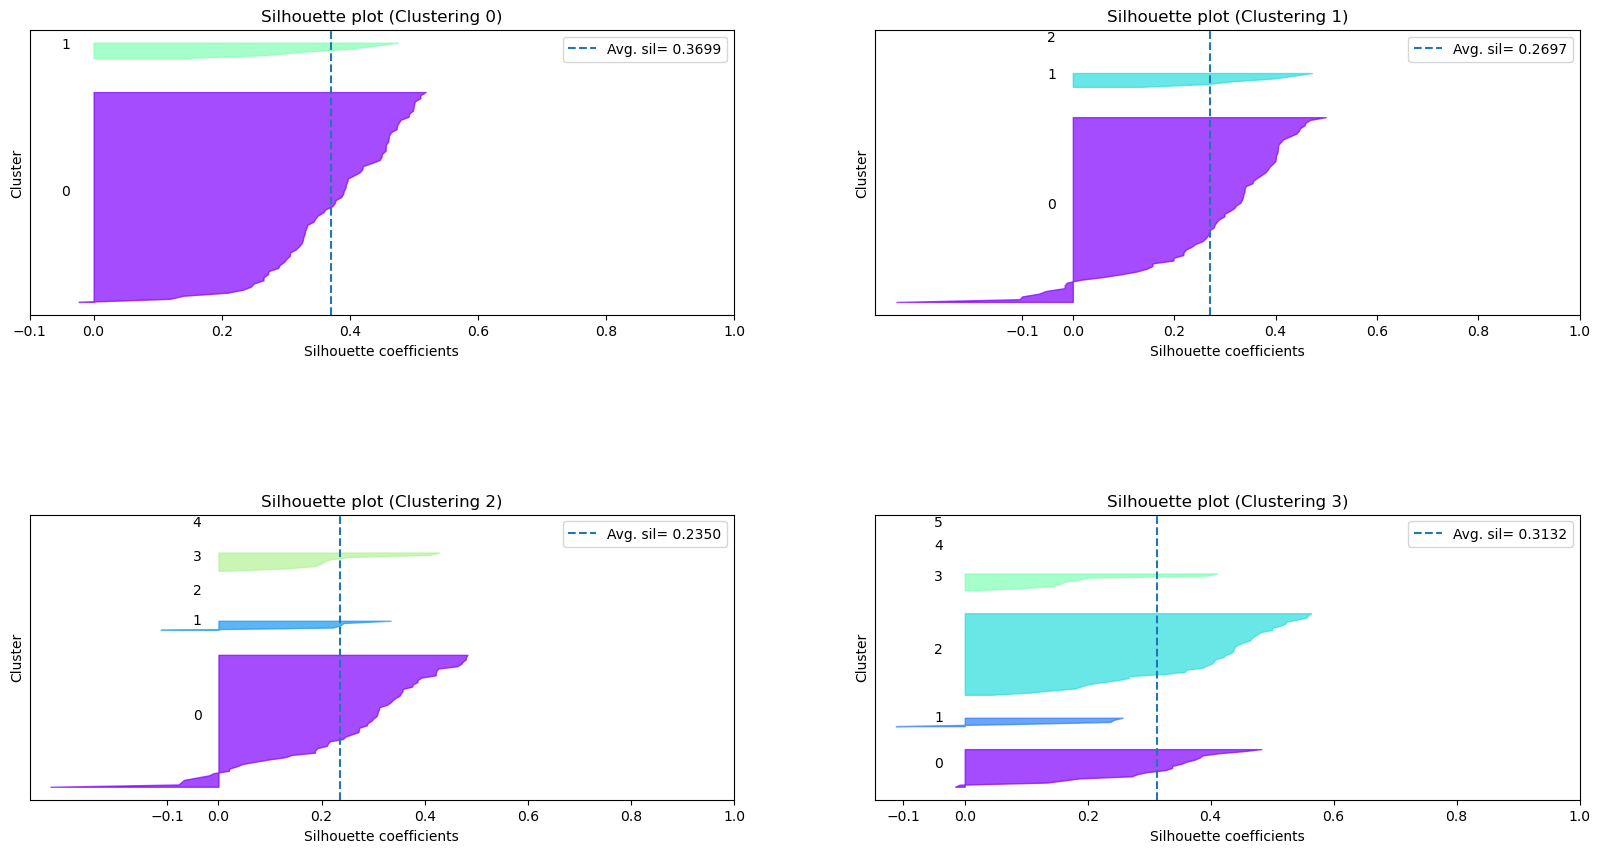

In [54]:
visualise_model_characteristics([vendor_norm]*len(hier_clustering_avg_res), hier_clustering_avg_res, ["sample_sil"])

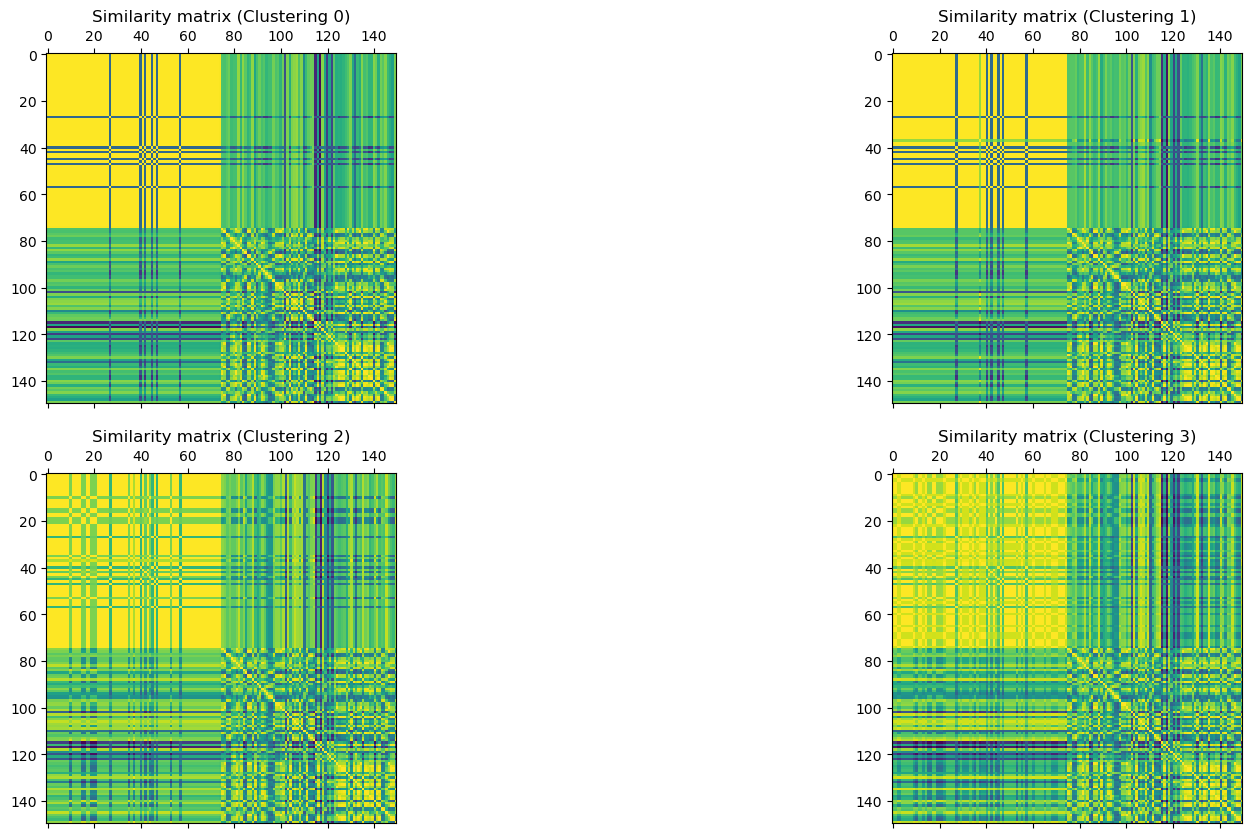

In [55]:
visualise_model_characteristics([vendor_norm]*len(hier_clustering_avg_res), hier_clustering_avg_res, ["simil_matrix"])

The clustering choice here is non-obvious, the number of clusters and their composition makes the clusterings very fragmented and with low internal metrics, the only reasonble one seems to be the 1st/2nd ones however their cutting heights are quite high and some of the metrics are not too promising.  
Before taking a decision we will take a closer look at the other clusterings.

### Post-processing
Again, in this section we group all singleton clusters in order to get a clearer picture of the situation.

#### Clustering 1

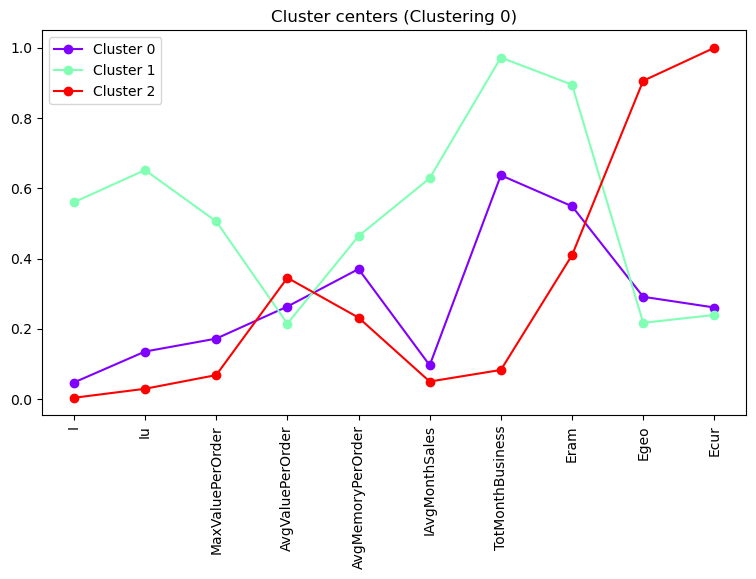

In [56]:
visualise_model_characteristics([vendor_norm], [hier_clustering_avg_res[1]], ["avg"])

We deal with the singleton cluster in the 2nd clustering by merging it in the cluster 1, which shows similar characteristics to it.

In [57]:
new_clustering_1_labels = hier_clustering_avg_res[1].labels_

for i in range(len(new_clustering_1_labels)):
    if new_clustering_1_labels[i] == 2:
        new_clustering_1_labels[i] = 1
        
new_clustering_1 = wrapper_sk(new_clustering_1_labels)

              Num. clusters Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                       
0                         2        [{0: 68, 1: 7}]                       0  29.764897        0.357109        1.47789


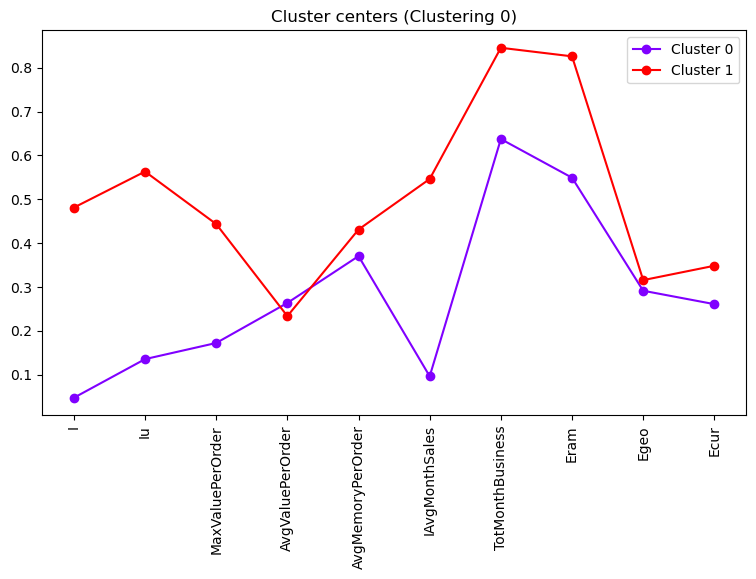

In [58]:
visualise_model_characteristics([vendor_norm], [new_clustering_1], ["general", "avg"])

#### Clustering 2

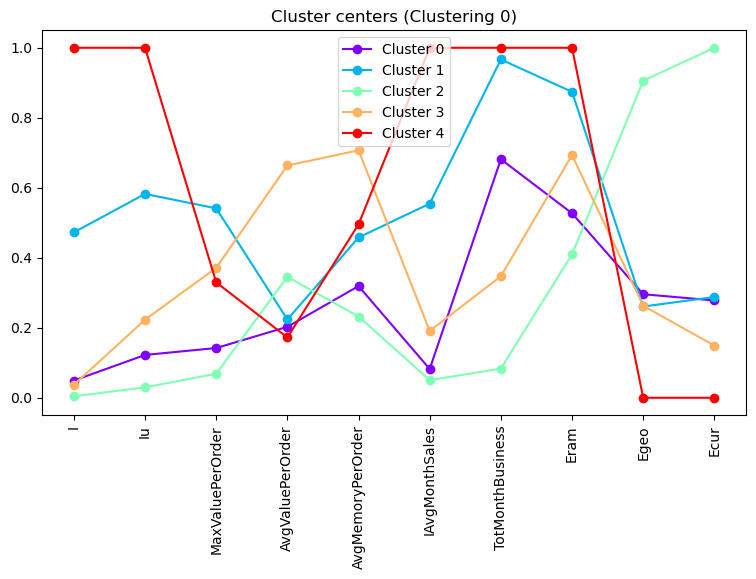

In [59]:
visualise_model_characteristics([vendor_norm], [hier_clustering_avg_res[2]], ["avg"])

In [60]:
new_clustering_2_labels = hier_clustering_avg_res[2].labels_
new_clustering_2_labels = remap_clust_labels(new_clustering_2_labels, group_singleton_clusters(new_clustering_2_labels))

new_clustering_2 = wrapper_sk(new_clustering_2_labels)

              Num. clusters        Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                              
0                         4  [{-1: 2, 0: 59, 1: 5, 3: 9}]                       0  24.514528        0.258524       2.296959


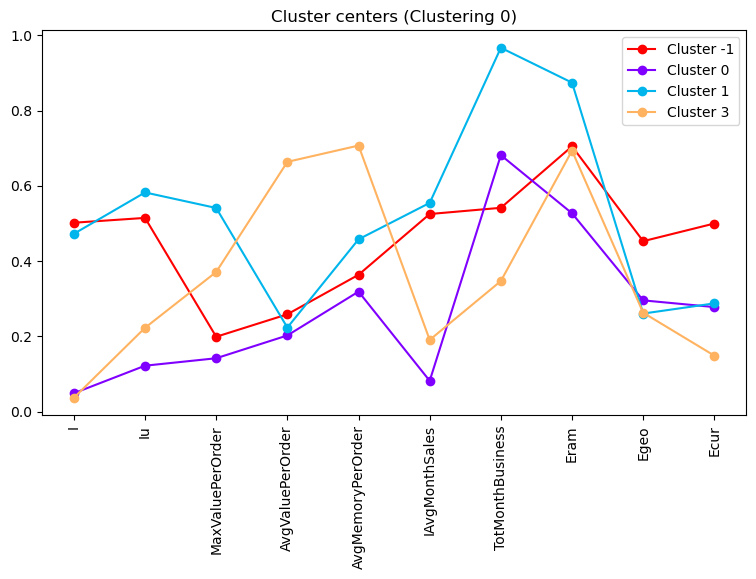

In [61]:
visualise_model_characteristics([vendor_norm], [new_clustering_2], ["general", "avg"])

We can see that the noise cluster is especially close, in terms of the key features I/Iu/IAvgMonthSales to cluster 1.  
We will therefore merge them.

In [62]:
new_clustering_2_labels = remap_clust_labels(new_clustering_2_labels, {-1:1, 0:0, 1:1, 2:2, 3:3})

new_clustering_2 = wrapper_sk(new_clustering_2_labels)

#### Clustering 3

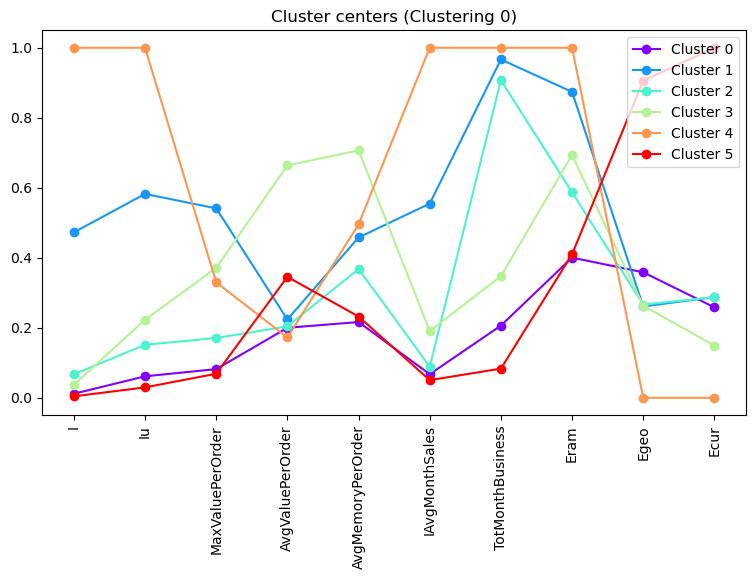

In [63]:
visualise_model_characteristics([vendor_norm], [hier_clustering_avg_res[3]], ["avg"])

In [64]:
new_clustering_3_labels = hier_clustering_avg_res[3].labels_
new_clustering_3_labels = remap_clust_labels(new_clustering_3_labels, group_singleton_clusters(new_clustering_3_labels))

new_clustering_3 = wrapper_sk(new_clustering_3_labels)

              Num. clusters               Datapoints per cluster Num. singleton clusters       SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                                    
0                         5  [{-1: 2, 0: 19, 1: 5, 2: 40, 3: 9}]                       0  17.06397        0.318639        2.12271


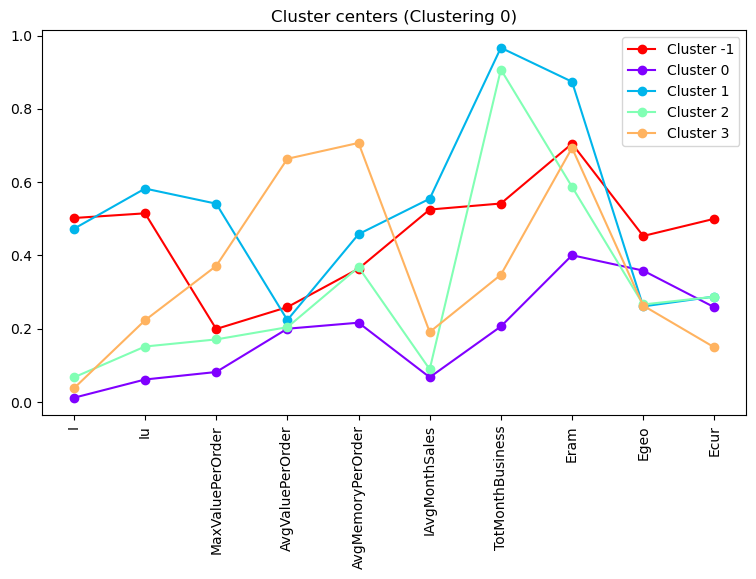

In [65]:
visualise_model_characteristics([vendor_norm], [new_clustering_3], ["general", "avg"])

Same as in the clustering 2 case.

In [66]:
new_clustering_3_labels = remap_clust_labels(new_clustering_3_labels, {-1:1, 0:0, 1:1, 2:2, 3:3})

new_clustering_3 = wrapper_sk(new_clustering_3_labels)

#### Clustering comparison

              Num. clusters        Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                              
0                         2               [{0: 69, 1: 6}]                       0  28.158243        0.369885       1.040547
1                         2               [{0: 68, 1: 7}]                       0  29.764897        0.357109        1.47789
2                         3         [{0: 59, 1: 7, 3: 9}]                       0  25.121027        0.275494        1.37243
3                         4  [{0: 19, 1: 7, 2: 40, 3: 9}]                       0  17.670469        0.325911       1.254146


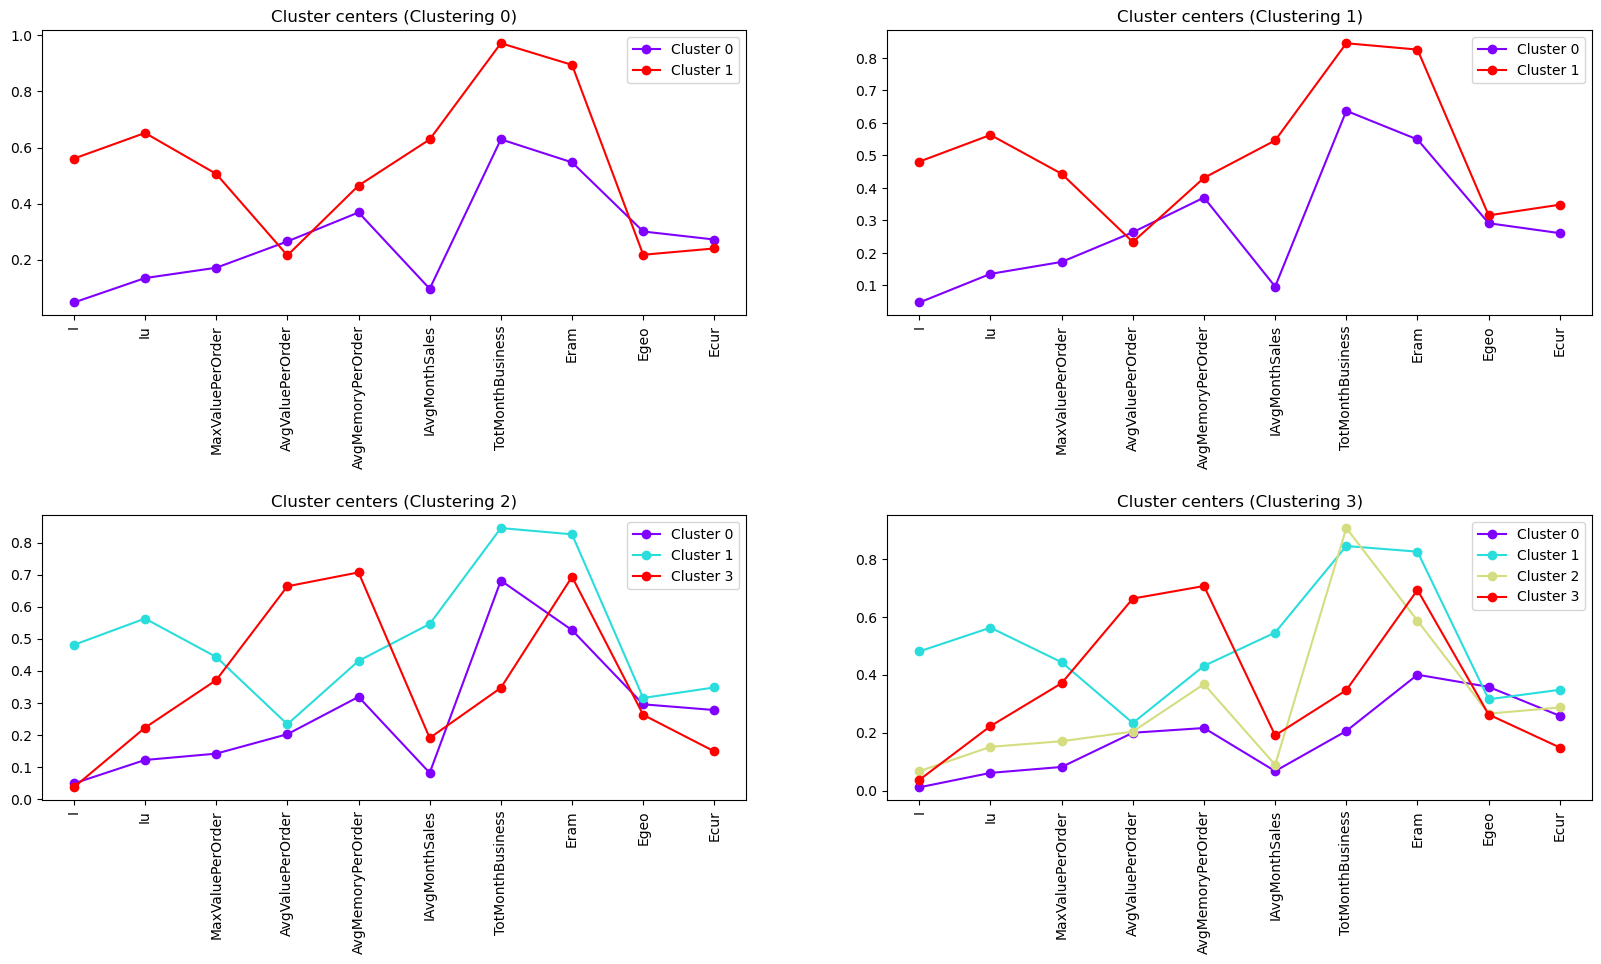

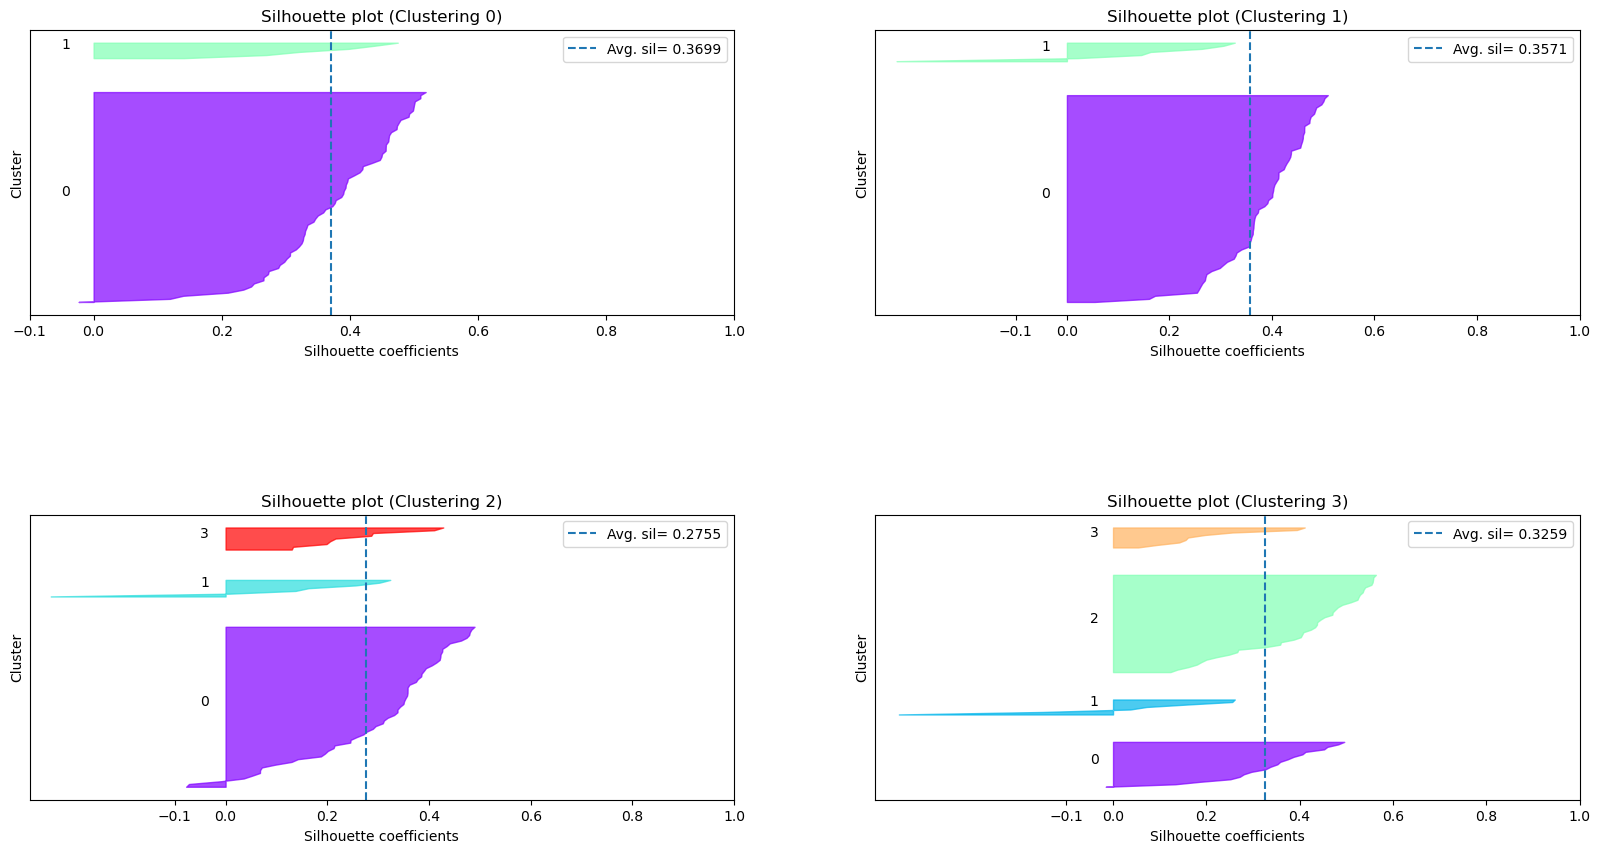

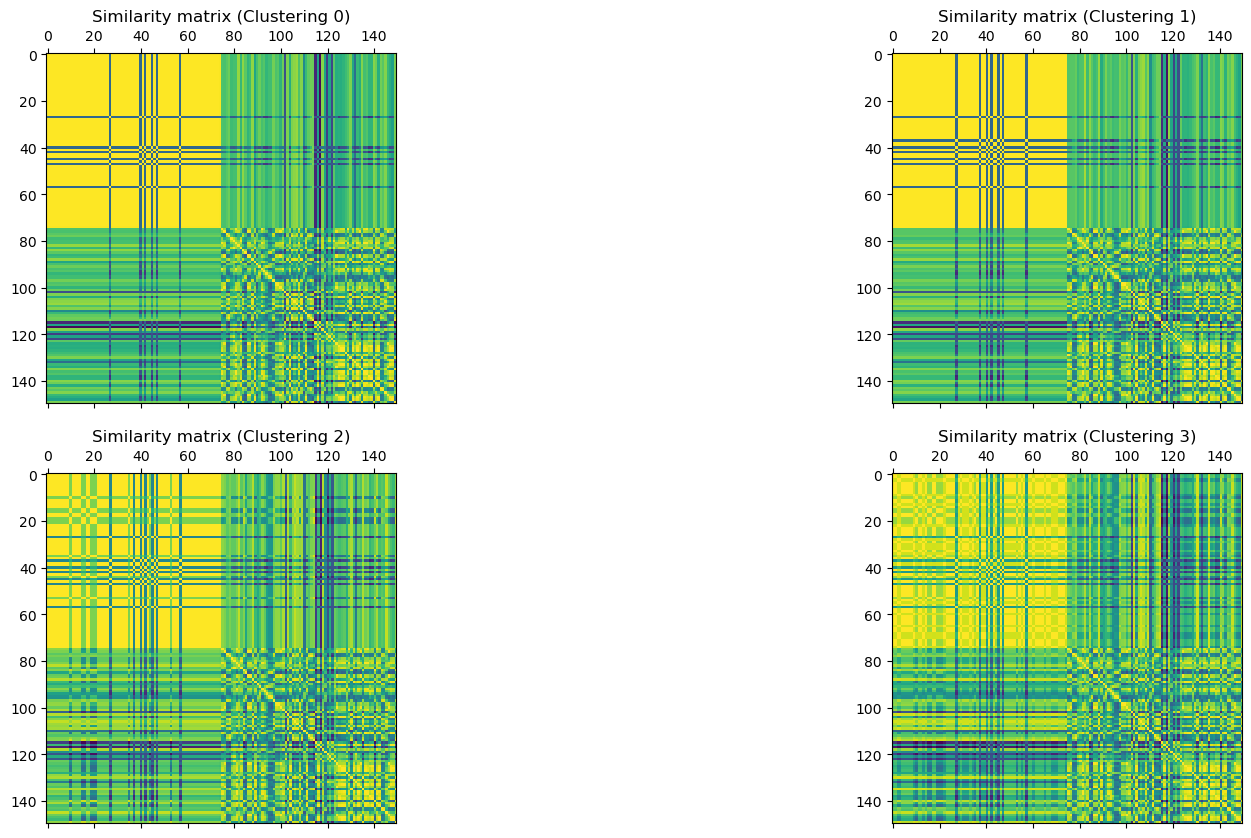

In [99]:
visualise_model_characteristics([vendor_norm]*4, [hier_clustering_avg_res[0], new_clustering_1, \
                                                  new_clustering_2, new_clustering_3], ["general", "avg", "sample_sil", "simil_matrix"])

The first two clusterings are almost identical and correspond to the usual **big/small** labeling.  
The clustering 2 presents some similarities to the ones obtained by k-means and single linkage, however its internal metrics are the worst ones.  
The clustering 0 is the most promising based on the internal metrics and similarity matrix.

In [68]:
average_final = hier_clustering_avg_res[0]
average_final.set_params(**{"linkage":"average"})

cluster_map_average = {0:"small", 1:"big"}

### External indices

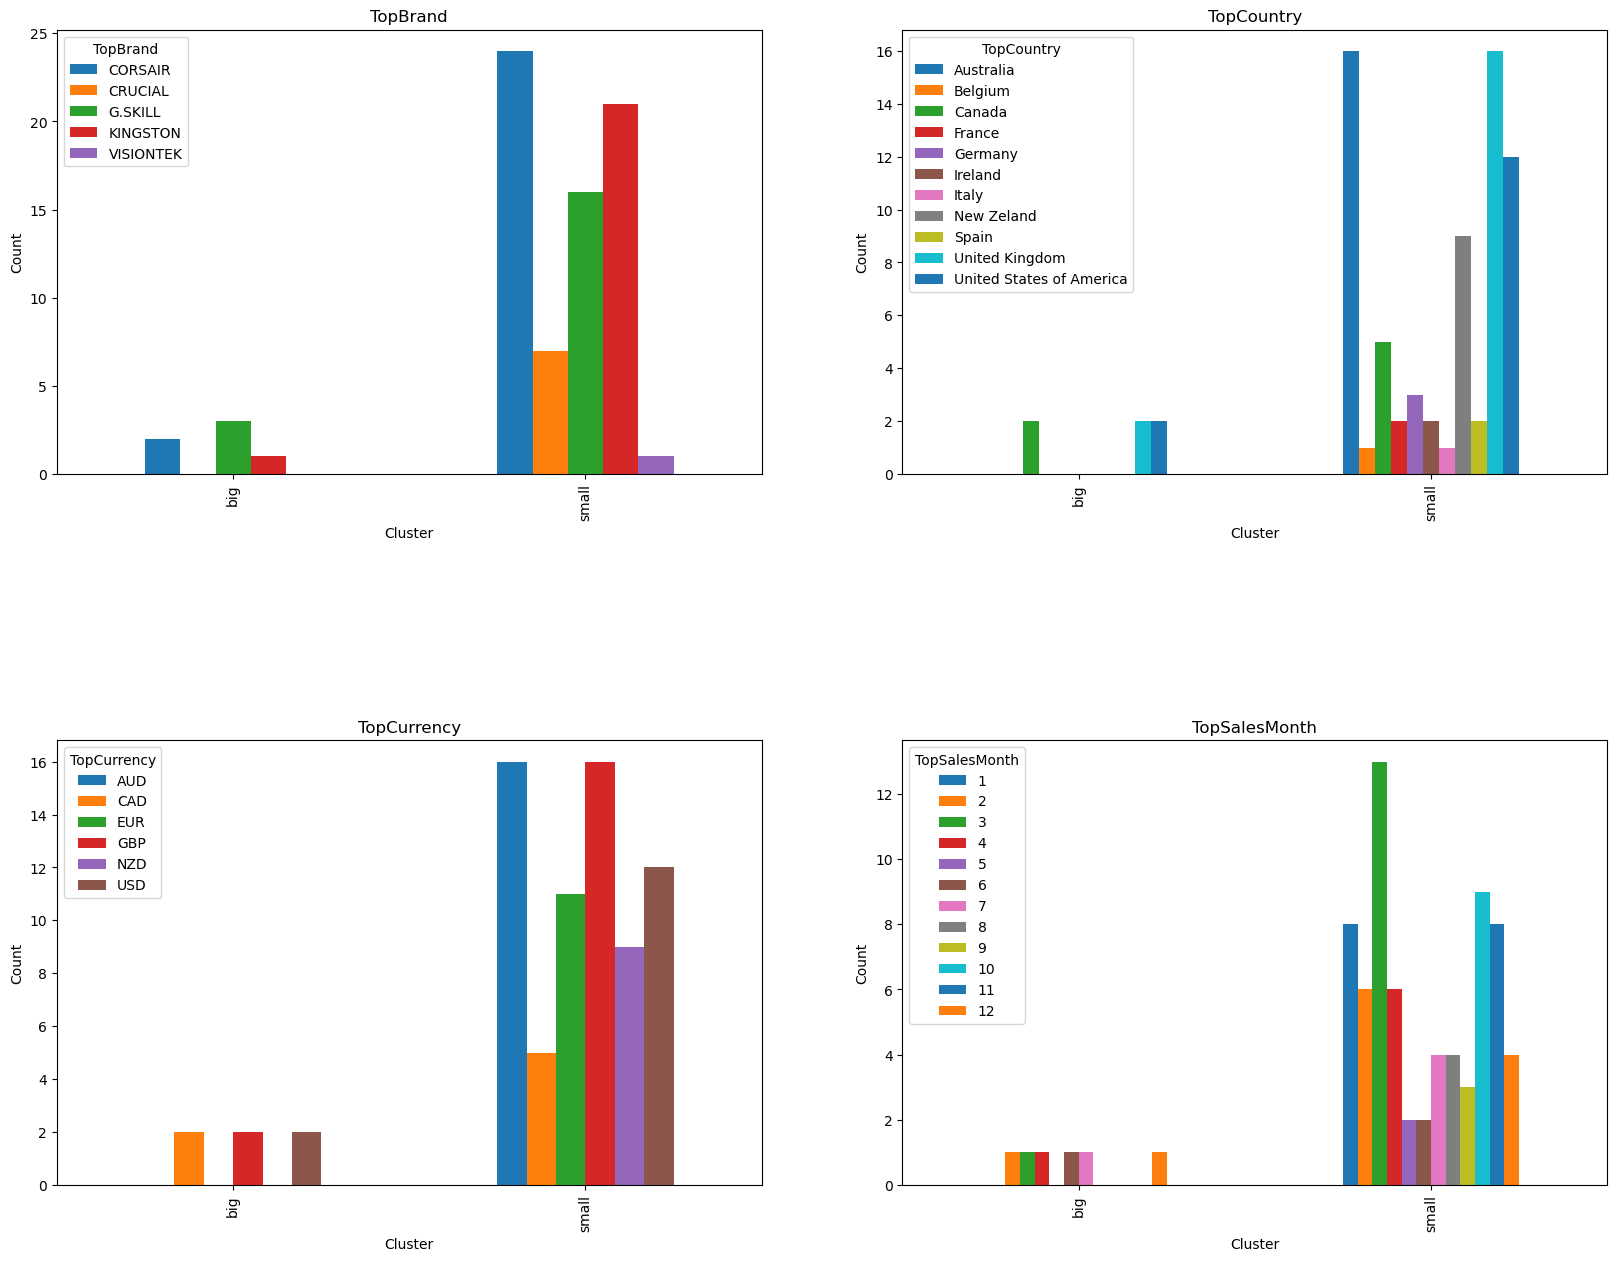

In [69]:
plot_categ_per_cluster(vendor_df_cat, average_final, cluster_map_average)

In [70]:
create_external_indices(vendor_df_cat, average_final)

Feature  Homogeneity  Completeness  Mutual Info
0       TopBrand     0.014791      0.071827     0.024530
1     TopCountry     0.031406      0.224760     0.055112
2    TopCurrency     0.035953      0.224760     0.061990
3  TopSalesMonth     0.026278      0.222408     0.047002

### Ward method

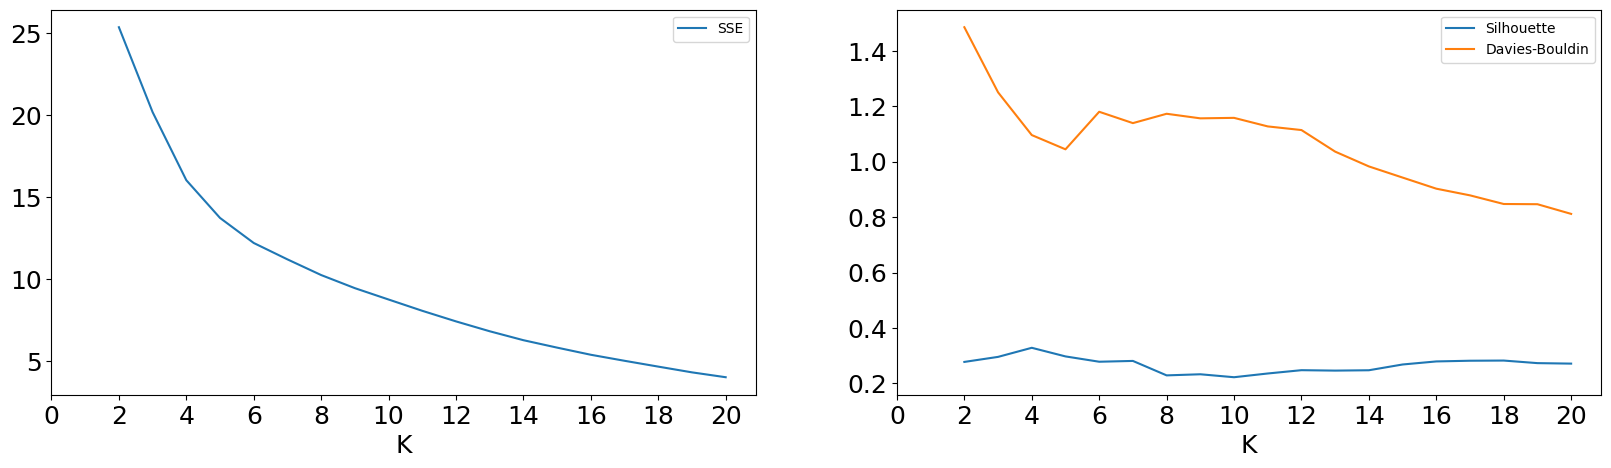

In [71]:
plot_metrics_per_k(vendor_norm, ["sse", "sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="ward"))

              Num. clusters        Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                              
0                         4  [{0: 38, 1: 23, 2: 6, 3: 8}]                       0  16.022487        0.328263       1.096212


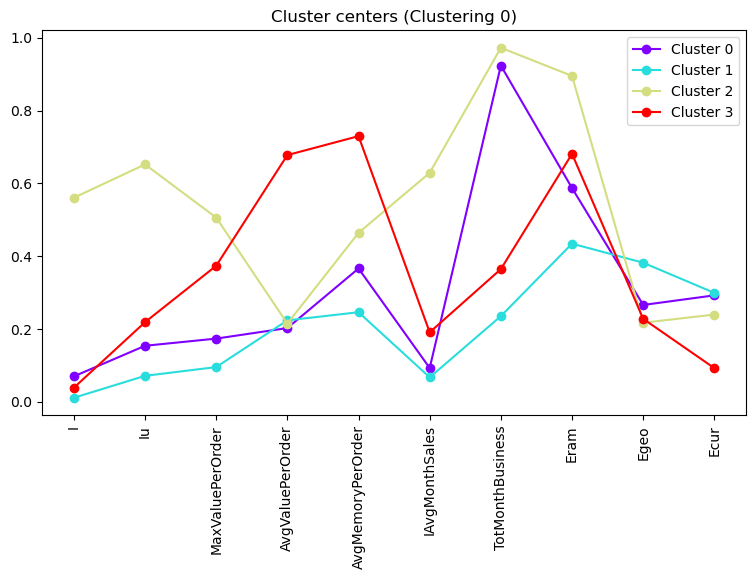

In [103]:
visualise_model_characteristics([vendor_norm], [hier_clustering_ward_res[2]])

Cophenetic coefficient: 0.6082119998283975


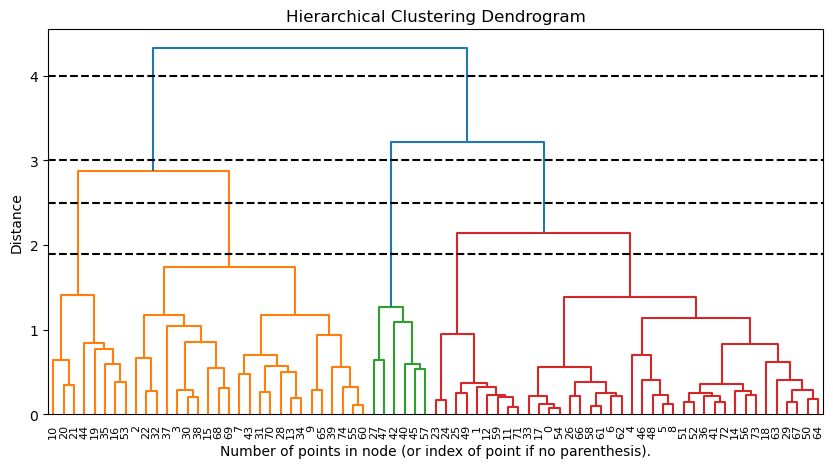

              Num. clusters              Datapoints per cluster Num. singleton clusters        SSE Avg. silhouette Davies-Bouldin
Clustering Id                                                                                                                    
0                         2                    [{0: 44, 1: 31}]                       0  25.339559        0.277266       1.485544
1                         3              [{0: 31, 1: 38, 2: 6}]                       0  20.168379        0.295448       1.250532
2                         4        [{0: 38, 1: 23, 2: 6, 3: 8}]                       0  16.022487        0.328263       1.096212
3                         5  [{0: 23, 1: 8, 2: 6, 3: 29, 4: 9}]                       0  13.723498        0.297164       1.044776


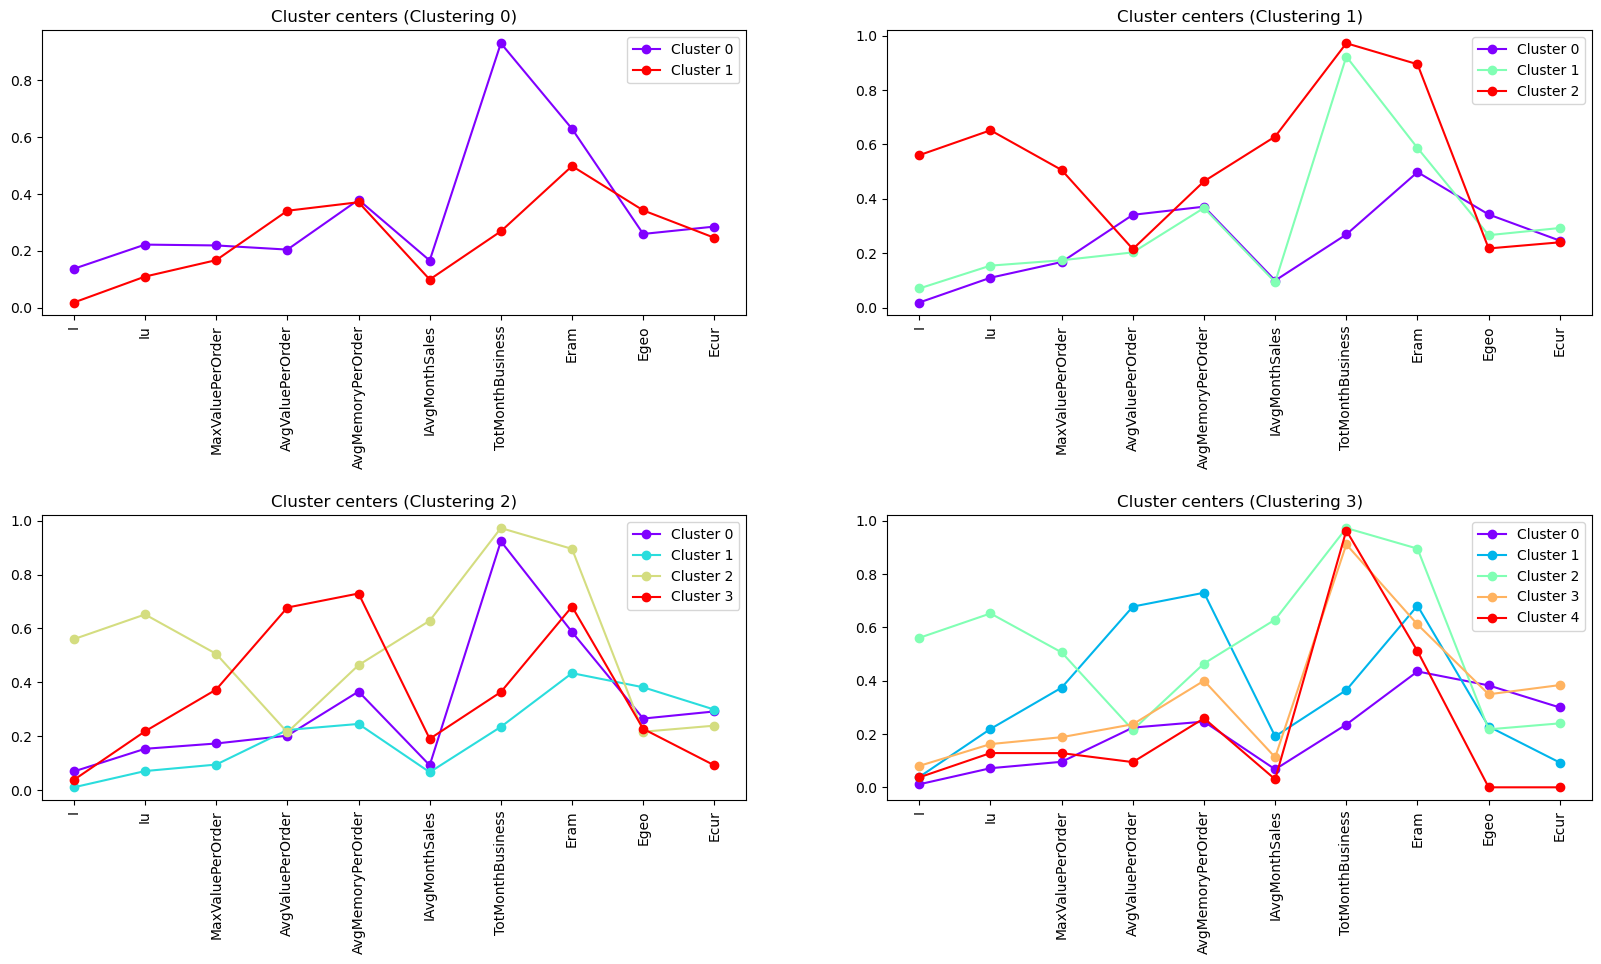

In [100]:
max_d = [4, 3, 2.5, 1.9]

hier_clustering_ward_res = []

for i in max_d:
    hier_clustering_ward_res.append(AgglomerativeClustering(distance_threshold=i, n_clusters=None, linkage="ward").fit(vendor_norm))

Z = linkage(vendor_norm, 'ward')
c, coph_dists = cophenet(Z, pdist(vendor_norm))
print(f"Cophenetic coefficient: {c}")

plot_dendrogram(hier_clustering_ward_res[0], max_d, truncate_mode='level', p=20)
visualise_model_characteristics([vendor_norm]*len(hier_clustering_ward_res), hier_clustering_ward_res)

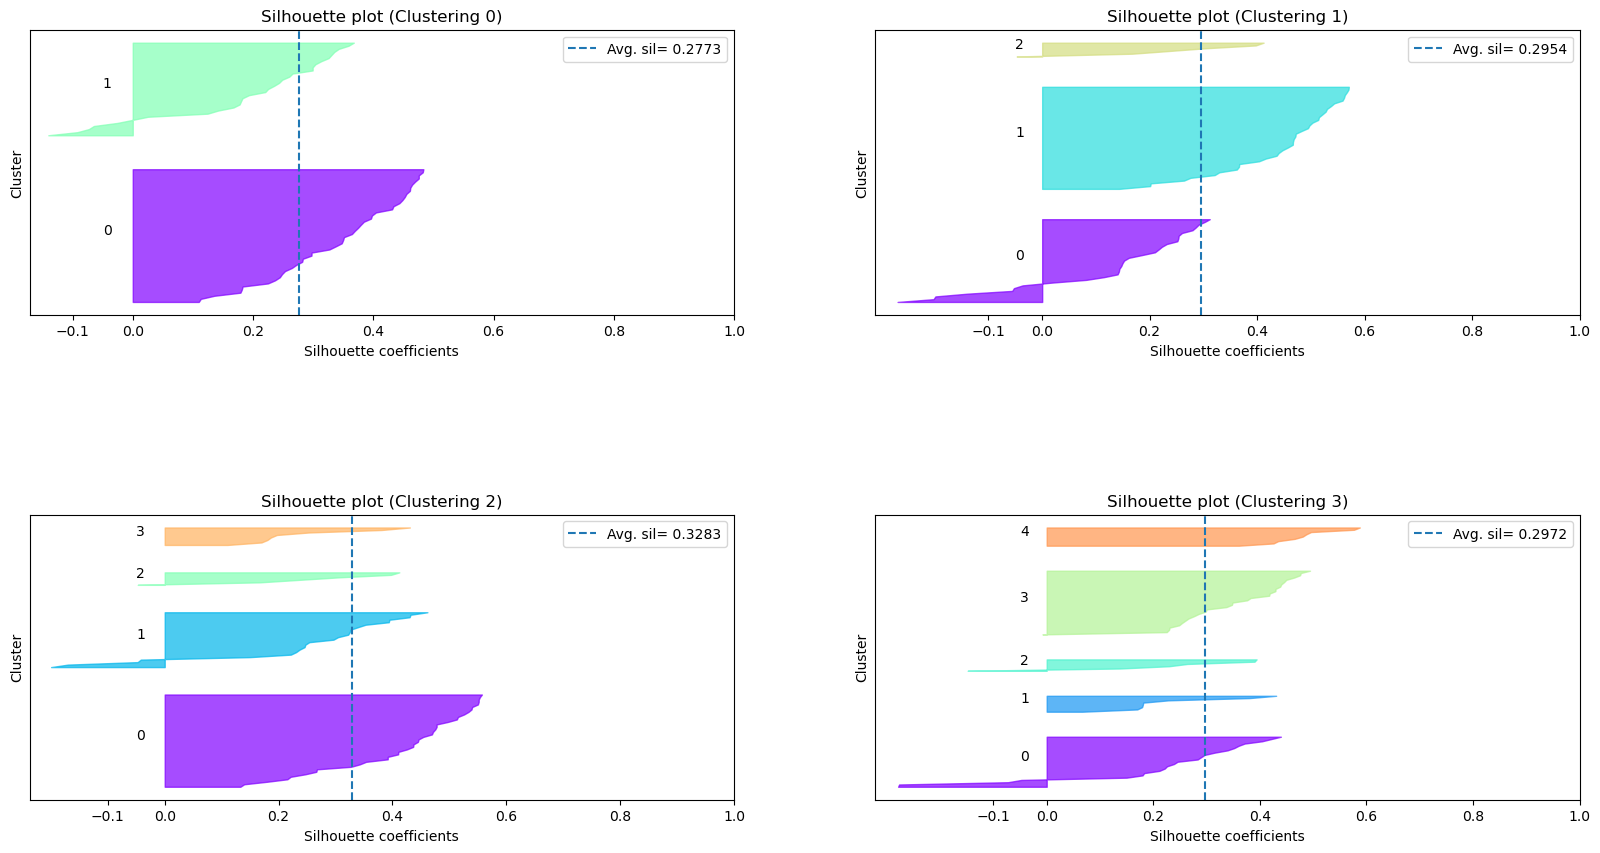

In [73]:
visualise_model_characteristics([vendor_norm]*len(hier_clustering_ward_res), hier_clustering_ward_res, ["sample_sil"])

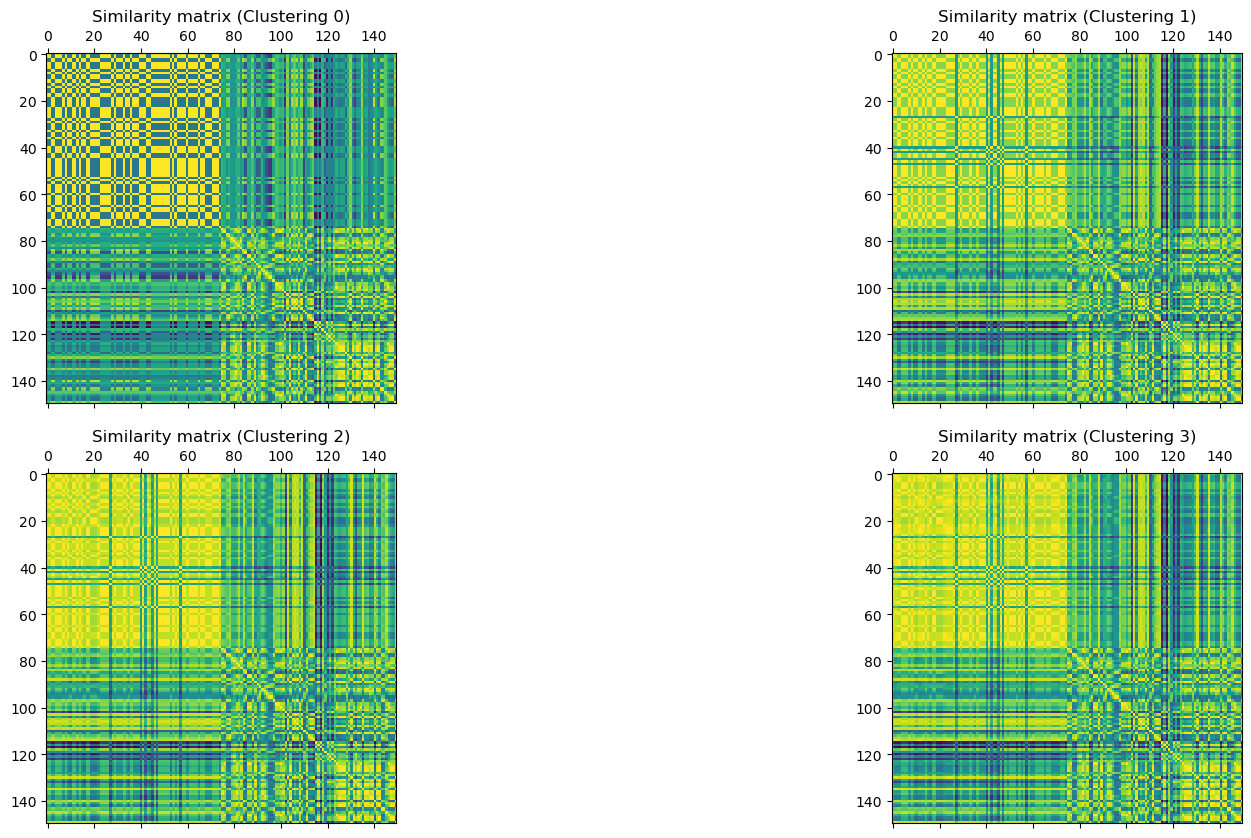

In [74]:
visualise_model_characteristics([vendor_norm]*len(hier_clustering_ward_res), hier_clustering_ward_res, ["simil_matrix"])

Based on the internal metrics and the cutting height the clustering 2 seems the most promising.  
Here find a different interpretation from the usual ones: **old-small** (0), **new-small-cheap** (1), **old-big** (2) and **new-small-expensive** (3) due to the higher than average value of AvgValuePerOrder.

In [75]:
ward_final = hier_clustering_ward_res[2]

cluster_map_ward = {0:"old-small", 1:"new-small-cheap", 2:"old-big", 3:"new-small-expensive"}

### External indices

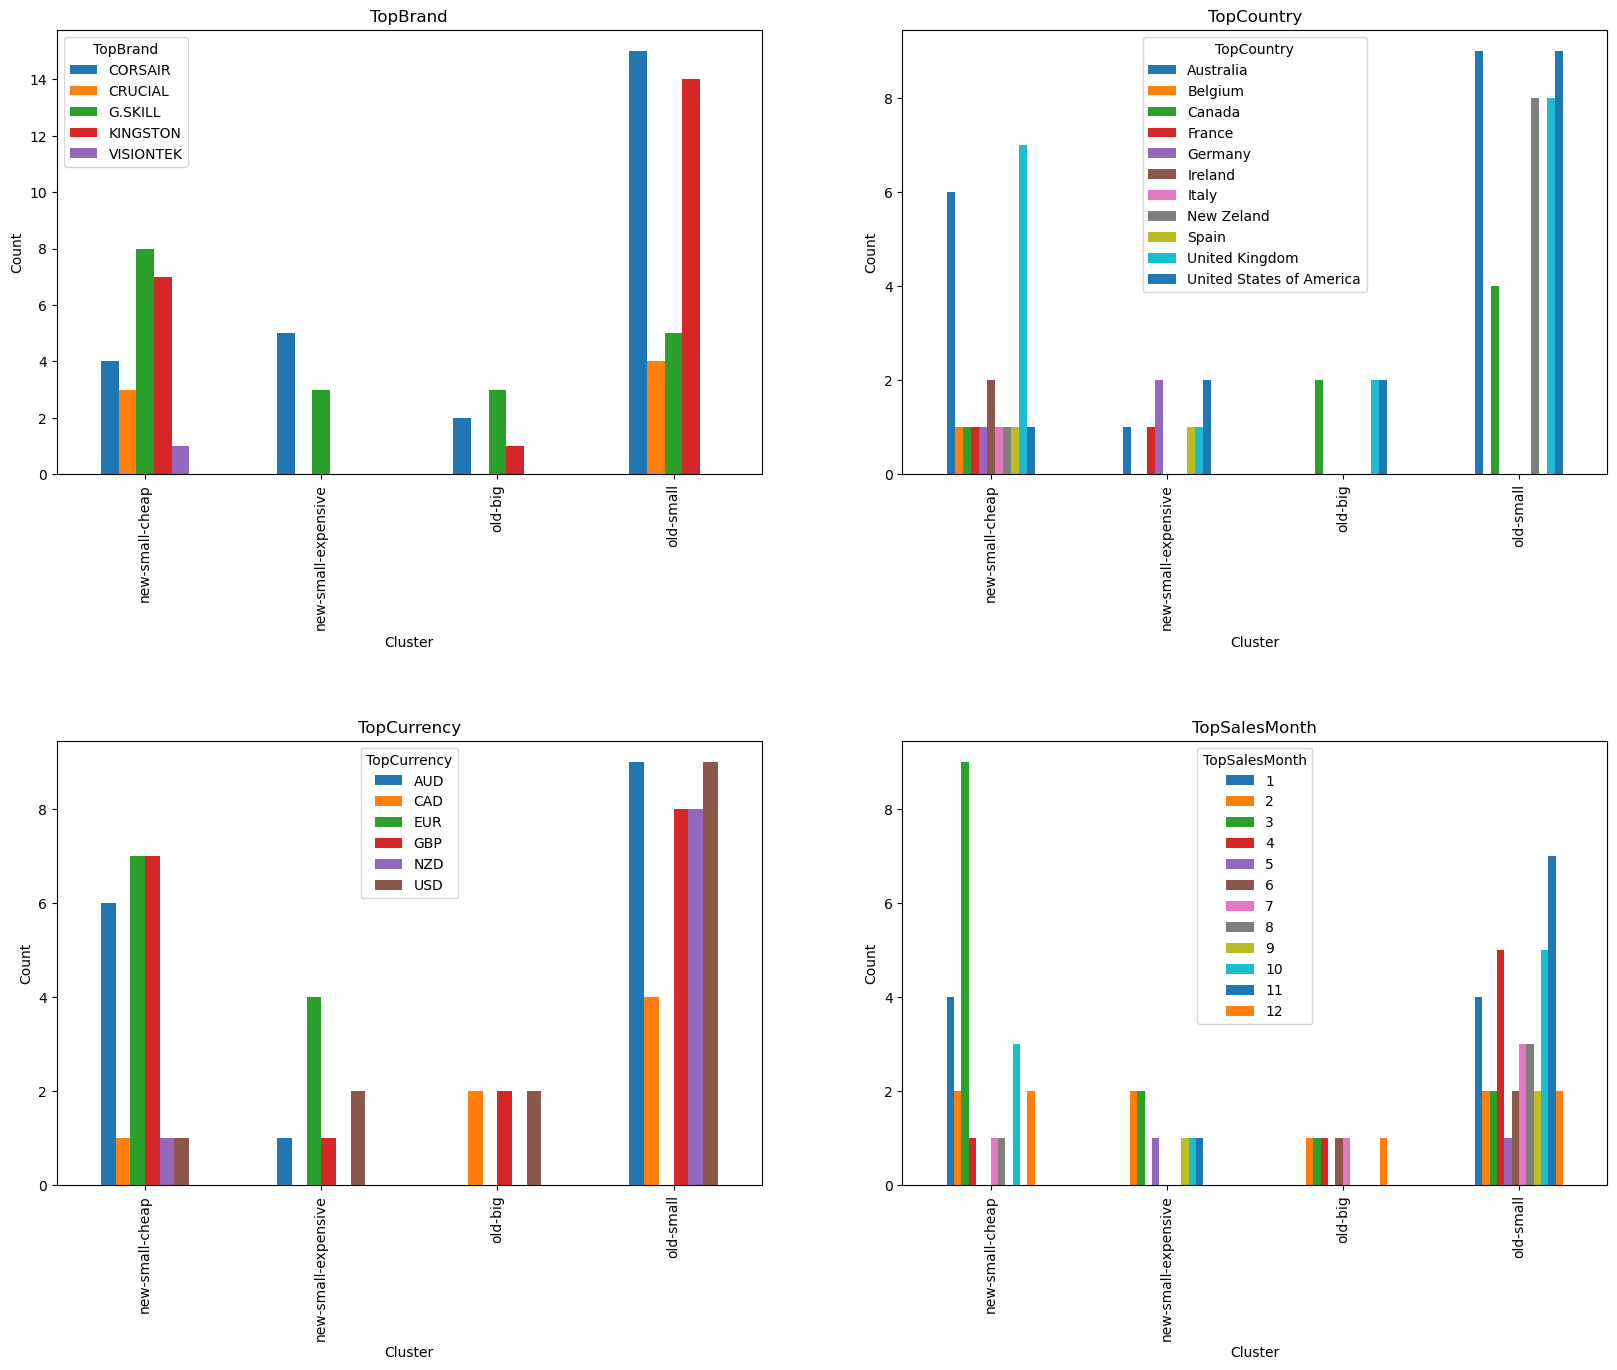

In [76]:
plot_categ_per_cluster(vendor_df_cat, ward_final, cluster_map_ward)

In [77]:
create_external_indices(vendor_df_cat, ward_final)

Feature  Homogeneity  Completeness  Mutual Info
0       TopBrand     0.099325      0.117154     0.107505
1     TopCountry     0.153388      0.266619     0.194741
2    TopCurrency     0.156252      0.237250     0.188415
3  TopSalesMonth     0.125301      0.257583     0.168591

#### Conclusion  
The results are pretty similar to the ones from average linkage, however in terms of metrics it should be closer to k-means given the common clusterisation based on minimising the clusters SSE.

## Clustering conclusions

In [78]:
def construct_clust_df(clust_dict):
    
    cols = ["Type", "Clusters", "SSE", "Silhouette", "Davies-Bouldin", "Ideal corr. avg", "Cophenetic coef."]
    
    out_df = pd.DataFrame(columns=cols)
    
    for key in clust_dict:
        
        model = clust_dict[key][0]
        k = len(np.unique(model.labels_))

        sse_score = compute_sse_global(vendor_norm, model.labels_)
        sil_score = silhouette_score(vendor_norm, model.labels_)
        db_score = davies_bouldin_score(vendor_norm, model.labels_)
        id_corr_avg = np.mean(compute_ideal_similarity_coeff(vendor_norm, model.labels_))
        coph_coef = np.NaN
        
        try:
            if model.get_params()["linkage"] != None:
                
                Z = linkage(vendor_norm, model.get_params()["linkage"])
                coph_coef, coph_dists = cophenet(Z, pdist(vendor_norm))
                
        except KeyError:
            pass

        new_entry = dict(zip(cols, [key, k, sse_score, sil_score, db_score, id_corr_avg, coph_coef]))
        out_df = out_df.append(new_entry, ignore_index=True)
        
    return out_df

In [79]:
clusterings_dict = {"K-means": (kmeans_final, cluster_map_kmeans),
                    "C-means": (cmeans_final, cluster_map_cmeans),
                    "DBSCAN": (dbscan_final, cluster_map_dbscan),
                    "Hier. single linkage": (single_final, cluster_map_single),
                    "Hier. complete linkage": (complete_final, cluster_map_complete),
                    "Hier. average linkage": (average_final, cluster_map_average),
                    "Hier. ward linkage": (ward_final, cluster_map_ward)}

name_model_dict = {k:v[0] for k,v in clusterings_dict.items()}
name_map_dict = {k:list(v[1].values()) for k,v in clusterings_dict.items()}
model_list = [v[0] for k,v in clusterings_dict.items()]

### Internal metrics

In [80]:
conclusion_res = construct_clust_df(clusterings_dict)
conclusion_res

Type Clusters        SSE  Silhouette  Davies-Bouldin  \
0                 K-means        3  19.604555    0.326206        1.222483   
1                 C-means        3  20.075618    0.285702        1.411721   
2                  DBSCAN        2  31.164668    0.308345        2.505490   
3    Hier. single linkage        2  32.294690    0.342998        2.110812   
4  Hier. complete linkage        2  28.158243    0.369885        1.040547   
5   Hier. average linkage        2  28.158243    0.369885        1.040547   
6      Hier. ward linkage        4  16.022487    0.328263        1.096212   

   Ideal corr. avg  Cophenetic coef.  
0         0.439060               NaN  
1         0.356643               NaN  
2         0.447247               NaN  
3         0.490579          0.676693  
4         0.479302          0.724248  
5         0.479302          0.790225  
6         0.454360          0.608212

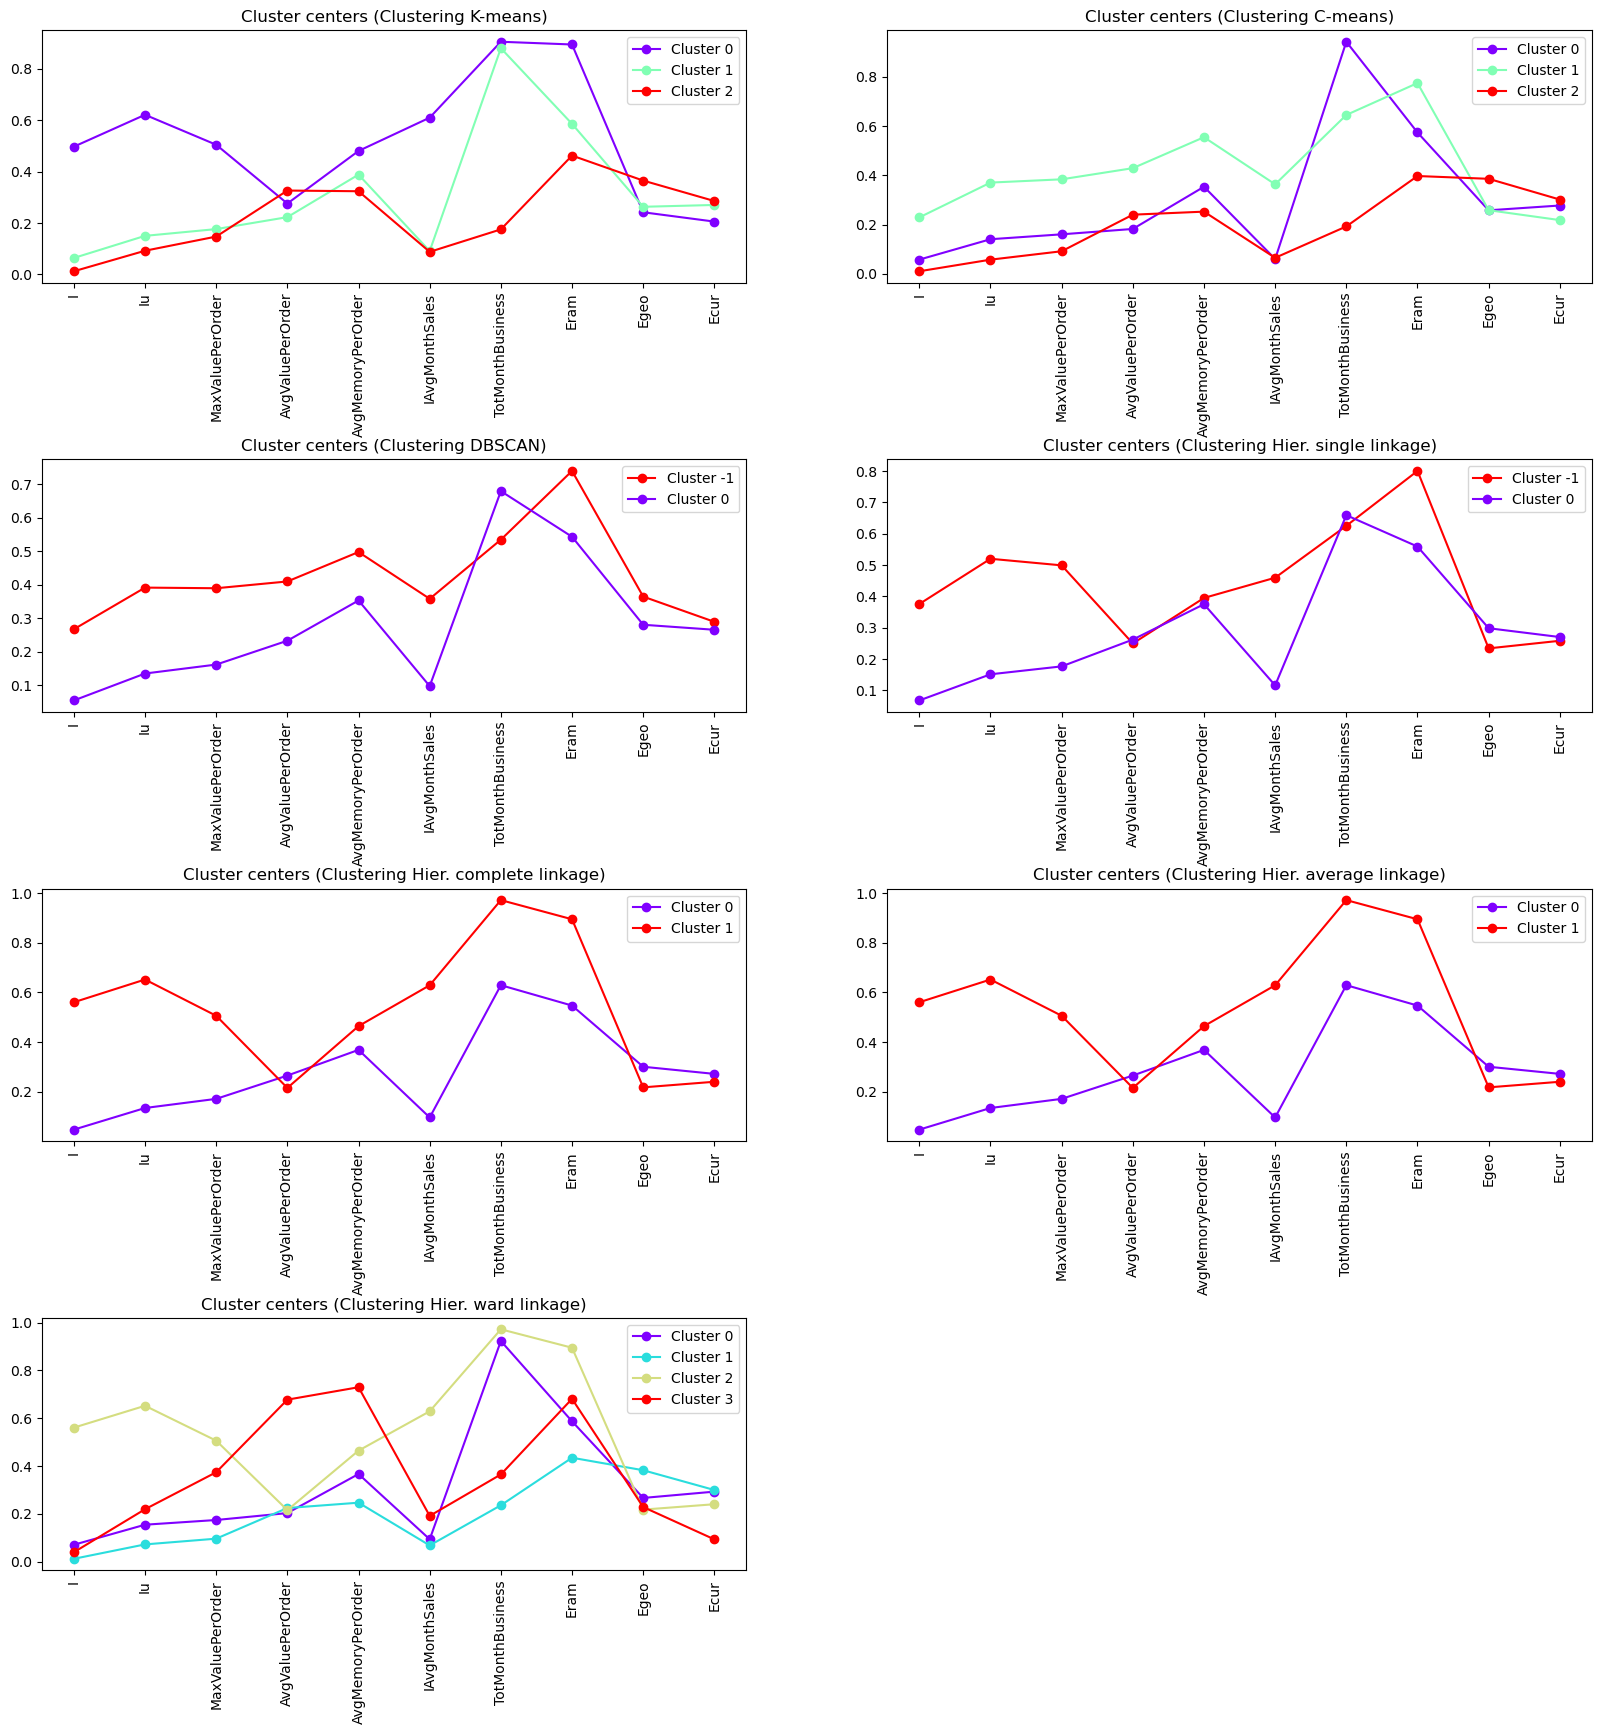

In [81]:
visualise_model_characteristics([vendor_norm]*len(model_list), model_list, ["avg"], list(clusterings_dict.keys()))

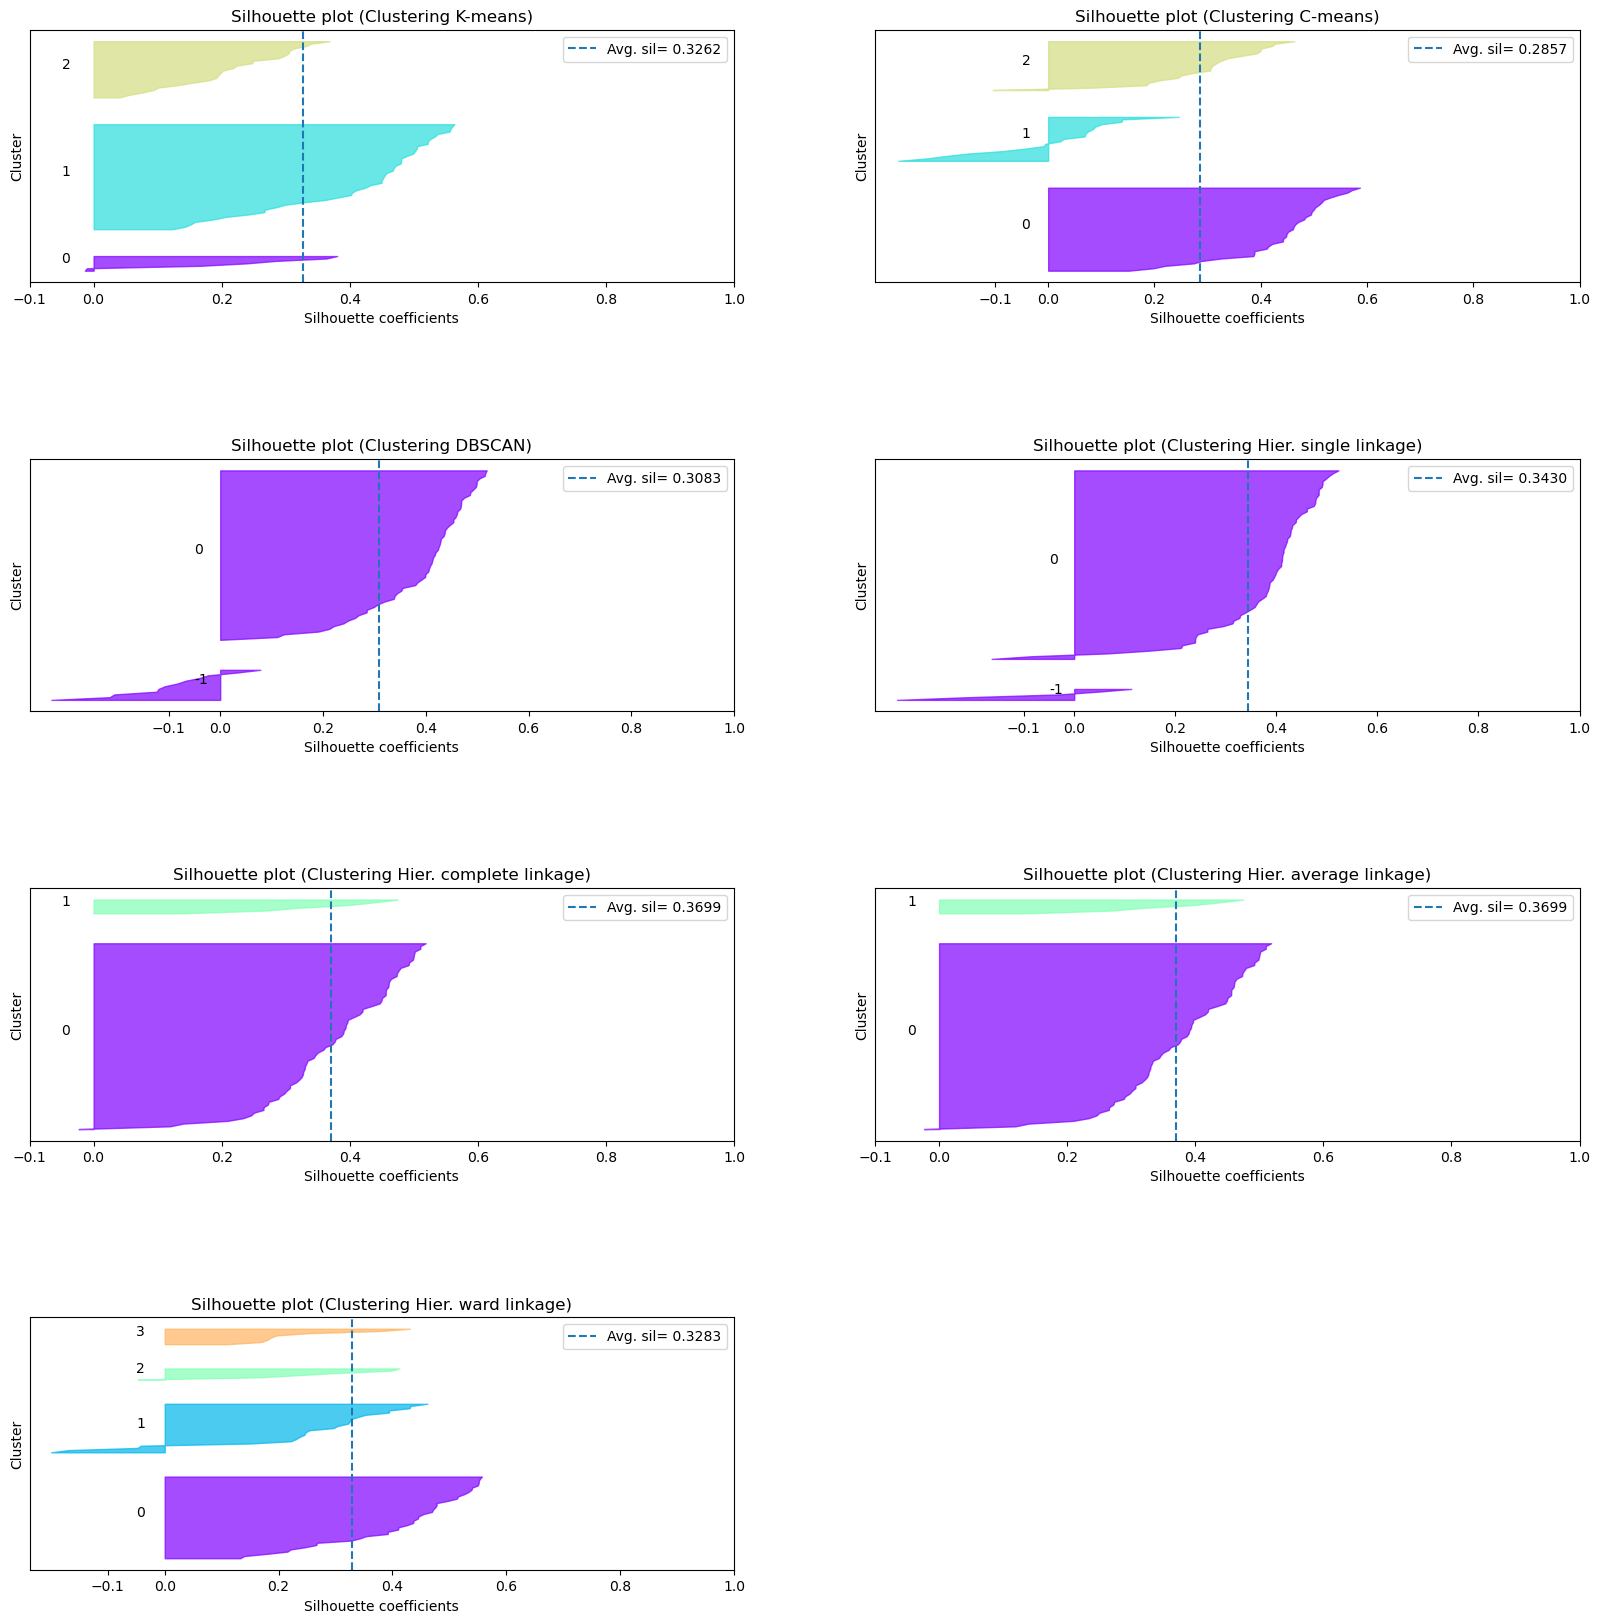

In [82]:
visualise_model_characteristics([vendor_norm]*len(model_list), model_list, ["sample_sil"], list(clusterings_dict.keys()))

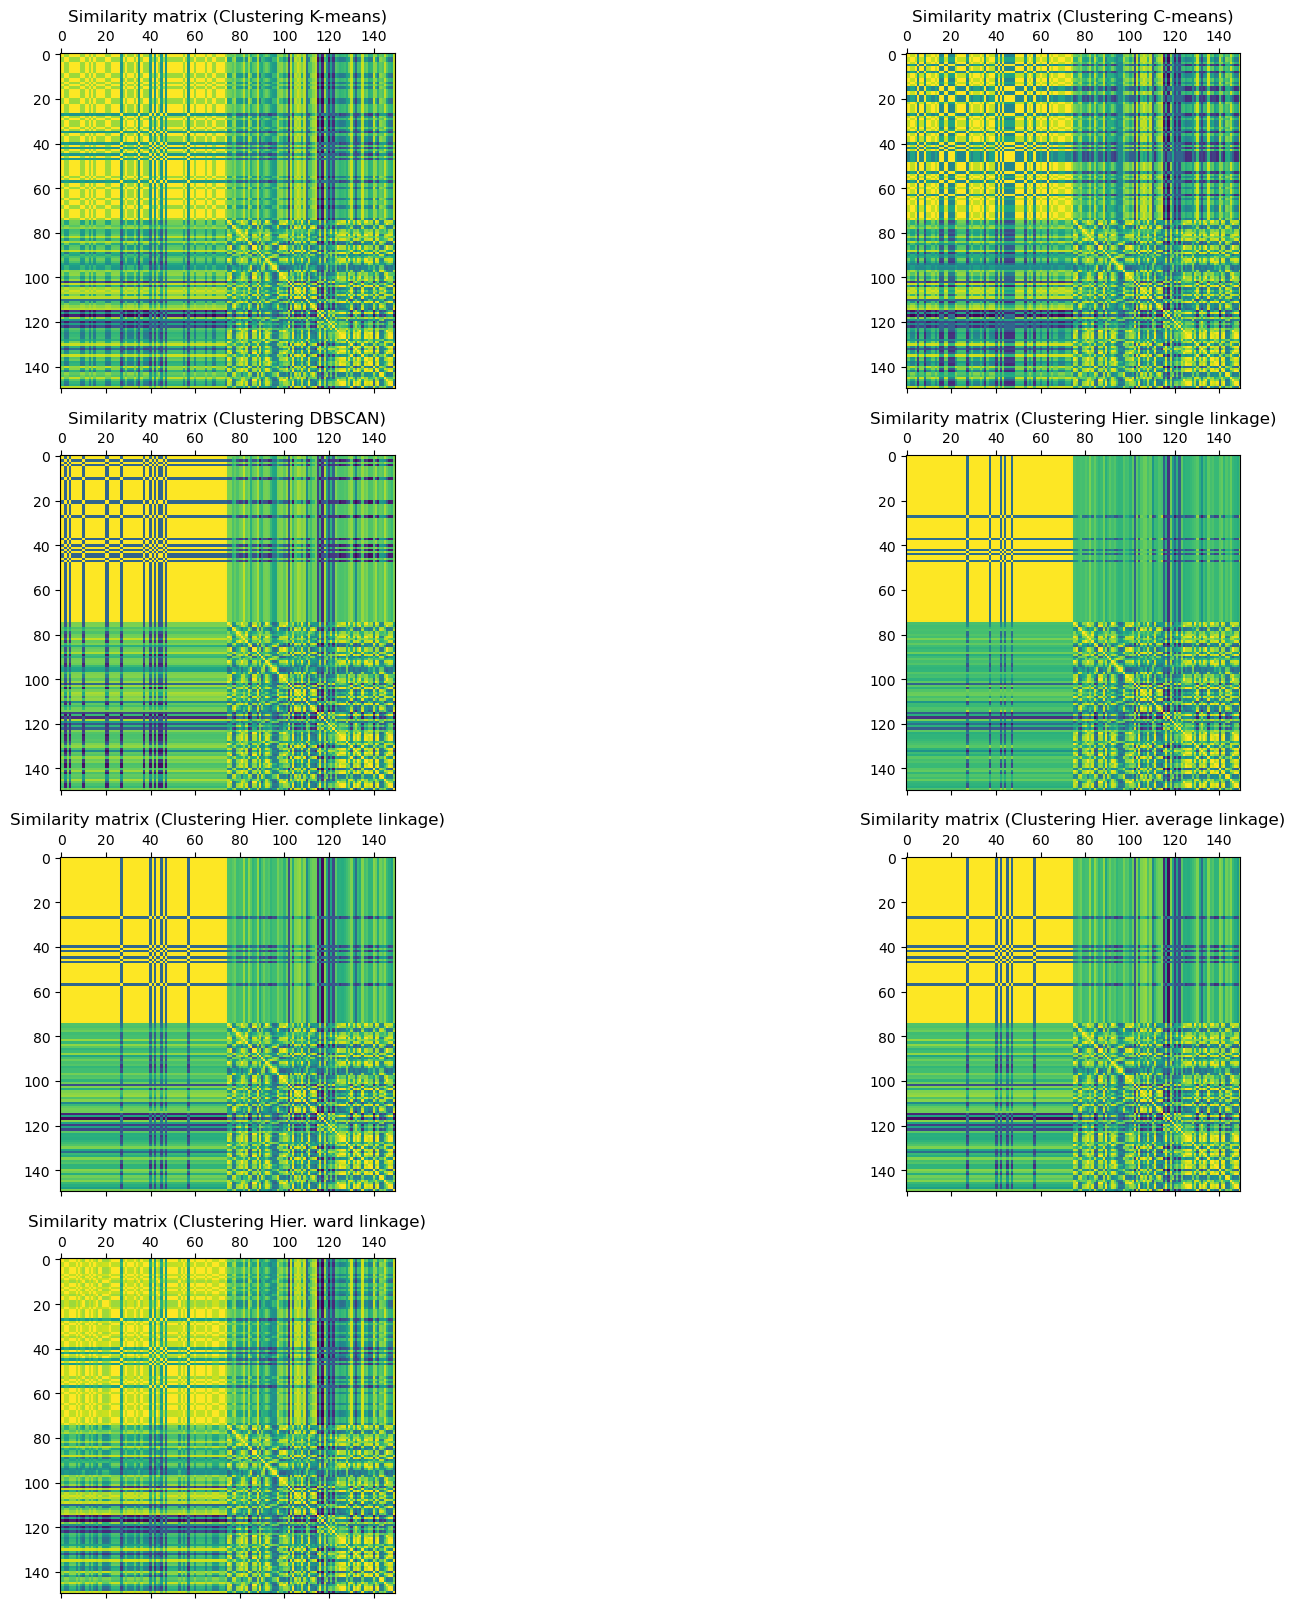

In [83]:
visualise_model_characteristics([vendor_norm]*len(model_list), model_list, ["simil_matrix"], list(clusterings_dict.keys()))

### External metrics

In [84]:
compare_df = compare_model_labels(name_model_dict, name_map_dict)
compare_df.sort_values("Mutual Info", ascending=False)

Model 1                            Model 2  \
18  Hier. complete linkage (2 labels)   Hier. average linkage (2 labels)   
5                  K-means (3 labels)      Hier. ward linkage (4 labels)   
10                 C-means (3 labels)      Hier. ward linkage (4 labels)   
0                  K-means (3 labels)                 C-means (3 labels)   
4                  K-means (3 labels)   Hier. average linkage (2 labels)   
3                  K-means (3 labels)  Hier. complete linkage (2 labels)   
11                  DBSCAN (2 labels)    Hier. single linkage (2 labels)   
19  Hier. complete linkage (2 labels)      Hier. ward linkage (4 labels)   
20   Hier. average linkage (2 labels)      Hier. ward linkage (4 labels)   
13                  DBSCAN (2 labels)   Hier. average linkage (2 labels)   
12                  DBSCAN (2 labels)  Hier. complete linkage (2 labels)   
15    Hier. single linkage (2 labels)  Hier. complete linkage (2 labels)   
16    Hier. single linkage (2 labels)   Hier. average linkage (2 labels)   
14                  DBSCAN (2 labels)      Hier. ward linkage (4 labels)   
1                  K-means (3 labels)                  DBSCAN (2 labels)   
9                  C-means (3 labels)   Hier. average linkage (2 labels)   
8                  C-means (3 labels)  Hier. complete linkage (2 labels)   
2                  K-means (3 labels)    Hier. single linkage (2 labels)   
17    Hier. single linkage (2 labels)      Hier. ward linkage (4 labels)   
6                  C-means (3 labels)                  DBSCAN (2 labels)   
7                  C-means (3 labels)    Hier. single linkage (2 labels)   

    Homogeneity  Completeness  Mutual Info                         Labels 1  \
18     1.000000      1.000000     1.000000                     (small, big)   
5      0.752266      0.589123     0.660773  (old-big, new-small, old-small)   
10     0.639903      0.590946     0.614451  (old-big, new-small, old-small)   
0      0.641572      0.544059     0.588805  (old-big, new-small, old-small)   
4      0.267560      0.862691     0.408443  (old-big, new-small, old-small)   
3      0.267560      0.862691     0.408443  (old-big, new-small, old-small)   
11     0.309912      0.556318     0.398069                     (big, small)   
19     1.000000      0.242884     0.390840                     (small, big)   
20     1.000000      0.242884     0.390840                     (small, big)   
13     0.231150      0.364566     0.282918                     (big, small)   
12     0.231150      0.364566     0.282918                     (big, small)   
15     0.280800      0.246714     0.262656                     (small, big)   
16     0.280800      0.246714     0.262656                     (small, big)   
14     0.403554      0.154590     0.223546                     (big, small)   
1      0.156033      0.318984     0.209559  (old-big, new-small, old-small)   
9      0.113947      0.433250     0.180438  (old-big, new-small, old-small)   
8      0.113947      0.433250     0.180438  (old-big, new-small, old-small)   
2      0.099467      0.365020     0.156334  (old-big, new-small, old-small)   
17     0.385594      0.082286     0.135629                     (small, big)   
6      0.086671      0.208942     0.122520  (old-big, new-small, old-small)   
7      0.057501      0.248834     0.093415  (old-big, new-small, old-small)   

                                             Labels 2  
18                                       (small, big)  
5   (old-small, new-small-cheap, old-big, new-smal...  
10  (old-small, new-small-cheap, old-big, new-smal...  
0                     (old-big, new-small, old-small)  
4                                        (small, big)  
3                                        (small, big)  
11                                       (small, big)  
19  (old-small, new-small-cheap, old-big, new-smal...  
20  (old-small, new-small-cheap, old-big, new-smal...  
13                                       (small, big)  
12

Some labelings have a strong connection with the ones from different clusterings according to the external indices, even if they don't share the same labels.  
Interesting how the clusterings obtained by complete linkage and ward linkage are identical, as can be seen by the scores.  

### Labels reduction  

An interesting property of the labelings is that the majority of them can be reduced to a more general category (ie big/small or new/old) and we can therefore more directly compare the results between clusterings with different labels.

In [85]:
old_new_reduction_map = {"old-big":"old", "old-small":"old", "old":"old", "new-small":"new", "new-small-cheap":"new", \
                         "new-small-expensive":"new", "new":"new", "big":"big", "small":"small"}

big_small_reduction_map = {"old-big":"big", "big":"big", "old-small":"small", "new-small":"small", "new-small-cheap":"small", \
                           "new-small-expensive":"small", "small":"small"}

In [86]:
def invert_map_dict(map_dict):
    
    list_values = list(map_dict.values())
    
    if len(list_values) != len(np.unique(list_values)):
        raise RuntimeError("Cannot invert: duplicate key values")
        
    new_dict = {}
    
    for k,v in map_dict.items():
        new_dict[v] = k
        
    return new_dict

def apply_reduction_map(clust_map, reduc_map):
    
    set_values = np.unique(list(reduc_map.values()))
    #ie {old:0, new:1}
    reduc_to_int_map = {set_values[i]:i for i in range(len(set_values))}
    
    new_clust_remapping = {}
    new_clust_map = {}
    
    for k,v in clust_map.items():
        new_label = reduc_map[v]
        new_int = reduc_to_int_map[new_label]
        new_clust_remapping[k] = new_int
        new_clust_map[new_int] = new_label
        
    return (new_clust_map, new_clust_remapping)

In [87]:
old_new_name_map_dict = {}
big_small_name_map_dict = {}

for k, v in clusterings_dict.items():
    
    model = v[0]
    old_labels = model.labels_
    int_name_map, clust_map_remapped = apply_reduction_map(v[1], old_new_reduction_map)
    new_labels = remap_clust_labels(old_labels, clust_map_remapped)
    old_new_name_map_dict[k] = (wrapper_sk(new_labels), int_name_map)


for k, v in clusterings_dict.items():
    
    model = v[0]
    old_labels = model.labels_
    int_name_map, clust_map_remapped = apply_reduction_map(v[1], big_small_reduction_map)
    new_labels = remap_clust_labels(old_labels, clust_map_remapped)
    big_small_name_map_dict[k] = (wrapper_sk(new_labels), int_name_map)

In [88]:
reduc_old_new_res = compare_model_labels({k:v[0] for k,v in old_new_name_map_dict.items()}, \
                                       {k:list(v[1].values()) for k,v in old_new_name_map_dict.items()})

labels_big_small_only = reduc_old_new_res.loc[(reduc_old_new_res["Labels 1"].isin([("small", "big"), ("big", "small")])) & \
                                             (reduc_old_new_res["Labels 2"].isin([("small", "big"), ("big", "small")]))]
reduc_old_new_res = reduc_old_new_res.drop(index=labels_big_small_only.index)
reduc_old_new_res

Model 1                            Model 2  \
0                  K-means (2 labels)                 C-means (2 labels)   
1                  K-means (2 labels)                  DBSCAN (2 labels)   
2                  K-means (2 labels)    Hier. single linkage (2 labels)   
3                  K-means (2 labels)  Hier. complete linkage (2 labels)   
4                  K-means (2 labels)   Hier. average linkage (2 labels)   
5                  K-means (2 labels)      Hier. ward linkage (2 labels)   
6                  C-means (2 labels)                  DBSCAN (2 labels)   
7                  C-means (2 labels)    Hier. single linkage (2 labels)   
8                  C-means (2 labels)  Hier. complete linkage (2 labels)   
9                  C-means (2 labels)   Hier. average linkage (2 labels)   
10                 C-means (2 labels)      Hier. ward linkage (2 labels)   
14                  DBSCAN (2 labels)      Hier. ward linkage (2 labels)   
17    Hier. single linkage (2 labels)      Hier. ward linkage (2 labels)   
19  Hier. complete linkage (2 labels)      Hier. ward linkage (2 labels)   
20   Hier. average linkage (2 labels)      Hier. ward linkage (2 labels)   

    Homogeneity  Completeness  Mutual Info      Labels 1      Labels 2  
0      0.611208      0.646168     0.628202    (old, new)    (old, new)  
1      0.021407      0.030522     0.025164    (old, new)  (big, small)  
2      0.001618      0.004141     0.002327    (old, new)  (small, big)  
3      0.051791      0.116463     0.071698    (old, new)  (small, big)  
4      0.051791      0.116463     0.071698    (old, new)  (small, big)  
5      0.647796      0.598900     0.622389    (old, new)    (old, new)  
6      0.000731      0.000985     0.000839    (old, new)  (big, small)  
7      0.002038      0.004933     0.002884    (old, new)  (small, big)  
8      0.046564      0.099043     0.063346    (old, new)  (small, big)  
9      0.046564      0.099043     0.063346    (old, new)  (small, big)  
10     0.561679      0.491188     0.524074    (old, new)    (old, new)  
14     0.006629      0.004298     0.005215  (big, small)    (old, new)  
17     0.000107      0.000039     0.000057  (small, big)    (old, new)  
19     0.161768      0.066508     0.094262  (small, big)    (old, new)  
20     0.161768      0.066508     0.094262  (small, big)    (old, new)

We removed the entries that compared only labels big/small.  
Intuitively, the lowest scores correspond to a mismatch of labels between Model 1 and Model 2 (ie old/new vs big/small).

In [89]:
reduc_old_new_res.describe()

Homogeneity  Completeness  Mutual Info
count    15.000000     15.000000    15.000000
mean      0.158231      0.156347     0.151318
std       0.238401      0.224786     0.231448
min       0.000107      0.000039     0.000057
25%       0.004333      0.004616     0.004049
50%       0.046564      0.066508     0.063346
75%       0.161768      0.116463     0.094262
max       0.647796      0.646168     0.628202

In [90]:
reduc_big_small_res = compare_model_labels({k:v[0] for k,v in big_small_name_map_dict.items()}, \
                                       {k:list(v[1].values()) for k,v in big_small_name_map_dict.items()})
reduc_big_small_res.sort_values("Homogeneity", ascending=False)

Model 1                            Model 2  \
20   Hier. average linkage (2 labels)      Hier. ward linkage (2 labels)   
18  Hier. complete linkage (2 labels)   Hier. average linkage (2 labels)   
19  Hier. complete linkage (2 labels)      Hier. ward linkage (2 labels)   
3                  K-means (2 labels)  Hier. complete linkage (2 labels)   
4                  K-means (2 labels)   Hier. average linkage (2 labels)   
5                  K-means (2 labels)      Hier. ward linkage (2 labels)   
0                  K-means (2 labels)                 C-means (2 labels)   
11                  DBSCAN (2 labels)    Hier. single linkage (2 labels)   
15    Hier. single linkage (2 labels)  Hier. complete linkage (2 labels)   
16    Hier. single linkage (2 labels)   Hier. average linkage (2 labels)   
17    Hier. single linkage (2 labels)      Hier. ward linkage (2 labels)   
1                  K-means (2 labels)                  DBSCAN (2 labels)   
12                  DBSCAN (2 labels)  Hier. complete linkage (2 labels)   
13                  DBSCAN (2 labels)   Hier. average linkage (2 labels)   
14                  DBSCAN (2 labels)      Hier. ward linkage (2 labels)   
8                  C-means (2 labels)  Hier. complete linkage (2 labels)   
9                  C-means (2 labels)   Hier. average linkage (2 labels)   
10                 C-means (2 labels)      Hier. ward linkage (2 labels)   
2                  K-means (2 labels)    Hier. single linkage (2 labels)   
6                  C-means (2 labels)                  DBSCAN (2 labels)   
7                  C-means (2 labels)    Hier. single linkage (2 labels)   

    Homogeneity  Completeness  Mutual Info      Labels 1      Labels 2  
20     1.000000      1.000000     1.000000  (small, big)  (small, big)  
18     1.000000      1.000000     1.000000  (small, big)  (small, big)  
19     1.000000      1.000000     1.000000  (small, big)  (small, big)  
3      0.775323      0.862691     0.816677  (big, small)  (small, big)  
4      0.775323      0.862691     0.816677  (big, small)  (small, big)  
5      0.775323      0.862691     0.816677  (big, small)  (small, big)  
0      0.462507      0.253480     0.327482  (big, small)  (big, small)  
11     0.309912      0.556318     0.398069  (big, small)  (small, big)  
15     0.280800      0.246714     0.262656  (small, big)  (small, big)  
16     0.280800      0.246714     0.262656  (small, big)  (small, big)  
17     0.280800      0.246714     0.262656  (small, big)  (small, big)  
1      0.268466      0.189400     0.222106  (big, small)  (big, small)  
12     0.231150      0.364566     0.282918  (big, small)  (small, big)  
13     0.231150      0.364566     0.282918  (big, small)  (small, big)  
14     0.231150      0.364566     0.282918  (big, small)  (small, big)  
8      0.213399      0.433250     0.285951  (big, small)  (small, big)  
9      0.213399      0.433250     0.285951  (big, small)  (small, big)  
10     0.213399      0.433250     0.285951  (big, small)  (small, big)  
2      0.196288      0.248581     0.219361  (big, small)  (small, big)  
6      0.132715      0.170838     0.149383  (big, small)  (big, small)  
7      0.084221      0.194612     0.117564  (big, small)  (small, big)

Here we can see that by reducing the labels to **big/small** all hierarchical clusterings, with the exception of single linkage, perform identically.  
The scores are also high between K-means and the hierarchical clusterings (excluding single linkage), further validating the validity of the findings.  
Noteworthy that the clusterings of C-means and K-means, both prototype-based, have low scores meaning that the results are not similar.

In [91]:
reduc_big_small_res.describe()

Homogeneity  Completeness  Mutual Info
count    21.000000     21.000000    21.000000
mean      0.426482      0.492138     0.446599
std       0.313247      0.302442     0.308554
min       0.084221      0.170838     0.117564
25%       0.213399      0.246714     0.262656
50%       0.280800      0.364566     0.285951
75%       0.775323      0.862691     0.816677
max       1.000000      1.000000     1.000000

The external indices are higher, on average, when considering the **big/small** reduction compared to the **old/new** .  
This shows a higher diversity in the old/new clusters, meaning that the labeling is less strong since it doesn't hold as well across clusterings.

## Conclusions
Based on these metrics' values we think that the best clustering are the ones obtained by hierarchical clustering (except single linkage), other than having a strong correspondance with many of the tested models it also has the highest internal metrics.  
These results will also be used in the clustering task.